# **Paper visuals and tables**: Comparison of subtypes

### Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (shapiro, ttest_ind, mannwhitneyu, pearsonr)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from scipy.stats import chi2_contingency
import matplotlib.ticker as ticker
 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pingouin as pg
import matplotlib as mpl
import matplotlib.patches as mpatches

import matplotlib.gridspec as gridspec

from matplotlib.pyplot import Figure

from PIL import Image


In [3]:
# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
axes_label_size= 14
title_size= 22
ytick_label_size= 14
xtick_label_size= 14
legend_size= 16
mpl.rcParams['axes.labelsize'] = axes_label_size
mpl.rcParams['axes.titlesize'] = title_size
mpl.rcParams['xtick.labelsize'] = ytick_label_size
mpl.rcParams['ytick.labelsize'] = legend_size
mpl.rcParams['legend.fontsize'] = legend_size

# Define a consistent color palette (blue-green spectrum)
cluster_colors = {
    "A": '#184e77',  # deep blue
    "B": '#1a759f',  # mid blue-teal
    "C": '#34a0a4',  # bright teal
    "a":'#184e77',  # deep blue
    "b":'#1a759f',  # mid blue-teal
    "c":'#34a0a4',  # bright teal
}

# Define font size for all titles in Seaborn plots

sns.set_context("paper", font_scale=1.5)


In [4]:
# Data preparation
def format_stats(group, col):
    stats = group[col].agg(['mean', 'std', 'min', 'max'])
    return {
        'M (SD)': f"{stats['mean']:.2f} ({stats['std']:.2f})",
        'Range (Min-Max)': f"{stats['min']:.2f} to {stats['max']:.2f}"
    }

# Create the table structure
def create_descriptive_table(df, class_column, vars_to_include):
    result_data = []
    
    # Group unique classes
    class_groups = df[class_column].unique()
    
    for group_name in class_groups:
        group_data = df[df[class_column] == group_name]
        row_data = {
            'Classification': class_column,
            'Group': f"Group {group_name}",
            'n': len(group_data)
        }
        
        # Calculate stats for each variable
        for var in vars_to_include:
            stats = format_stats(group_data, var)
            row_data[f"{var} M (SD)"] = stats['M (SD)']
            row_data[f"{var} Range"] = stats['Range (Min-Max)']
        
        result_data.append(row_data)
    
    return pd.DataFrame(result_data)

# Create helper function for chi-square tests and reporting
def perform_chi_square(df, group_var, demo_var):
    """
    Perform chi-square test and return formatted results
    """
    # Create contingency table
    contingency = pd.crosstab(df[group_var], df[demo_var])
    
    # Calculate chi-square
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Calculate Cramer's V for effect size
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    # Calculate standardized residuals
    observed = contingency.values
    standardized_residuals = (observed - expected) / np.sqrt(expected)
    
    return {
        'contingency': contingency,
        'chi2': chi2,
        'p': p,
        'dof': dof,
        'cramers_v': cramers_v,
        'residuals': standardized_residuals
    }

# Function to create a table with demographic information
def create_demographic_table(df, stratification_methods, demographic_vars):
    """
    Creates a table with demographic counts, percentages, and chi-square results
    """
    result_tables = {}
    
    for method in stratification_methods:
        method_results = {}
        for demo in demographic_vars:
            # Get counts and percentages
            counts = pd.crosstab(df[method], df[demo])
            percentages = pd.crosstab(df[method], df[demo], normalize='index') * 100
            
            # Perform chi-square
            chi_result = perform_chi_square(df, method, demo)
            
            # Store results
            method_results[demo] = {
                'counts': counts,
                'percentages': percentages,
                'chi2': chi_result['chi2'],
                'p': chi_result['p'],
                'cramers_v': chi_result['cramers_v']
            }
        
        result_tables[method] = method_results
    
    return result_tables

def calculate_p_values(df):
    """Calculate p-values for correlations in a dataframe, handling NAs"""
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                # Get the columns and drop NA values for valid comparison
                col1 = df.iloc[:, i]
                col2 = df.iloc[:, j]
                
                # Create a mask of non-NA values in both columns
                valid_mask = ~(col1.isna() | col2.isna())
                
                # Only calculate correlation if we have enough valid data points
                if valid_mask.sum() > 1:  # Need at least 2 points for correlation
                    _, p_value = pearsonr(col1[valid_mask], col2[valid_mask])
                    p_values.iloc[i, j] = p_value
                else:
                    p_values.iloc[i, j] = np.nan
            else:
                p_values.iloc[i, j] = 0  # Set diagonal to 0
    return p_values

def plot_correlation_matrix(corr_matrix, p_values, title, significance_method='bold'):
    """Create correlation heatmap with highlighted significant correlations
    
    Parameters:
    -----------
    corr_matrix : pandas DataFrame
        The correlation matrix to plot
    p_values : pandas DataFrame
        Matrix of p-values corresponding to correlations
    title : str
        Title for the plot
    significance_method : str
        Method to highlight significant correlations:
        - 'bold': Use bold text for significant correlations
        - 'border': Add black border around significant cells
        - 'intense': Use more intense colors for significant correlations
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create the base heatmap
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap="coolwarm", 
        center=0, 
        vmin=-1, 
        vmax=1, 
        square=True, 
        mask=mask,
        fmt=".2f",
        annot_kws={"size": 9}
    )
    
    # Create a custom annotation function for significant values
    #  
    if significance_method == 'bold' or significance_method == 'size':
        # Get all text elements from the heatmap
        # Create a new set of annotations for significant values
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix.columns)):
                # Only process cells in the lower triangle
                if i > j:  # Lower triangle only
                    is_significant = (not np.isnan(p_values.iloc[i, j]) and 
                                     p_values.iloc[i, j] < 0.05)
                    
                    if is_significant:
                        value = corr_matrix.iloc[i, j]
                        if significance_method == 'bold':
                            # Add a bold text annotation
                            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                                   ha='center', va='center', 
                                   fontweight='bold', color='black',
                                   fontsize=8)
                        elif significance_method == 'size':
                            # Add a larger text annotation
                            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                                   ha='center', va='center', 
                                   color='black', fontsize=12)
    
    # Add borders for significant cells
    elif significance_method == 'border':
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix.columns)):
                if i > j:  # Lower triangle only
                    is_significant = (not np.isnan(p_values.iloc[i, j]) and 
                                     p_values.iloc[i, j] < 0.05)
                    
                    if is_significant:
                        # Add border around significant cells
                        ax.add_patch(Rectangle((j, i), 1, 1, fill=False, 
                                              edgecolor='gray', lw=2))
    
    #  
    #  
    
    # Add p-value significance legend
    legend_text = {
        'bold': "Bold values indicate p < 0.05",
        'size': "Larger values indicate p < 0.05",
        'border': "Cells with gray borders indicate p < 0.05"
    }
    plt.figtext(0.5, 0.001, legend_text.get(significance_method, 
                                          "Highlighted cells indicate p < 0.05"), 
               ha="center")
    
    plt.title(title, fontsize=14, pad=20)
    plt.tight_layout()
    
    return ax


In [5]:
# Function to perform outlier removal using IQR
def handle_outliers_iqr(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    return df_filtered

In [6]:
# Write the date
date= "2025_04_23"
mplus_date = "May_2025"

## **Data setup:** combine LPA classes with HC classes

In [7]:
analysis_type= "5D"

In [8]:
# Lannguage variables 
language_vars = ['receptive_6', 'expressive_6', 'receptive_12',
       'expressive_12', 'receptive_18', 'expressive_18', 'receptive_24',
       'expressive_24', 'receptive_36', 'expressive_36', 'nonverbal_iq_6']
cleaned_language_vars= ['Receptive MSEL 6 months', 'Expressive MSEL 6 months',
                               
              'Receptive MSEL 12 months', 'Expressive MSEL 12 months',
              'Receptive MSEL 18 months', 'Expressive MSEL 18 months',
              'Receptive MSEL 24 months', 'Expressive MSEL 24 months',
              'Receptive MSEL 36 months', 'Expressive MSEL 36 months',
              'NVIQ']

In [9]:
# EEG variables
eeg_vars= ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6"]
clean_eeg_vars= ['Frontal Gamma Power', 'Connectivity Auditory',
       'Connectivity Language', 'Connectivity Speech', 'Power Lateralization']

In [10]:
# Clean up column names
clean_column_name_mapping = {
  'expressive_6': 'Expressive MSEL 6 months',
  'expressive_12': 'Expressive MSEL 12 months',
  'expressive_18': 'Expressive MSEL 18 months',
  'expressive_24': 'Expressive MSEL 24 months',
  'expressive_36': 'Expressive MSEL 36 months',
  'receptive_6': 'Receptive MSEL 6 months',
  'receptive_12': 'Receptive MSEL 12 months',
  'receptive_18': 'Receptive MSEL 18 months',
  'receptive_24': 'Receptive MSEL 24 months',
  'receptive_36': 'Receptive MSEL 36 months',
  'nonverbal_iq_6': 'NVIQ',
  'outcome': 'ASD Diagnosis',
  'sex': 'Sex', 
  'site': 'Site',
  'group_type': 'ASD Likelihood',
  'gamma_lat_6': 'Power Lateralization',
  'speech_con_6_left': 'Connectivity Speech',
  'auditory_con_6': 'Connectivity Auditory',
  'lang_comp_con_6': 'Connectivity Language',
  'front_gamma_6': 'Frontal Gamma Power', 
  'front_alpha_6': 'Frontal Alpha Power', 
  'stg_lat_6': 'STG Lateralization',
  'lang_lat_6': 'Language Power Lateralization',
  'lpa_class': 'LPA Class',
  'hc_class': 'HC Class'
}


####  Load LPA classes

In [11]:
# Load LPA classes
LPA_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/mplus_5D_3cls_250424.csv", delim_whitespace=True, header=None)
LPA_df.columns = ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6", "prob_class_1", "prob_class_2","prob_class_3","class"]
clinisubs_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/full_2025_04_23_5D.csv") 


# Make sure both neurosubs_df and clinisubs_df have the same number of rows
if len(LPA_df) == len(clinisubs_df):
    print("Both dataframes have the same number of rows")
    # Merge the two dataframes
    
    LPA_df = pd.concat([LPA_df, clinisubs_df], axis=1)

# Select only the columns we need
LPA_df["lpa_class"] = LPA_df["class"].astype(str)

LPA_df= LPA_df[["lpa_class","subject","prob_class_1", "prob_class_2", "prob_class_3"]]


Both dataframes have the same number of rows


In [12]:
LPA_df

lpa_class  subject  prob_class_1  prob_class_2  prob_class_3
0         1.0        2         0.997         0.003         0.000
1         3.0        3         0.003         0.000         0.997
2         3.0        5         0.023         0.000         0.977
3         3.0        6         0.000         0.008         0.992
4         3.0        8         0.040         0.000         0.959
..        ...      ...           ...           ...           ...
139       3.0      915         0.016         0.000         0.983
140       2.0      933         0.000         0.999         0.001
141       3.0      937         0.000         0.000         1.000
142       1.0       51         0.998         0.002         0.000
143       2.0      147         0.000         0.997         0.003

[144 rows x 5 columns]

#### Load language data

In [13]:
mullen_df = pd.read_csv("../../Datasets/behaviour/language_datasets/mullen_profiles_sept_2024.csv")  
mullen_df=mullen_df[language_vars + ["subject"]]
mullen_df

receptive_6  expressive_6  receptive_12  expressive_12  receptive_18  \
0            8.0           9.0          14.0           16.0           NaN   
1            5.0           7.0           9.0           14.0           NaN   
2            7.0           7.0          10.0           12.0           NaN   
3           10.0           7.0          13.0           15.0           NaN   
4            6.0           9.0          10.0           12.0           NaN   
..           ...           ...           ...            ...           ...   
187          4.0           5.0           9.0           14.0           NaN   
188          4.0           6.0          14.0           13.0           NaN   
189          5.0           5.0          13.0           15.0           NaN   
190          8.0           5.0          13.0           10.0          27.0   
191          7.0           6.0           8.0           10.0          13.0   

     expressive_18  receptive_24  expressive_24  receptive_36  expressive_36  \
0              NaN          31.0           28.0          49.0           55.0   
1              NaN           NaN            NaN           NaN            NaN   
2              NaN          25.0           21.0          42.0           53.0   
3              NaN          27.0           17.0          34.0           35.0   
4              NaN          27.0           22.0          28.0           31.0   
..             ...           ...            ...           ...            ...   
187            NaN           NaN            NaN           NaN            NaN   
188            NaN           NaN            NaN           NaN            NaN   
189            NaN          28.0           24.0           NaN            NaN   
190           21.0           NaN            NaN           NaN            NaN   
191           15.0           NaN            NaN           NaN            NaN   

     nonverbal_iq_6  subject  
0               9.0      601  
1              10.0      602  
2              11.0      603  
3              11.5      604  
4               9.0      605  
..              ...      ...  
187             4.5      164  
188             4.5      166  
189             7.0      915  
190             6.5      933  
191             7.5      937  

[192 rows x 12 columns]

#### Load hierachical clustering

In [14]:
hc_df = pd.read_csv(f"../../Datasets/hierarchical/clustering_solutions/2025_04_23/MICE/5D_cluster_solutions_6m_2025_04_23.csv")
# Merge with clinical data
hc_df["hc_class"] = hc_df["cluster3dcom"]

# Select only the columns we need
hc_df = hc_df[["subject", "hc_class"]]


In [15]:
hc_df

subject  hc_class
0          2         0
1          3         1
2          5         1
3          6         1
4          8         1
..       ...       ...
139      915         1
140      933         0
141      937         1
142       51         0
143      147         0

[144 rows x 2 columns]

#### Load demographic data and EEG

In [16]:
clinisubs_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/full_2025_04_23_5D.csv") 
clinisubs_df

subject group_type outcome sex        site  front_gamma_6  \
0          2        ELA  no-asd   M  washington     -21.420116   
1          3        ELA  no-asd   M  washington     -21.072590   
2          5        TLA     NaN   M  washington     -22.141673   
3          6        ELA  no-asd   M  washington     -21.630370   
4          8        ELA     asd   M  washington     -21.588120   
..       ...        ...     ...  ..         ...            ...   
139      915        TLA  no-asd   M  washington     -20.919022   
140      933        TLA     asd   M  washington     -21.463387   
141      937        TLA  no-asd   M  washington     -21.106285   
142       51        TLA  no-asd   M  washington            NaN   
143      147        TLA  no-asd   F  washington            NaN   

     auditory_con_6  lang_comp_con_6  speech_con_6_left  gamma_lat_6  
0         -1.598480        -1.161137          -1.225266          NaN  
1         -1.829292        -1.516043          -1.659758     0.040530  
2         -1.823852        -1.619339          -1.464546    -0.016544  
3         -1.429544        -1.602488          -1.757113    -0.164802  
4         -1.765373        -1.587519          -1.432471    -0.108383  
..              ...              ...                ...          ...  
139       -1.788839        -1.603515          -1.522898     0.042839  
140       -1.071994        -1.285763          -1.526620    -0.097921  
141       -1.762447        -1.702147          -1.740539          NaN  
142       -1.490023        -1.357769          -1.000501    -0.088992  
143       -1.030670        -1.411843          -1.613702    -0.131578  

[144 rows x 10 columns]

#### Merge all dataframes

In [17]:
# Merge HC class with clinical data
neurosubs_df = hc_df.merge(clinisubs_df, on="subject", how="left")

# Merge with LPA data
neurosubs_df = neurosubs_df.merge(LPA_df, on="subject", how="left")

In [18]:
# Merge with Mullen language data
neurosubs_df = neurosubs_df.merge(mullen_df, on="subject", how="left")

In [19]:
neurosubs_df

subject  hc_class group_type outcome sex        site  front_gamma_6  \
0          2         0        ELA  no-asd   M  washington     -21.420116   
1          3         1        ELA  no-asd   M  washington     -21.072590   
2          5         1        TLA     NaN   M  washington     -22.141673   
3          6         1        ELA  no-asd   M  washington     -21.630370   
4          8         1        ELA     asd   M  washington     -21.588120   
..       ...       ...        ...     ...  ..         ...            ...   
139      915         1        TLA  no-asd   M  washington     -20.919022   
140      933         0        TLA     asd   M  washington     -21.463387   
141      937         1        TLA  no-asd   M  washington     -21.106285   
142       51         0        TLA  no-asd   M  washington            NaN   
143      147         0        TLA  no-asd   F  washington            NaN   

     auditory_con_6  lang_comp_con_6  speech_con_6_left  ...  expressive_6  \
0         -1.598480        -1.161137          -1.225266  ...           5.0   
1         -1.829292        -1.516043          -1.659758  ...           7.0   
2         -1.823852        -1.619339          -1.464546  ...           5.0   
3         -1.429544        -1.602488          -1.757113  ...           4.0   
4         -1.765373        -1.587519          -1.432471  ...           5.0   
..              ...              ...                ...  ...           ...   
139       -1.788839        -1.603515          -1.522898  ...           5.0   
140       -1.071994        -1.285763          -1.526620  ...           5.0   
141       -1.762447        -1.702147          -1.740539  ...           6.0   
142       -1.490023        -1.357769          -1.000501  ...           5.0   
143       -1.030670        -1.411843          -1.613702  ...           6.0   

    receptive_12  expressive_12  receptive_18  expressive_18  receptive_24  \
0           13.0           13.0          22.0           14.0          28.0   
1           14.0           14.0          20.0           18.0          27.0   
2            NaN            NaN           NaN            NaN           NaN   
3           13.0           12.0          20.0           21.0          28.0   
4           11.0            8.0          20.0           21.0          28.0   
..           ...            ...           ...            ...           ...   
139         13.0           15.0           NaN            NaN          28.0   
140         13.0           10.0          27.0           21.0           NaN   
141          8.0           10.0          13.0           15.0           NaN   
142         11.0           12.0          20.0           18.0           NaN   
143         11.0           14.0           NaN            NaN           NaN   

     expressive_24  receptive_36  expressive_36  nonverbal_iq_6  
0             21.0           NaN            NaN             7.0  
1             21.0           NaN            NaN             6.5  
2              NaN           NaN            NaN             5.0  
3             27.0           NaN            NaN             6.0  
4             24.0           NaN            NaN             6.0  
..             ...           ...            ...             ...  
139           24.0           NaN            NaN             7.0  
140            NaN           NaN            NaN             6.5  
141            NaN           NaN            NaN             7.5  
142            NaN           NaN            NaN             8.0  
143            NaN           NaN            NaN             8.0  

[144 rows x 26 columns]

In [20]:
# Save the neurosubs_df and create directory if it doesn't exist
if not os.path.exists("../../Datasets/neurosub_solutions/"):
    os.makedirs("../../Datasets/neurosub_solutions/")
    
neurosubs_df.to_csv(f"../../Datasets/neurosub_solutions/neurosubs_df_{date}_{analysis_type}.csv", index=False)

## **Descriptive statistics**

#### Demographics

In [21]:
# Total number of subjects
total_subjects = len(neurosubs_df)
total_subjects



144

##### Autism ASD Diagnosis 

In [22]:
neurosubs_df["outcome"].value_counts()


no-asd    114
asd        22
Name: outcome, dtype: int64

##### Autism Risk 

In [23]:
neurosubs_df["group_type"].value_counts()

TLA    75
ELA    69
Name: group_type, dtype: int64

##### Site counts

In [24]:
neurosubs_df["site"].value_counts()
# We have a total of 99 in london and 83 in washington

washington    77
london        67
Name: site, dtype: int64

##### Sex differences

In [25]:
neurosubs_df[["sex"]].value_counts()


sex
M      76
F      68
dtype: int64

##### Break down across variables

In [26]:
comprehensive_table=neurosubs_df.groupby(["group_type", "site", "sex"]).outcome.value_counts().reset_index(name='count')
comprehensive_table = comprehensive_table.rename(columns={"group_type": "ASD Likelihood", "site": "Site", "sex":"Sex", "outcome":"ASD Diagnosis"})

# Save as supplementary table
comprehensive_table.to_csv(f"../../Tables/Supplementary/{date}/comprehensive_demographics_table_{date}.csv", index=False)
comprehensive_table

ASD Likelihood        Site Sex ASD Diagnosis  count
0             ELA      london   F        no-asd     16
1             ELA      london   F           asd      2
2             ELA      london   M           asd      9
3             ELA      london   M        no-asd      5
4             ELA  washington   F           asd      6
5             ELA  washington   F        no-asd      6
6             ELA  washington   M        no-asd     21
7             ELA  washington   M           asd      2
8             TLA      london   F        no-asd     19
9             TLA      london   M        no-asd     12
10            TLA  washington   F        no-asd     14
11            TLA  washington   F           asd      1
12            TLA  washington   M        no-asd     21
13            TLA  washington   M           asd      2

#### Participants demographics table

In [27]:
# Total sample size
total_n = len(neurosubs_df)

# Create a dictionary to store all the table data
table_data = {
    "Characteristic": [],
    "n": [],
    "%": []
}

# 1. Diagnostic Status
diag_counts = neurosubs_df['outcome'].value_counts()
table_data["Characteristic"].extend(["Diagnostic Status", "asd", "no-asd"])
table_data["n"].extend(["", diag_counts.get("asd", 0), diag_counts.get("no-asd", 0)])
table_data["%"].extend(["", 
                       round(diag_counts.get("asd", 0)/total_n*100, 1),
                       round(diag_counts.get("no-asd", 0)/total_n*100, 1)])

# 2. ASD Likelihood  
group_counts = neurosubs_df['group_type'].value_counts()
table_data["Characteristic"].extend(["ASD Likelihood", "TLA", "ELA"])
table_data["n"].extend(["", group_counts.get("TLA", 0), group_counts.get("ELA", 0)])
table_data["%"].extend(["", 
                       round(group_counts.get("TLA", 0)/total_n*100, 1),
                       round(group_counts.get("ELA", 0)/total_n*100, 1)])

# 3. Site
site_counts = neurosubs_df['site'].value_counts()
table_data["Characteristic"].extend(["Site", "london", "washington"])
table_data["n"].extend(["", site_counts.get("london", 0), site_counts.get("washington", 0)])
table_data["%"].extend(["", 
                       round(site_counts.get("london", 0)/total_n*100, 1),
                       round(site_counts.get("washington", 0)/total_n*100, 1)])

# 4. Sex
sex_counts = neurosubs_df['sex'].value_counts()
table_data["Characteristic"].extend(["Sex", "M", "F"])
table_data["n"].extend(["", sex_counts.get("M", 0), sex_counts.get("F", 0)])
table_data["%"].extend(["", 
                       round(sex_counts.get("M", 0)/total_n*100, 1),
                       round(sex_counts.get("F", 0)/total_n*100, 1)])

# Create the dataframe
table_df = pd.DataFrame(table_data)

# Rename the values in the characteristic column
table_df["Characteristic"] = table_df["Characteristic"].replace({
    "asd": "ASD",
    "no-asd": "No ASD",
    "TLA": "Typical",
    "ELA": "Elevated",
    "london": "London",
    "washington": "Washington",
    "M": "Male",
    "F": "Female"
})

# Save the table as a CSV file and check if the directory exists
if not os.path.exists(f"../../Tables/Main/{date}/"):
    os.makedirs(f"../../Tables/Main/{date}/")

table_df.to_csv(f"../../Tables/Main/{date}/demographics_table_{date}.csv", index=False)
table_df


Characteristic    n     %
0   Diagnostic Status           
1                 ASD   22  15.3
2              No ASD  114  79.2
3      ASD Likelihood           
4             Typical   75  52.1
5            Elevated   69  47.9
6                Site           
7              London   67  46.5
8          Washington   77  53.5
9                 Sex           
10               Male   76  52.8
11             Female   68  47.2

In [28]:
table_df

Characteristic    n     %
0   Diagnostic Status           
1                 ASD   22  15.3
2              No ASD  114  79.2
3      ASD Likelihood           
4             Typical   75  52.1
5            Elevated   69  47.9
6                Site           
7              London   67  46.5
8          Washington   77  53.5
9                 Sex           
10               Male   76  52.8
11             Female   68  47.2

### Create plotting df with clean column names

In [29]:
plotting_df = neurosubs_df.copy()
# Rename the columns based on the mapping
plotting_df.rename(columns=clean_column_name_mapping, inplace=True)

# Rename the group values
plotting_df["LPA Class"] = plotting_df["LPA Class"].replace({"1.0": "A", "2.0": "B", "3.0": "C"})
plotting_df["HC Class"] = plotting_df["HC Class"].replace({0: "b", 1: "c", 2: "a"})

# Order the LPA classes
plotting_df["LPA Class"] = pd.Categorical(plotting_df["LPA Class"], categories=["A", "B", "C"], ordered=True)
# Order the HC classes
plotting_df["HC Class"] = pd.Categorical(plotting_df["HC Class"], categories=["a", "b", "c"], ordered=True)


In [30]:
# Select palette colors for the plot
palette = sns.color_palette("viridis", n_colors=3)  # Set1 has 3 colors
# Use cluster colours
palette= [cluster_colors["A"], cluster_colors["B"], cluster_colors["C"]]

### **EEG Feature Distribution**

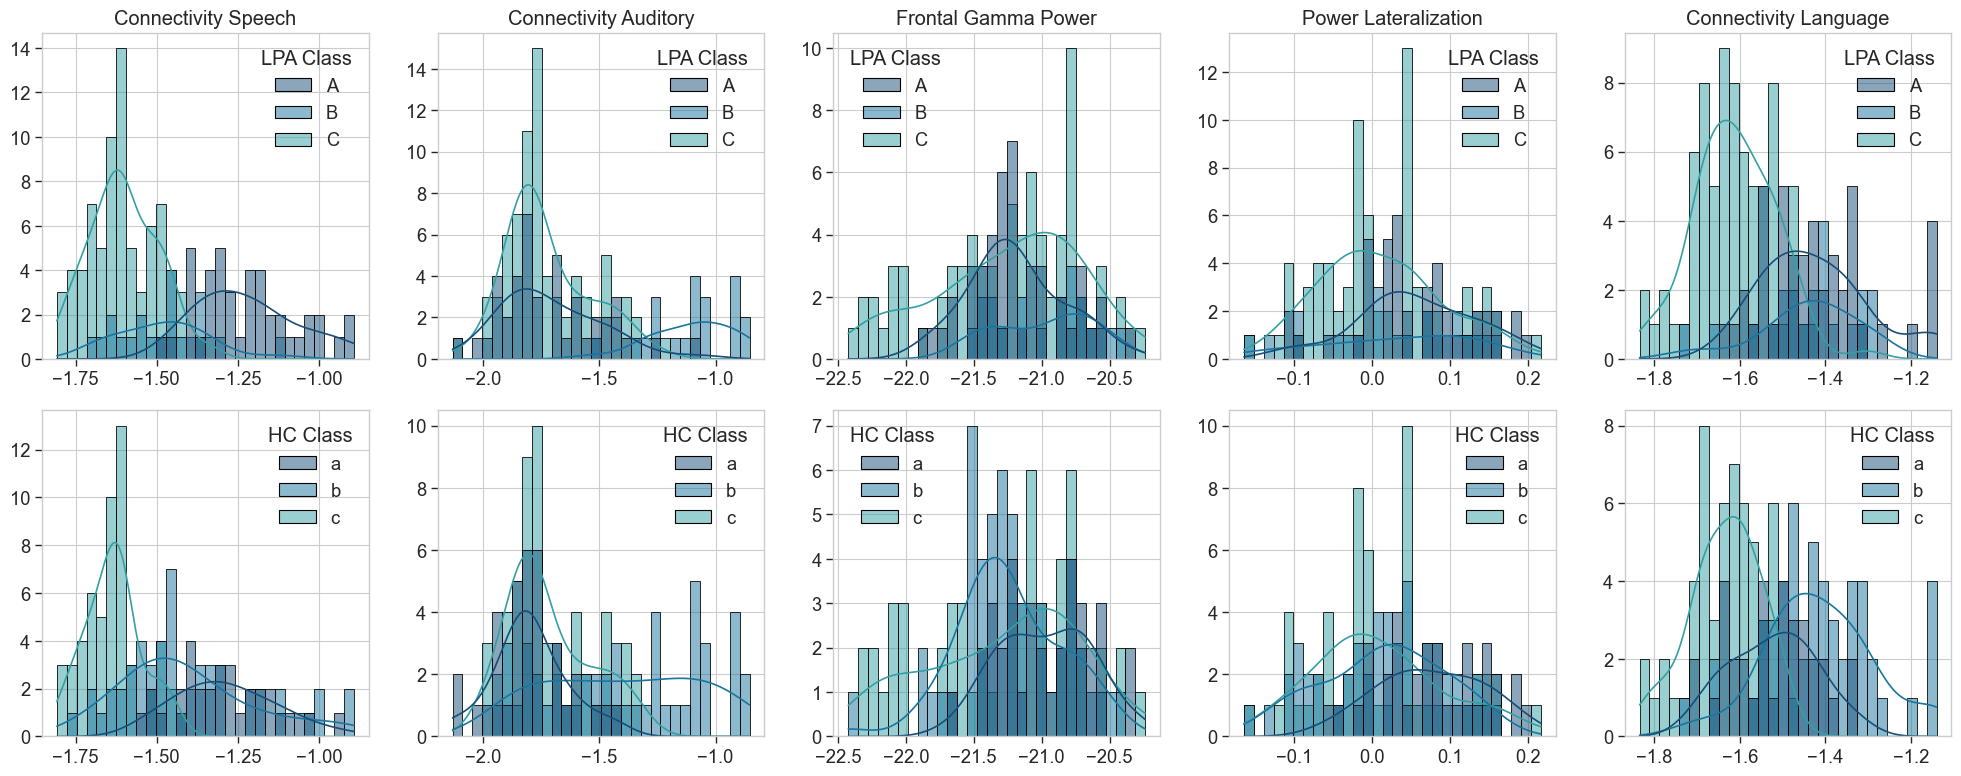

In [31]:
# Plot hitogram of each variable in eeg vars

# Create 4 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

sns.histplot(data=plotting_df, x="Connectivity Speech", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 0])
sns.histplot(data=plotting_df, x="Connectivity Speech", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 0])
axs[0, 0].set_title("Connectivity Speech")
axs[1, 0].set_title("")
axs[0, 0].set_xlabel("")
axs[1, 0].set_xlabel("")
axs[0, 0].set_ylabel("")
axs[1, 0].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Auditory", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 1])
sns.histplot(data=plotting_df, x="Connectivity Auditory", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 1])
axs[0, 1].set_title("Connectivity Auditory")
axs[1, 1].set_title("")
axs[0, 1].set_xlabel("")
axs[1, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 2])
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 2])
axs[0, 2].set_title("Frontal Gamma Power")
axs[1, 2].set_title("")
axs[0, 2].set_xlabel("")
axs[1, 2].set_xlabel("")
axs[0, 2].set_ylabel("")
axs[1, 2].set_ylabel("")
sns.histplot(data=plotting_df, x="Power Lateralization", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 3])
sns.histplot(data=plotting_df, x="Power Lateralization", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 3])
axs[0, 3].set_title("Power Lateralization")
axs[1, 3].set_title("")
axs[0, 3].set_xlabel("")
axs[1, 3].set_xlabel("")
axs[0, 3].set_ylabel("")
axs[1, 3].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Language", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 4])
sns.histplot(data=plotting_df, x="Connectivity Language", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 4])
axs[0, 4].set_title("Connectivity Language")
axs[1, 4].set_title("")
axs[0, 4].set_xlabel("")
axs[1, 4].set_xlabel("")
axs[0, 4].set_ylabel("")
axs[1, 4].set_ylabel("")
plt.tight_layout()

# Save the plot
if not os.path.exists(f"../../Figures/"):
    os.makedirs(f"../../Figures//")

plt.savefig(f"../../Figures/Main/eeg_features_histograms_{date}.png", dpi=300, bbox_inches='tight')



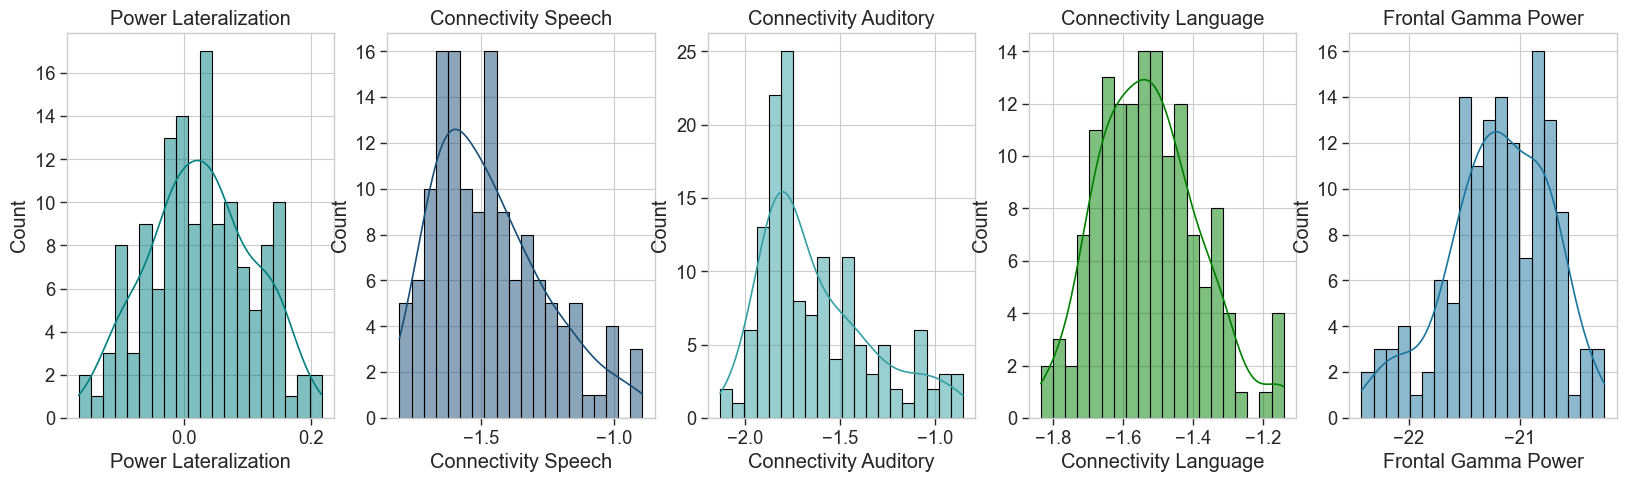

In [32]:
# Plot both features and check if they are normally distributed

# Do subplots 

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
if shapiro(plotting_df["Power Lateralization"])[1] < 0.05:
    print("Power Lateralization is not normally distributed", shapiro(plotting_df["Power Lateralization"])[1])

if shapiro(plotting_df["Connectivity Speech"])[1] < 0.05:
    print("Connectivity Speech is not normally distributed", shapiro(plotting_df["Connectivity Speech"])[1])

if shapiro(plotting_df["Connectivity Auditory"])[1] < 0.05:
    print("Connectivity Auditory is not normally distributed", shapiro(plotting_df["Connectivity Auditory"])[1])

if shapiro(plotting_df["Connectivity Language"])[1] < 0.05:
    print("Connectivity Language is not normally distributed", shapiro(plotting_df["Connectivity Language"])[1])

if shapiro(plotting_df["Frontal Gamma Power"])[1] < 0.05:
    print("Frontal Gamma Power is not normally distributed", shapiro(plotting_df["Frontal Gamma Power"])[1])

# make sure to use Blue-Green spectrum for the histogram
sns.histplot(plotting_df["Power Lateralization"], kde=True, ax=axs[0], bins=20, color="teal")
sns.histplot(plotting_df["Connectivity Speech"], kde=True, ax=axs[1], bins=20, color= cluster_colors["A"])
sns.histplot(plotting_df["Connectivity Auditory"], kde=True, ax=axs[2], bins=20, color=cluster_colors["C"])
sns.histplot(plotting_df["Connectivity Language"], kde=True, ax=axs[3], bins=20, color="green")
sns.histplot(plotting_df["Frontal Gamma Power"], kde=True, ax=axs[4], bins=20, color=cluster_colors["B"])

# Add title and labels

axs[0].set_title("Power Lateralization")
axs[1].set_title("Connectivity Speech")
axs[2].set_title("Connectivity Auditory")
axs[3].set_title("Connectivity Language")
axs[4].set_title("Frontal Gamma Power")

# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/eeg_features_individual_histograms_{date}.png", dpi=300, bbox_inches='tight')


### Plot the distribution of the classes


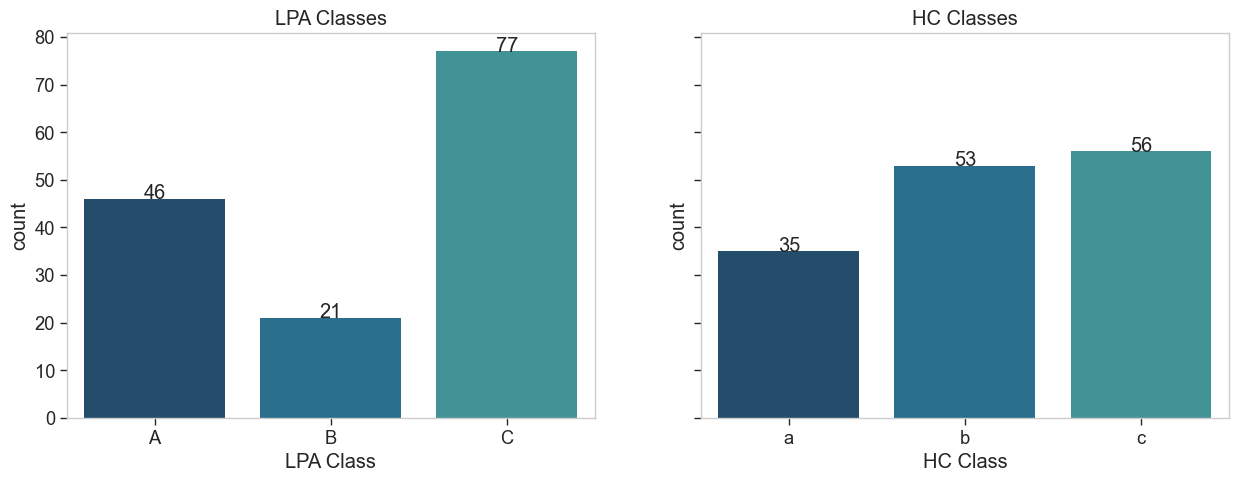

In [33]:
# Make sure they share the same y-axis
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(data=plotting_df, x="LPA Class", ax=ax[0], palette=palette)
ax[0].set_title("LPA Classes")

# Add counts to the bars in the plot
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    # Remove grid lines
    ax[0].grid(False)

sns.countplot(data=plotting_df, x="HC Class", ax=ax[1], palette=palette)
ax[1].set_title("HC Classes")

# Add counts to the bars in the plot
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    # Remove grid lines
    ax[1].grid(False)



# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/LPA_HC_classes_size_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


## **3D Plotting** classes using UMAP, PCA or t-SNE

In [34]:
# Load the data
dim_reduction_df = pd.read_csv(f"../../Datasets/hierarchical/source/{date}/combined/MICE/5Dcombined_data_{date}.csv")

# Keep only the eeg variables
dim_reduction_df = dim_reduction_df[eeg_vars]

# Normalize the data
dim_reduction_df = (dim_reduction_df - dim_reduction_df.mean()) / dim_reduction_df.std()
dim_reduction_df


auditory_con_6  lang_comp_con_6  speech_con_6_left  front_gamma_6  \
0          0.091716         2.573154           1.139389      -0.493375   
1         -0.708993         0.071701          -0.933383       0.262605   
2         -0.690122        -0.656346          -0.002112      -2.062992   
3          0.677772        -0.537582          -1.397818      -0.950743   
4         -0.487253        -0.432078           0.150907      -0.858837   
..              ...              ...                ...            ...   
139       -0.568656        -0.544815          -0.280481       0.596665   
140        1.918149         1.694759          -0.298238      -0.587502   
141       -0.477100        -1.239995          -1.318751       0.189308   
142        0.467966         1.187249           2.211642       0.006792   
143        2.061507         0.806124          -0.713670       0.007357   

     gamma_lat_6  
0       0.022771  
1       0.167193  
2      -0.541724  
3      -2.383233  
4      -1.682449  
..           ...  
139     0.195884  
140    -1.552500  
141    -0.063540  
142    -1.441595  
143    -1.970557  

[144 rows x 5 columns]

In [35]:
# Set seed for reproducibility
np.random.seed(333)

### Feature reduction using UMAP

In [36]:
embedded_umap_2 = umap.UMAP(n_components=2, random_state=0).fit_transform(dim_reduction_df.values)
embedded_umap_3 = umap.UMAP(n_components=3, random_state=0).fit_transform(dim_reduction_df.values)

c:\Users\gabot\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\gabot\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [37]:
# Save the UMAP data
umap_df_2d = pd.DataFrame(embedded_umap_2, columns=["umap1", "umap2"], index=dim_reduction_df.index)
umap_df_3d = pd.DataFrame(embedded_umap_3, columns=["umap1", "umap2","umap3"], index=dim_reduction_df.index)

#### **2D UMAP**

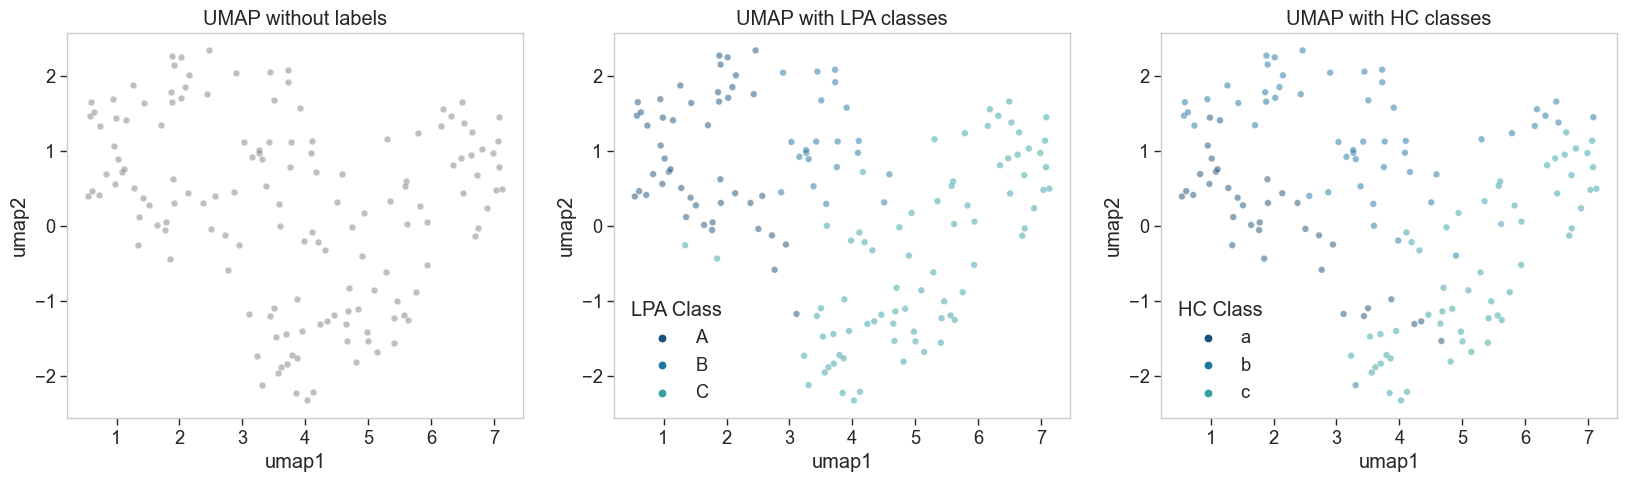

In [38]:
# Create 3 subplots, one for the umpa no labels, one for the LPA classes and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot UMAP without labels
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("UMAP without labels")
# remove grid lines
axs[0].grid(False)
# Plot UMAP with LPA classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("UMAP with LPA classes")
# remove grid lines
axs[1].grid(False)

# Plot UMAP with HC classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["HC Class"], ax=axs[2], palette=palette, alpha=0.5)
axs[2].set_title("UMAP with HC classes")
# remove grid lines
axs[2].grid(False)
# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/umap_2d_{date}.png", dpi=300, bbox_inches='tight')

#### **3D UMAP**

In [39]:
# Create subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, 
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("UMAP without labels", "UMAP with LPA classes", "UMAP with HC classes"))

# 1. UMAP without labels
fig1 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# 2. UMAP with LPA classes
fig2 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# 3. UMAP with HC classes
fig3 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    color=plotting_df["HC Class"], opacity=0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)

# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)

# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)

fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)

fig.show()

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
#fig.write_image(f"../../Figures/Supplementary/{date}/umap_3d_{date}.png", width=1800, height=600, scale=2)


### Feature reduction using PCA

In [40]:
# Apply PCA to the data
pca = PCA(n_components=5)
p_components = pca.fit_transform(dim_reduction_df.values)
pca_df = pd.DataFrame(data = p_components)

pca_df

0         1         2         3         4
0    2.362948  1.157592 -0.601880 -0.125904 -0.932750
1   -0.672342 -0.398435 -0.213567 -0.092438 -0.900546
2   -1.045854  1.384367 -1.288993  0.634870  0.617752
3   -1.818574  2.125207  1.124926 -0.441508  0.043333
4   -0.878137  1.426024 -0.442623 -0.820725  0.583902
..        ...       ...       ...       ...       ...
139 -0.557246 -0.808633 -0.149414 -0.320160 -0.063285
140  0.947979  2.301764  1.685957 -0.058514 -0.594314
141 -1.775949 -0.576516  0.170447  0.071334 -0.153893
142  1.947458  1.398575 -0.069216 -1.413253  0.920587
143  0.117584  1.916309  2.306643 -0.471415 -0.251435

[144 rows x 5 columns]

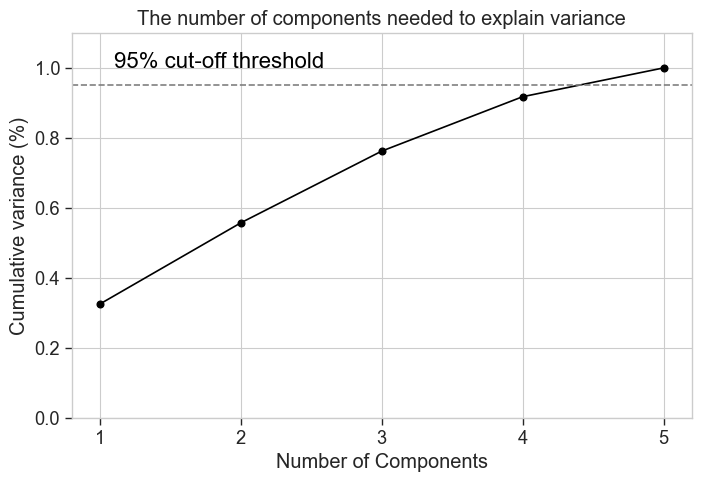

In [40]:
# Plot the variance 
plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y) + 1, step=1)  # Adjust xi to match the length of y

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 6, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)


# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")

plt.savefig(f"../../Figures/Supplementary/{date}/pca_variance_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


#### **2D PCA Mapping**

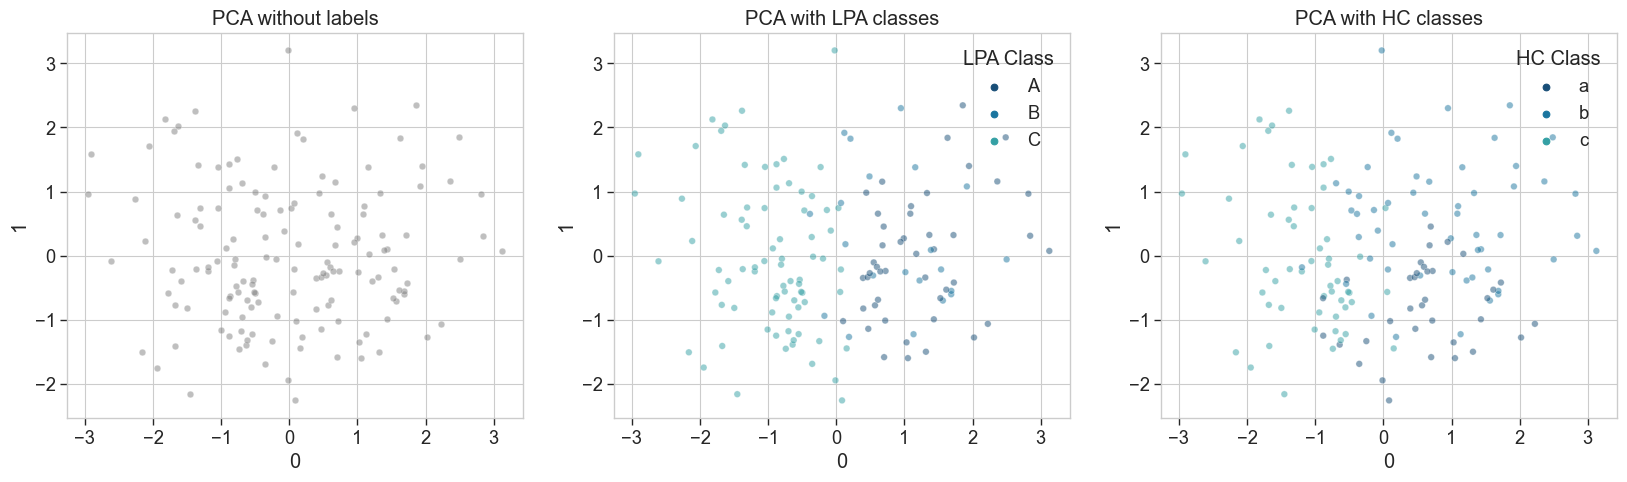

In [41]:
# Create 3 subplots, one for the pca no labels, one for the LPA classes and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot PCA without labels
sns.scatterplot(data=pca_df, x=0, y=1, ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("PCA without labels")
# Plot PCA with LPA classes
sns.scatterplot(data=pca_df, x=0, y=1, hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("PCA with LPA classes")
# Plot PCA with HC classes
sns.scatterplot(data=pca_df, x=0, y=1, hue=plotting_df["HC Class"], ax=axs[2
], palette=palette, alpha=0.5)
axs[2].set_title("PCA with HC classes")
# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/pca_2d_{date}.png", dpi=300, bbox_inches='tight')



#### **3D PCA**

In [42]:
# Create subplots with 1 row and 3 columns for 3D PCA

fig = make_subplots(rows=1, cols=3,
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("PCA without labels", "PCA with LPA classes", "PCA with HC classes"))
# 1. PCA without labels
fig1 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
# 2. PCA with LPA classes
fig2 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
# 3. PCA with HC classes
fig3 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    color=plotting_df["HC Class"], opacity=
0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)
# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)
# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)
fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)
fig.show()


### Feature reduction using t-SNE

In [43]:
# t-SNE 2D
tsne_2d = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_components_2d = tsne_2d.fit_transform(dim_reduction_df.values)
tsne_df_2d = pd.DataFrame(data = tsne_components_2d, columns = ['t-SNE1', 't-SNE2'])


# t-SNE 3D
tsne_3d = TSNE(n_components=3, random_state=0, perplexity=30, n_iter=1000)
tsne_components_3d = tsne_3d.fit_transform(dim_reduction_df.values)
tsne_df_3d = pd.DataFrame(data = tsne_components_3d, columns = ['t-SNE1', 't-SNE2', 't-SNE3'])

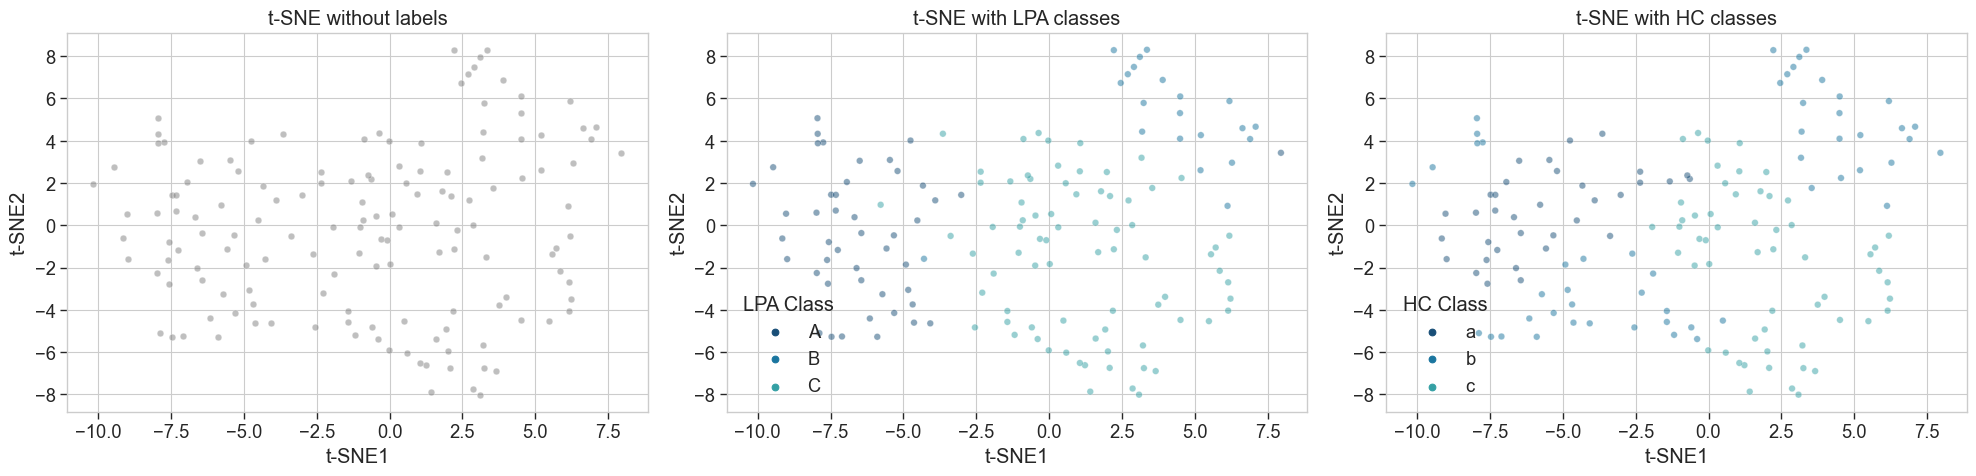

In [44]:
# Create 3 subplots, one for the t-SNE without labels, one for the LPA classes, and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot t-SNE without labels
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("t-SNE without labels")

# Plot t-SNE with LPA classes
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("t-SNE with LPA classes")

# Plot t-SNE with HC classes
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", hue=plotting_df["HC Class"], ax=axs[2], palette=palette, alpha=0.5)
axs[2].set_title("t-SNE with HC classes")

# Adjust the layout
plt.tight_layout()

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
plt.savefig(f"../../Figures/Supplementary/{date}/tsne_2d_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


In [45]:
# Create subplots with 1 row and 3 columns for 3D t-SNE
fig = make_subplots(rows=1, cols=3,
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("t-SNE without labels", "t-SNE with LPA classes", "t-SNE with HC classes"))

# 1. t-SNE without labels
fig1 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# 2. t-SNE with LPA classes
fig2 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# 3. t-SNE with HC classes
fig3 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    color=plotting_df["HC Class"], opacity=0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)

# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)

# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)

fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)

fig.show()



In [41]:
# Add umap data to the plotting_df
plotting_df["umap1"] = umap_df_2d["umap1"]
plotting_df["umap2"] = umap_df_2d["umap2"]

In [42]:
plotting_df.columns

Index(['subject', 'HC Class', 'ASD Likelihood', 'ASD Diagnosis', 'Sex', 'Site',
       'Frontal Gamma Power', 'Connectivity Auditory', 'Connectivity Language',
       'Connectivity Speech', 'Power Lateralization', 'LPA Class',
       'prob_class_1', 'prob_class_2', 'prob_class_3',
       'Receptive MSEL 6 months', 'Expressive MSEL 6 months',
       'Receptive MSEL 12 months', 'Expressive MSEL 12 months',
       'Receptive MSEL 18 months', 'Expressive MSEL 18 months',
       'Receptive MSEL 24 months', 'Expressive MSEL 24 months',
       'Receptive MSEL 36 months', 'Expressive MSEL 36 months', 'NVIQ',
       'umap1', 'umap2'],
      dtype='object')

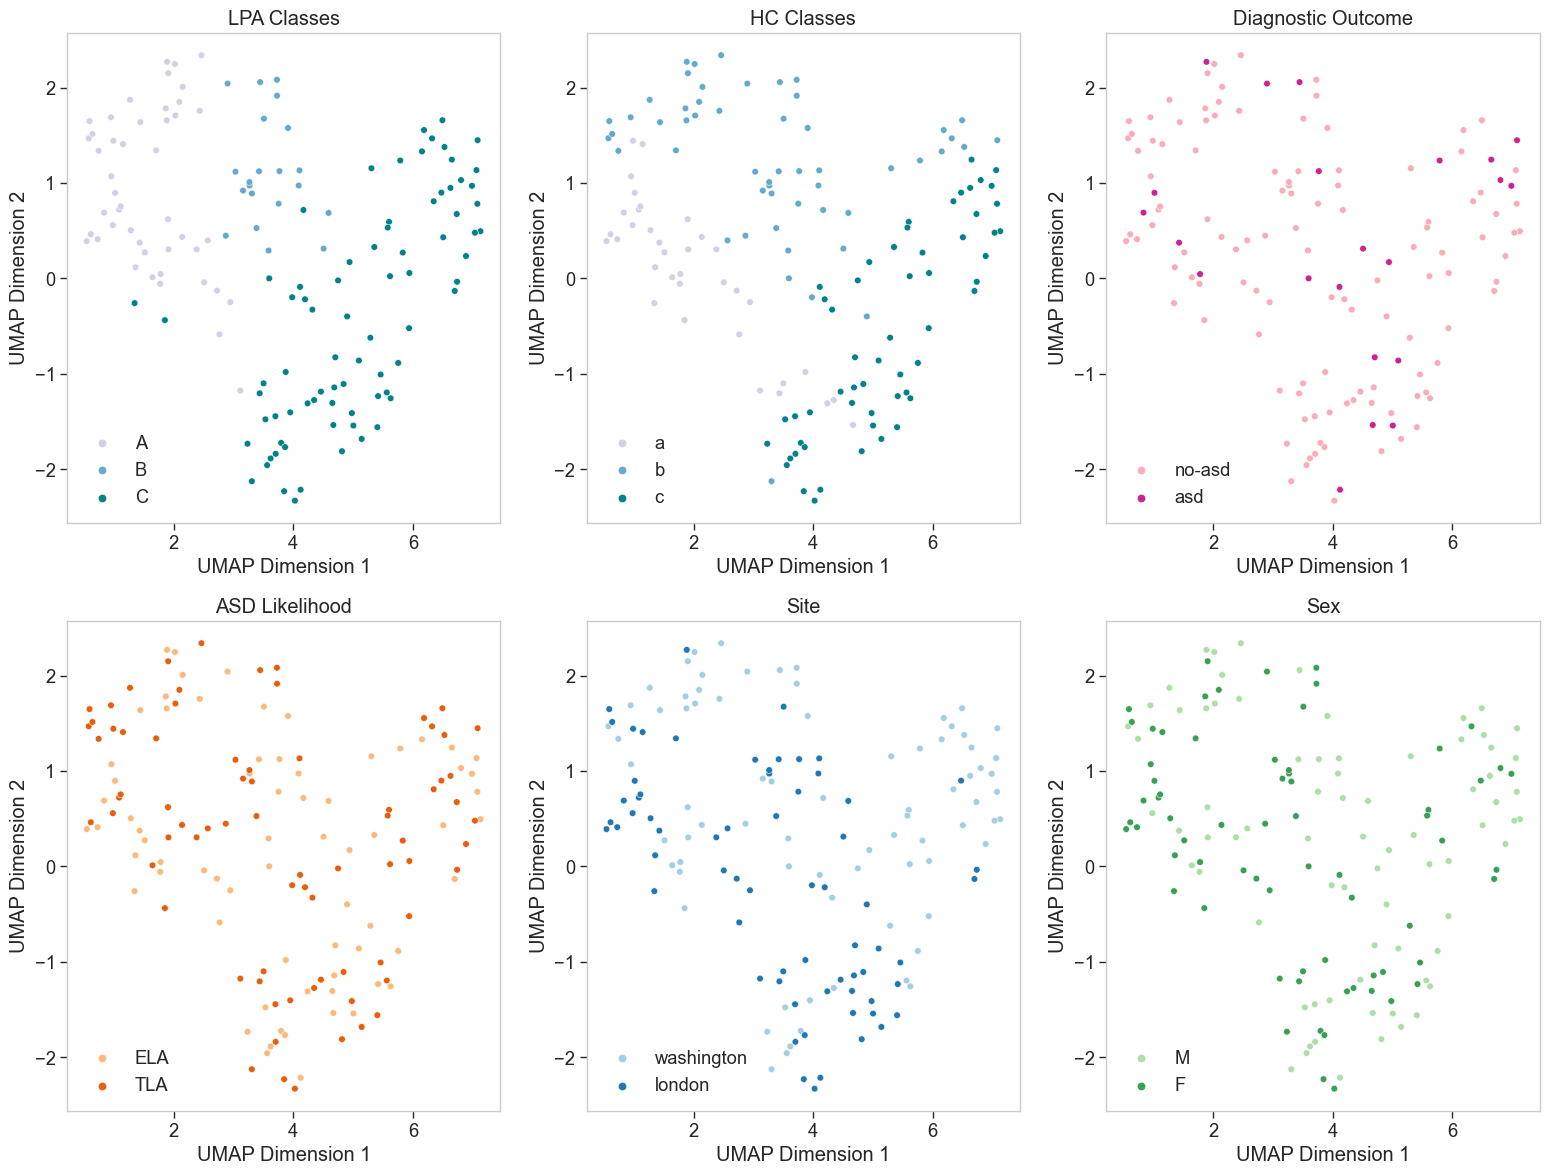

In [43]:
# Plot 2D scatterplot of the classes using UMAP

fig, ax = plt.subplots(2, 3, figsize=(19, 14))  # Adjusted figsize for better visualization
ax = ax.flatten()  # Flatten the 2D array of axes into a 1D array


# Plot the distribution of the LPA classes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="LPA Class", ax=ax[0], palette="PuBuGn")
ax[0].get_legend().remove()
ax[0].legend(loc='lower left')
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("UMAP Dimension 2")
ax[0].set_xlabel("UMAP Dimension 1")

# Plot the distribution of the HC classes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="HC Class", ax=ax[1], palette="PuBuGn", legend="full")
ax[1].get_legend().remove()
ax[1].legend(loc='lower left')
ax[1].set_title("HC Classes")
ax[1].set_ylabel("UMAP Dimension 2")
ax[1].set_xlabel("UMAP Dimension 1")

# Plot the distribution of outcomes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="ASD Diagnosis", ax=ax[2], palette="RdPu")
ax[2].legend(loc='lower left')
ax[2].set_title("Diagnostic Outcome")
ax[2].set_ylabel("UMAP Dimension 2")
ax[2].set_xlabel("UMAP Dimension 1")

# Plot the distribution of group types
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="ASD Likelihood", ax=ax[3], palette="Oranges")
ax[3].legend(loc='lower left')
ax[3].set_title("ASD Likelihood")
ax[3].set_ylabel("UMAP Dimension 2")
ax[3].set_xlabel("UMAP Dimension 1")

# Plot the distribution of sites
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="Site", ax=ax[4], palette="Paired")
ax[4].legend(loc='lower left')
ax[4].set_title("Site")
ax[4].set_ylabel("UMAP Dimension 2")
ax[4].set_xlabel("UMAP Dimension 1")

# Plot the distribution of sex
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="Sex", ax=ax[5], palette="Greens")
ax[5].legend(loc='lower left')
ax[5].set_title("Sex")
ax[5].set_ylabel("UMAP Dimension 2")
ax[5].set_xlabel("UMAP Dimension 1")

# Remove the grids lines
for a in ax:
    a.grid(False)

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
plt.savefig(f"../../Figures/Supplementary/{date}/demographics_UMAP_{date}.png", dpi=300, bbox_inches='tight')

plt.show()


### Demographics table

In [44]:
# Create tables for HC Class and LPA Class
hc_table = create_descriptive_table(plotting_df, 'HC Class', clean_eeg_vars)
lpa_table = create_descriptive_table(plotting_df, 'LPA Class', clean_eeg_vars)

# Combine the tables
combined_table = pd.concat([hc_table, lpa_table], ignore_index=True)
# Save the combined table
combined_table.to_csv(f"../../Tables/Main/{date}/mean_eeg_features_descriptive_stats_{date}.csv", index=False)
combined_table

PermissionError: [Errno 13] Permission denied: '../../Tables/Main/2025_04_23/mean_eeg_features_descriptive_stats_2025_04_23.csv'

### **Lateralization** Check if laterlization is significant from 0

In [ ]:
# Do this for LPA 

# Add results to a lateralization table
lateralization_table = list()

for group in plotting_df["LPA Class"].unique():
    group_data = plotting_df[plotting_df["LPA Class"] == group]["Power Lateralization"]
    # Drop NaN values
    group_data = group_data.dropna()
    # Perform one-sample t-test
    t_stat, p_value = stats.ttest_1samp(group_data, 0)

    # Calculate mean and standard deviation
    mean_value = group_data.mean()
    std_value = group_data.std()

    # Check if significantly lateralized 
    if p_value < 0.05:
        print(f"***Group {group} is significantly different from 0 (p < 0.05), t-statistic: {t_stat}, p-value: {p_value.round(4)}")
        significant_lateralization = "Yes"

    else:
        print(f"Group {group} is not significantly different from 0 (p >= 0.05)")
        significant_lateralization = "No"

    # Append results to the table
    lateralization_table.append({
        "Class": "LPA Class",
        "Group": group,
        "Mean Power Lateralization": mean_value,
        "Standard Deviation": std_value,
        "t-statistic": t_stat,
        "p-value": p_value, 
        "Significant Lateralization": significant_lateralization
    })



***Group A is significantly different from 0 (p < 0.05), t-statistic: 4.834751733354755, p-value: 0.0
Group C is not significantly different from 0 (p >= 0.05)
Group B is not significantly different from 0 (p >= 0.05)


In [ ]:
# Do this for HC Class
for group in plotting_df["HC Class"].unique():
    group_data = plotting_df[plotting_df["HC Class"] == group]["Power Lateralization"]
    # Drop NaN values
    group_data = group_data.dropna()
    # Perform one-sample t-test
    t_stat, p_value = stats.ttest_1samp(group_data, 0)

    # Calculate mean and standard deviation
    mean_value = group_data.mean()
    std_value = group_data.std()

    if p_value < 0.05:
        print(f"***Group {group} is significantly different from 0 (p < 0.05), t-statistic: {t_stat}, p-value: {p_value.round(4)}")
        significant_lateralization = "Yes"
    else:
        print(f"Group {group} is not significantly different from 0 (p >= 0.05)")
        significant_lateralization = "No"

    # Append results to the table
    lateralization_table.append({
        "Class": "HC Class",
        "Group": group,
        "Mean Power Lateralization": mean_value,
        "Standard Deviation": std_value,
        "t-statistic": t_stat,
        "p-value": p_value, 
        "Significant Lateralization": significant_lateralization
    })



Group b is not significantly different from 0 (p >= 0.05)
Group c is not significantly different from 0 (p >= 0.05)
***Group a is significantly different from 0 (p < 0.05), t-statistic: 6.619786629429643, p-value: 0.0


In [ ]:
# Create a DataFrame from the lateralization table and save to tables 
lateralization_df = pd.DataFrame(lateralization_table)
# Round to 3 decimal places
lateralization_df=lateralization_df.round(3)

lateralization_df.to_csv(f"../../Tables/Supplementary/{date}/lateralization_table_{date}.csv", index=False)
lateralization_df

PermissionError: [Errno 13] Permission denied: '../../Tables/Supplementary/2025_04_23/lateralization_table_2025_04_23.csv'

### **Demographics Chi-tests**

In [ ]:

# Function to generate  figures
def create_demographic_plots(df, stratification_methods, demographic_vars, filename=None):
    """
    Creates publication-ready plots for demographic variables
    """
    # Set up figure
    n_methods = len(stratification_methods)
    n_demos = len(demographic_vars)
    
    # Set up a nice color palette
    colors = sns.color_palette("Paired", max(3, max([len(df[demo].unique()) for demo in demographic_vars])))
    
    # Create figure with two rows (one for each method) and columns for each demographic
    fig, axes = plt.subplots(n_methods, n_demos, figsize=(4*n_demos, 5*n_methods))
    
    # If there's only one demo variable, wrap axes in a list
    if n_demos == 1:
        axes = np.array([axes]).reshape(n_methods, 1)
    
    for i, method in enumerate(stratification_methods):
        for j, demo in enumerate(demographic_vars):
            ax = axes[i, j]
            
            # Get chi-square results
            chi_result = perform_chi_square(df, method, demo)
            
            # Create the plot
            if demo == "NVIQ":  # Continuous variable handling
                sns.boxplot(x=method, y=demo, data=df, palette=colors[:len(df[method].unique())], ax=ax)
                # For IQ, we'd use ANOVA instead of chi-square
                # Perform ANOVA and get F-statistic and p-value


                #f_stat, p_val = sm.stats.anova_lm(sm.formula.ols(f"{demo} ~ C('{method}')", data=df).fit())['F'][0], sm.formula.anova_lm(sm.formula.ols(f"{demo} ~ C('{method}')", data=df).fit())['PR(>F)'][0]
                #ax.set_title(f"{demo} by {method}\nF={f_stat:.2f}, p={p_val:.3f}")
            else:
                # For categorical variables, normalize within each class
                # and create stacked percentage bars
                prop_data = pd.crosstab(df[method], df[demo], normalize='index')
                prop_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(df[demo].unique())])
                
                # Add chi-square result to title
                ax.set_title(f"{demo} by {method}\nχ²={chi_result['chi2']:.2f}, p={chi_result['p']:.3f}")
                
                # Add percentage labels to bars
                for container in ax.containers:
                    ax.bar_label(container, label_type='center', fmt='%.2f', fontsize=8)
                
                # Adjust y-axis to make room for labels
                ax.set_ylim(0, 1.1)
            
            # Formatting
            ax.set_xlabel(method)
            if j == 0:  # Only show y-label for first column
                ax.set_ylabel("Percentage" if demo != "NVIQ" else "IQ")
            else:
                ax.set_ylabel("")
            ax.legend(ncol=min(3, len(df[demo].unique())),  # Max 3 columns
                bbox_to_anchor=(0.5, -0.2),  # Below plot
                loc='upper center',
            frameon=False)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return fig


# Generate tables as DataFrames
def format_table_for_publication(demo_tables):
    """
    Format demographic results into publication-ready tables
    """
    publication_tables = {}
    
    for method, method_data in demo_tables.items():
        # Create a list to store rows
        rows = []
        
        for demo, demo_data in method_data.items():
            # Add header row for demographic variable
            rows.append({
                'Variable': f"**{demo}**",
                'Statistics': '',
                'Chi-square': '',
                'p-value': '',
                "Cramer's V": ''
            })
            
            # Add data rows
            counts = demo_data['counts']
            percentages = demo_data['percentages']
            
            for category in counts.columns:
                row_data = {
                    'Variable': f"  {category}",
                    'Statistics': 'n (%)',
                }
                
                # Add counts and percentages for each class
                for cls in counts.index:
                    count = counts.loc[cls, category]
                    percent = percentages.loc[cls, category]
                    row_data[f'Class {cls[-1] if cls in hc_order else cls}'] = f"{count} ({percent:.1f}%)"
                
                # Add chi-square info only for first category row
                if category == counts.columns[0]:
                    row_data['Chi-square'] = f"{demo_data['chi2']:.2f}"
                    row_data['p-value'] = f"{demo_data['p']:.3f}"
                    row_data["Cramer's V"] = f"{demo_data['cramers_v']:.3f}"
                
                rows.append(row_data)
        
        # Convert to DataFrame
        publication_tables[method] = pd.DataFrame(rows)
    
    return publication_tables


In [45]:
# Define orders for consistent presentation
hc_order = ["a", "b", "c"]
lpa_order = ["A", "B", "C"]

# Perform the analysis
stratification_methods = ['LPA Class','HC Class']
demographic_vars = ['ASD Diagnosis', 'ASD Likelihood', 'Sex', 'Site']

# Create the demographic table
demo_tables = create_demographic_table(plotting_df, stratification_methods, demographic_vars)

# Create the demographic plots
fig = create_demographic_plots(plotting_df, stratification_methods, demographic_vars,
                                f"../../Figures/Supplementary/{date}/hc_lpa_demographics_comparison_{date}.png")

# Create publication tables
pub_tables = format_table_for_publication(demo_tables)

# Display tables
for method, table in pub_tables.items():
    print(f"\nTable for {method}:")
    print(table.to_string(index=False))

# Save tables to CSV
for method, table in pub_tables.items():
    table.to_csv(f"../../Tables/Main/{date}/eeg_features_{method.replace(' ', '_')}_demographics.csv", index=False)


NameError: name 'create_demographic_plots' is not defined

### **Sankey Plot**

In [47]:
# Create a contingency table
contingency_table = pd.crosstab(plotting_df["LPA Class"], plotting_df["HC Class"])
# Perform the Chi-squared test
print(contingency_table)

HC Class    a   b   c
LPA Class            
A          27  19   0
B           0  21   0
C           8  13  56


In [48]:
# Calculate overlap
overlap = contingency_table.values.diagonal().sum()
total_samples = contingency_table.values.sum()
degree_of_overlap = overlap / total_samples
print("Degree of Overlap:", degree_of_overlap)


Degree of Overlap: 0.7222222222222222


In [49]:
# Prepare data for the Sankey diagram
source = []
target = []
values = []

# Get the number of clusters in hc_class and lpa_class
hc_labels = list(contingency_table.index)
lpa_labels = list(contingency_table.columns)

for hc_index, hc_cluster in enumerate(hc_labels):
    for lpa_index, lpa_cluster in enumerate(lpa_labels):
        count = contingency_table.loc[hc_cluster, lpa_cluster]
        if count > 0:
            source.append(hc_index)  # Use index for HC clusters
            target.append(lpa_index + len(hc_labels))  # Offset LPA clusters by the number of HC clusters
            values.append(count)

# Calculate degree of overlap (Jaccard similarity)
total_samples = contingency_table.sum().sum()
overlap_text = f"Degree of overlap: {total_samples} total samples | {len(source)} connections"

# Create the Sankey diagram with compact settings
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=5,  # Reduced from 15
        thickness=20,  # Reduced from 40
        line=dict(color="black", width=0.3),  # Thinner border
        color=[cluster_colors[hc_labels[i]] for i in range(len(hc_labels))] + 
              [cluster_colors[lpa_labels[j]] for j in range(len(lpa_labels))],
        label=[f'LPA {i}' for i in hc_labels] + 
              [f'HC {j}' for j in lpa_labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

# Compact layout settings
fig.update_layout(
   title_text="Sankey Diagram of Overlap",
    font_size=20,  # Smaller font
    width=600,  # Reduced from 1000
    height=400,  # Reduced from 500
    margin=dict(l=20, r=20, t=60, b=40),  # Tight margins
    hovermode=False,  # Disable hover to reduce whitespace
    autosize=True
)

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")

fig.write_html(
    f"../../Figures/Supplementary/{date}/sankey_diagram_{date}.html",
    include_plotlyjs='cdn',
    config={'displayModeBar': False}  # Hide the plotly toolbar
)

# Save a a figure 
#fig.write_image(f"../../Figures/Supplementary/{date}/sankey_diagram_{date}.png", width=600, height=400, scale=2)

fig.show()



## **Language profiles**

### Expressive

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\881863961.py:10: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\881863961.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



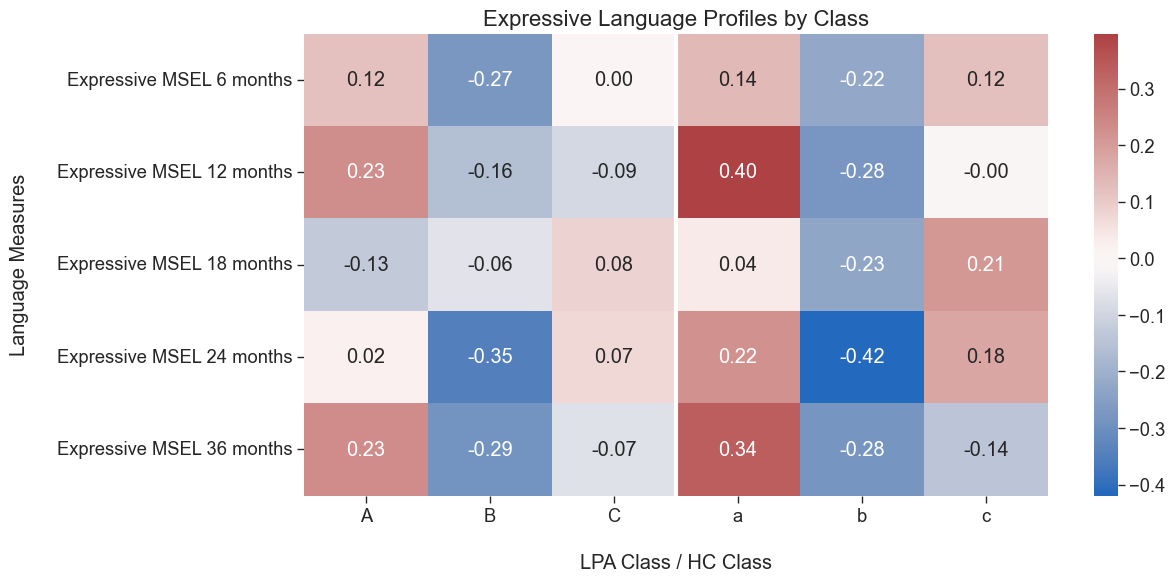

In [71]:
cleaned_expres_vars = [var for var in cleaned_language_vars if "expressive" in var.lower() ]

measures= cleaned_expres_vars
var_interest = "Expressive"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap="vlag", center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Language Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=["HC High Avg", "HC Low Avg 1", "LPA High Avg", "LPA Low Avg"], rotation=25)

plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("Language Measures",labelpad=20)

# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_language_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


## Receptive

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1701921448.py:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1701921448.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



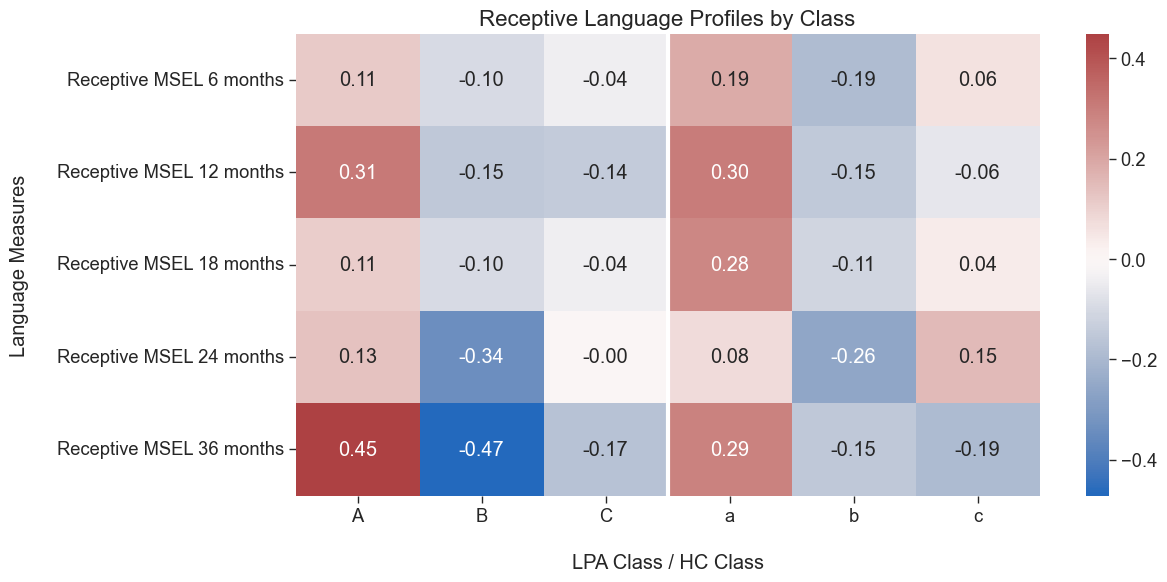

In [72]:
### Expressive
cleaned_receptive_vars = [var for var in cleaned_language_vars if "receptive" in var.lower() ]

measures= cleaned_receptive_vars
var_interest = "Receptive"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap="vlag", center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Language Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("Language Measures",labelpad=20)
 
# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_language_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


### EEG Profiles

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\2390912523.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\2390912523.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



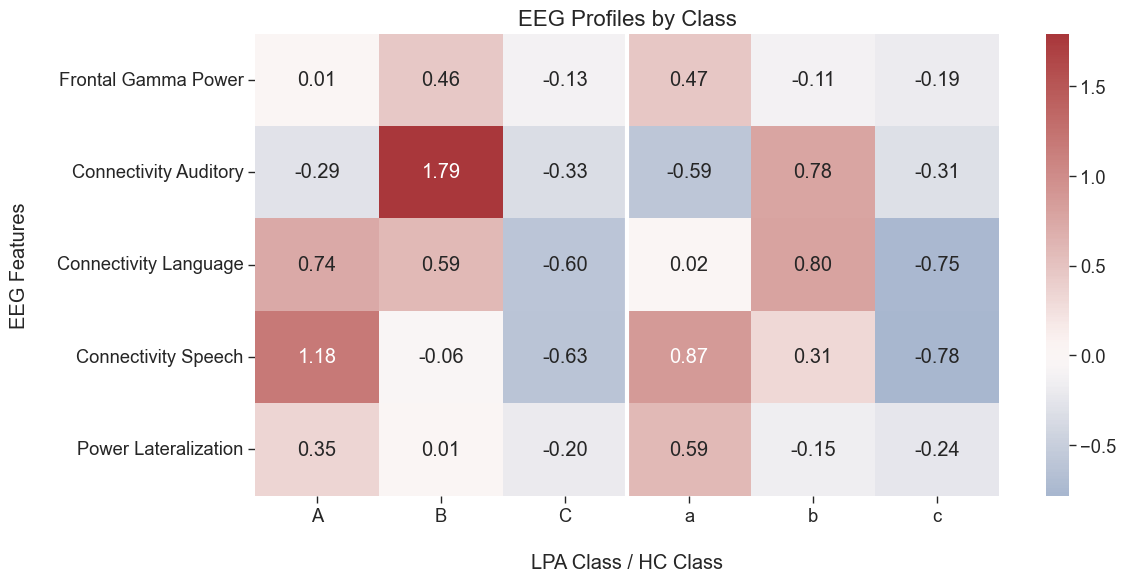

In [73]:

measures= clean_eeg_vars
var_interest = "EEG"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap= "vlag",  # Use a diverging color palette
           #cmap="RdBu_r",  # Use a diverging color palette
             center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("EEG Features",labelpad=20)

# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()

## **Language growth curves**

In [74]:
## Create wide long format for langauge measures

lang_wide=plotting_df.copy()

expressive_df= lang_wide[["HC Class"] + ["LPA Class"] + ["subject"] + cleaned_expres_vars]
receptive_df= lang_wide[["HC Class"] + ["LPA Class"] + ["subject"]+ cleaned_receptive_vars]



# Rename the timepoints
expressive_df = expressive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
expressive_df["Age"] = expressive_df["Age"].str.extract("(\d+)").astype(int)
expressive_df["Measure"] = "Expressive"

# Rename the timepoints
receptive_df = receptive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
receptive_df["Age"] = receptive_df["Age"].str.extract("(\d+)").astype(int)
receptive_df["Measure"] = "Receptive"


In [75]:
expressive_df.head()

HC Class LPA Class  subject  Age  score     Measure
0        b         A        2    6    5.0  Expressive
1        c         C        3    6    7.0  Expressive
2        c         C        5    6    5.0  Expressive
3        c         C        6    6    4.0  Expressive
4        c         C        8    6    5.0  Expressive

In [76]:
ages = [6, 12, 18, 24, 36]

In [77]:
# Using colorblind-friendly palettes



In [78]:
cluster_colors

{'A': '#184e77',
 'B': '#1a759f',
 'C': '#34a0a4',
 'a': '#184e77',
 'b': '#1a759f',
 'c': '#34a0a4'}

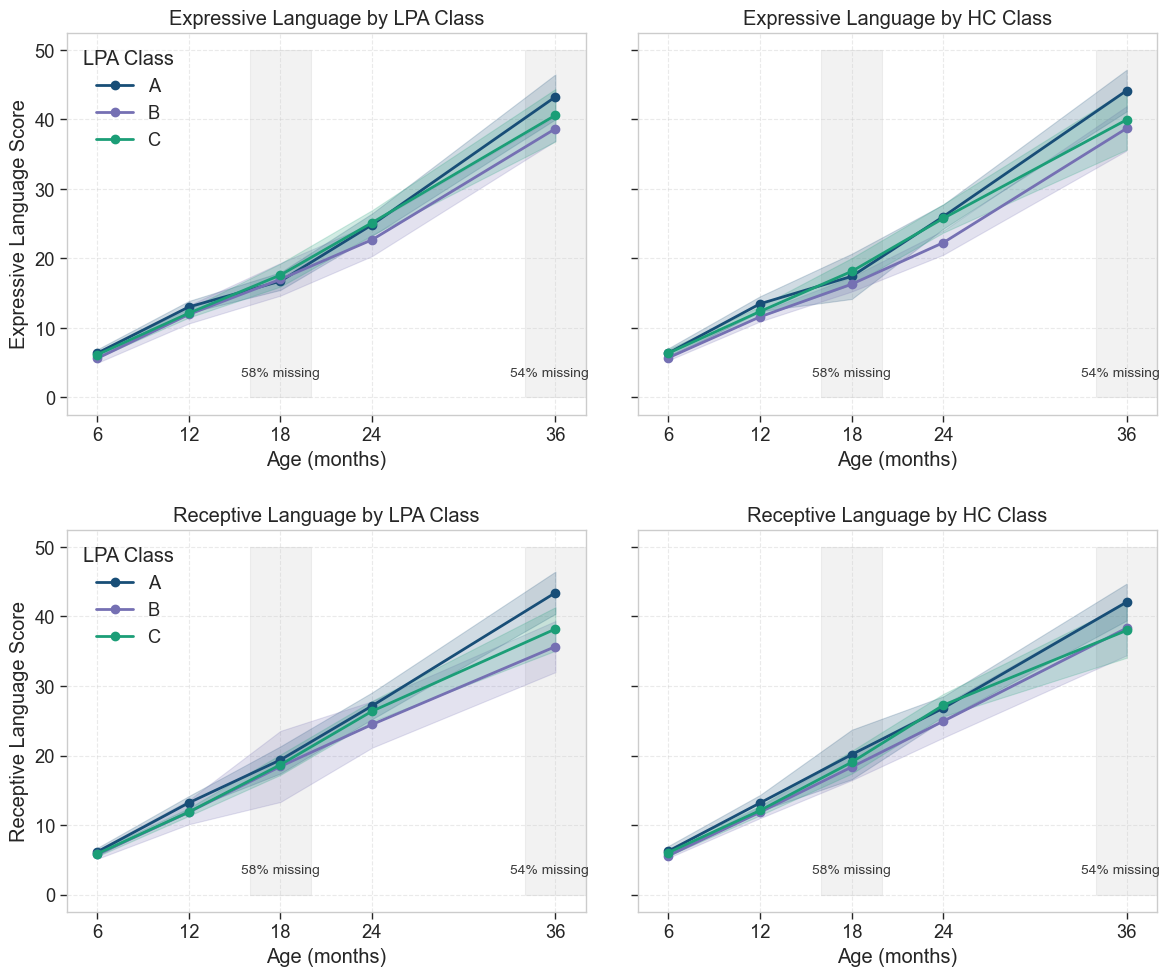

In [80]:
# Use cluster_colors as palette for LPA and HC classes
lpa_palette = {key: cluster_colors[key] for key in cluster_colors.keys()}
hc_palette = {key: cluster_colors[key] for key in cluster_colors.keys()}


lpa_palette = {"A": "#184e77", "B": "#7570b3", "C": "#1b9e77"}
hc_palette = {"a": "#184e77", "b": "#7570b3", "c": "#1b9e77"}

# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey='row', sharex=False)

# Plot titles
titles = [
    "Expressive Language by LPA Class", 
    "Expressive Language by HC Class",
    "Receptive Language by LPA Class", 
    "Receptive Language by HC Class"
]

# Data and class combinations to plot
plot_data = [
    (expressive_df, "LPA Class", lpa_palette),
    (expressive_df, "HC Class", hc_palette),
    (receptive_df, "LPA Class", lpa_palette),
    (receptive_df, "HC Class", hc_palette)
]

# Create all 4 plots
for i, (data, class_col, palette) in enumerate(plot_data):
    ax = axs[i//2, i%2]
    
    # Calculate means and confidence intervals for each class and age
    grouped = data.groupby([class_col, 'Age'])['score'].agg(['mean', 'sem']).reset_index()
    grouped['ci_low'] = grouped['mean'] - 1.96 * grouped['sem']
    grouped['ci_high'] = grouped['mean'] + 1.96 * grouped['sem']
    
    # Plot each class
    for class_name in sorted(data[class_col].unique()):
        group_data = grouped[grouped[class_col] == class_name]
        
        # Plot mean line
        ax.plot(group_data['Age'], group_data['mean'], 
                marker='o', markersize=6, 
                linewidth=2, label=class_name,
                color=palette[class_name])
        
        # Add confidence intervals
        ax.fill_between(group_data['Age'], 
                        group_data['ci_low'], 
                        group_data['ci_high'], 
                        alpha=0.2, color=palette[class_name])
    
    # Highlight regions with missing data
    missing_18 = Rectangle((16, 0), 4, 50, fill=True, alpha=0.1, color='gray', zorder=0)
    missing_36 = Rectangle((34, 0), 4, 50, fill=True, alpha=0.1, color='gray', zorder=0)
    ax.add_patch(missing_18)
    ax.add_patch(missing_36)
    
    # Add text indicating missing data percentage
    ax.text(18, 3, "58% missing", ha='center', fontsize=10, alpha=0.9)
    ax.text(35.6, 3, "54% missing", ha='center', fontsize=10, alpha=0.9)
    
    # Set title and labels
    ax.set_title(titles[i])
    ax.set_xlabel("Age (months)")
    
    # Set only left y-axis labels
    if i % 2 == 0:
        measure = "Expressive" if i < 2 else "Receptive"
        ax.set_ylabel(f"{measure} Language Score")

    # Configure axis
    ax.set_xlim(4, 38)
    ax.set_xticks(ages)
    
    # Add legend only for left panels
    if i % 2 == 0:
        ax.legend(title=class_col, loc='upper left')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.4)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)


# Add annotation about statistical significance (example)
#fig.text(0.5, 0.01, 
 #        "* All between-group differences significant at p<0.05 based on linear mixed effects models", 
  #       ha='center', fontsize=10, style='italic')

# Save figure in high resolution
plt.savefig(f"../../Figures/Main/language_trajectories_{date}.png", dpi=300, bbox_inches='tight')


# Show plot
plt.show()

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\4096612644.py:85: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



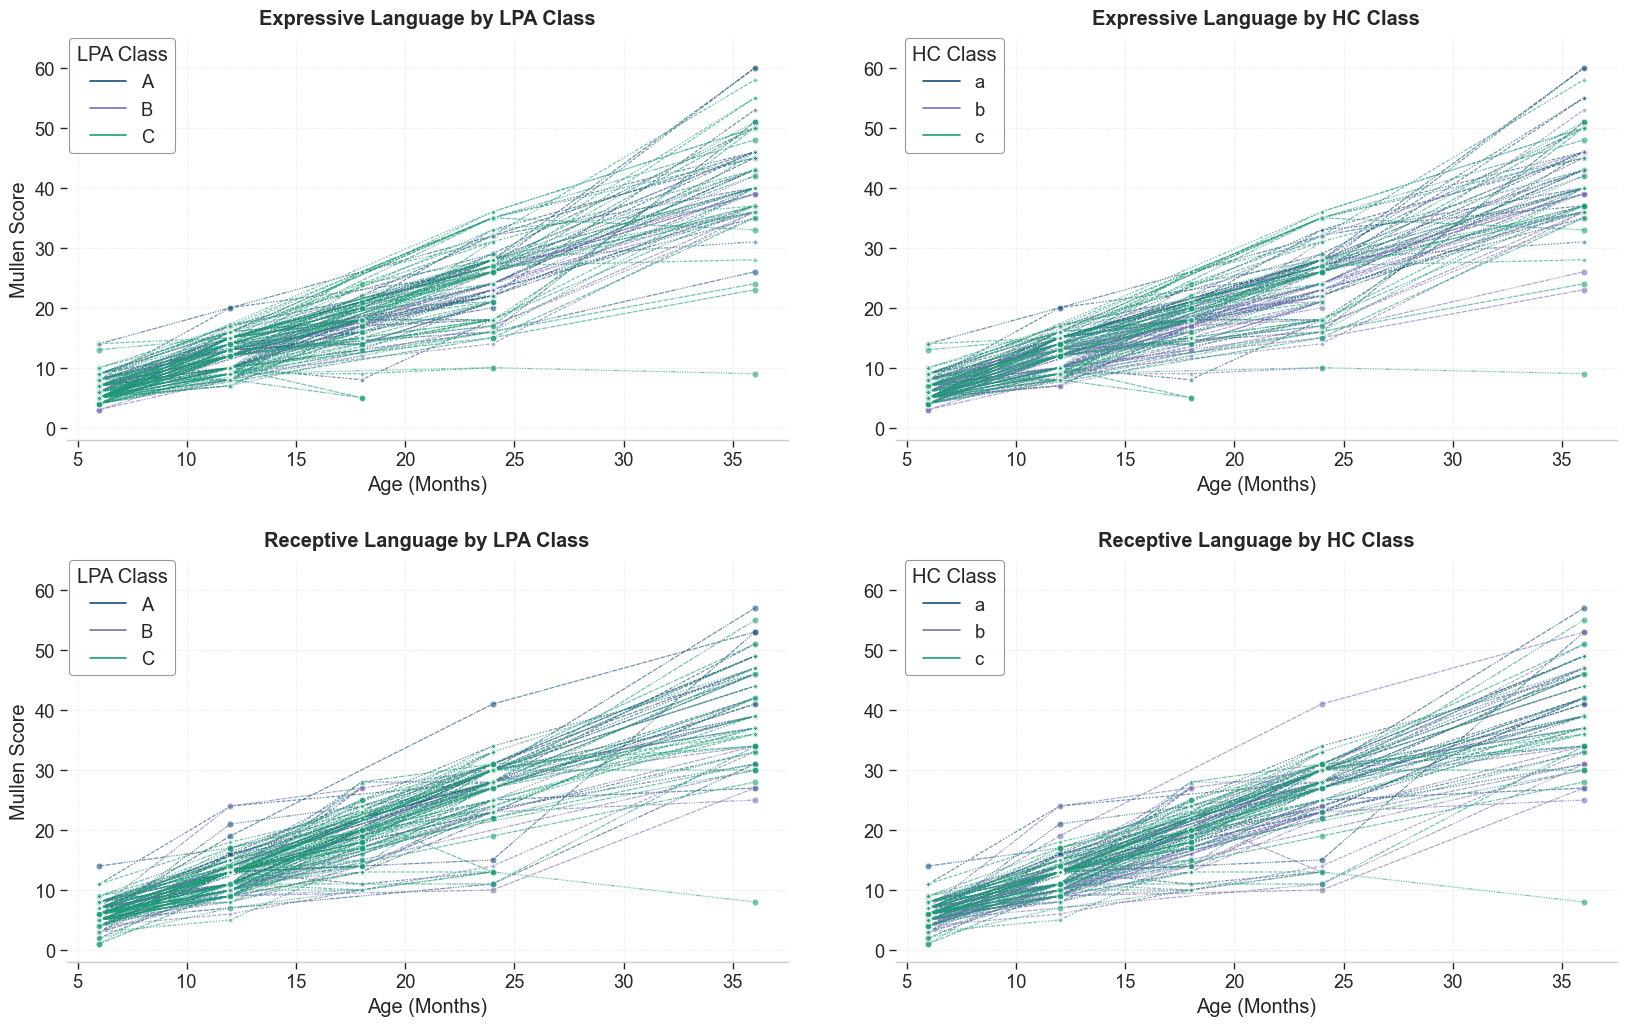

In [81]:
#sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})
#plt.rcParams['font.family'] = 'Arial'  # Professional font
class_palette =  sns.color_palette("husl", 3)  # Can be any of : "viridis", "husl", "colorblind", "cool", "muted"
class_palette = {"#184e77",  "#7570b3", "#1b9e77"}

# Create figure with constrained layout
fig, axs = plt.subplots(2, 2, figsize=(20, 12), 
                        gridspec_kw={'wspace': 0.15, 'hspace': 0.3})
axs = axs.flatten()

# Use perceptually uniform palette
subject_style = {'dashes': True, 'linewidth': 0.9, 'alpha': 0.6}

# --- Plot 1: Expressive by LPA ---
g1 = sns.lineplot(data=expressive_df, x="Age", y="score", hue="LPA Class", 
                 palette=class_palette, style="subject", markers=True,
                 ax=axs[0], **subject_style)
axs[0].set_title("Expressive Language by LPA Class", pad=10, weight='bold')
axs[0].set(ylabel="Mullen Score", xlabel="Age (Months)")

# --- Plot 2: Expressive by HC ---
g2 = sns.lineplot(data=expressive_df, x="Age", y="score", hue="HC Class", 
                 palette=class_palette, style="subject", markers=True,
                 ax=axs[1], **subject_style)
axs[1].set_title("Expressive Language by HC Class", pad=10, weight='bold')
axs[1].set(ylabel="", xlabel="Age (Months)")

# --- Plot 3: Receptive by LPA ---
g3 = sns.lineplot(data=receptive_df, x="Age", y="score", hue="LPA Class", 
                palette=class_palette, style="subject", markers=True,
                ax=axs[2], **subject_style)
axs[2].set_title("Receptive Language by LPA Class", pad=10, weight='bold')
axs[2].set(ylabel="Mullen Score", xlabel="Age (Months)")

# --- Plot 4: Receptive by HC ---
g4 = sns.lineplot(data=receptive_df, x="Age", y="score", hue="HC Class", 
                palette=class_palette, style="subject", markers=True,
                ax=axs[3], **subject_style)
axs[3].set_title("Receptive Language by HC Class", pad=10, weight='bold')
axs[3].set(ylabel="", xlabel="Age (Months)")

# --- Custom Legend Handling ---
def create_combined_legend(ax, title):
    # Get all handles and labels from seaborn
    class_handles, class_labels = ax.get_legend_handles_labels()
    
    # Filter to keep only hue-related entries (e.g., only alphabetical class labels or known hue names)
    class_handles_labels = [(h, l) for h, l in zip(class_handles, class_labels)
                            if l in ['A', 'B', 'C', 'a', 'b', 'c']]  # Keep only known hue names
    # Remove duplicates while preserving order
    seen = set()
    class_handles_labels = [(h, l) for h, l in class_handles_labels if not (l in seen or seen.add(l))]

    
    # Unzip filtered pairs
    if class_handles_labels:  # Ensure list isn't empty
        class_handles, class_labels = zip(*class_handles_labels)

        # Create custom legend
        leg = ax.legend(class_handles, class_labels, title=title, 
                        frameon=True, bbox_to_anchor=(0.15, 1), 
                        borderaxespad=0.)
        leg.get_frame().set_edgecolor('0.5')
        return leg
    else:
        return None

# Add legends to each subplot
create_combined_legend(axs[0], "LPA Class")
create_combined_legend(axs[1], "HC Class")
create_combined_legend(axs[2], "LPA Class")
create_combined_legend(axs[3], "HC Class")

for ax in axs:
    # Cleaner spines
    sns.despine(ax=ax, left=True)
    
    # Add subtle grid
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
    
    # Set consistent axis limits
    ax.set_ylim(expressive_df['score'].min()-5, expressive_df['score'].max()+5)


plt.tight_layout()

# Save the figure
plt.savefig(f"../../Figures/Supplementary/{date}/individual_language_trajectories_{date}.png", dpi=300, bbox_inches='tight')
plt.show()

### **ANOVA/KRUSTAL W ANALYSES**

In [82]:

def analyze_language_data(expressive_df, receptive_df, ages=[24, 36], output_dir="../../", date=date):
    """
    Analyze language data across different age groups and classification methods.
    
    Parameters:
    -----------
    expressive_df : pandas DataFrame
        DataFrame containing expressive language scores
    receptive_df : pandas DataFrame
        DataFrame containing receptive language scores
    ages : list, optional
        List of ages (in months) to analyze
    output_dir : str, optional
        Base directory for output files
    date : str, optional
        Date string for file naming
    """
    # Create output directories if they don't exist
    tables_dir = os.path.join(output_dir, "Tables", "Supplementary", date)
    figures_dir = os.path.join(output_dir, "Figures", "Supplementary", date)
    
    for directory in [tables_dir, figures_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Initialize results file
    results_file = os.path.join(tables_dir, f"language_analysis_results_{date}.txt")
    with open(results_file, 'w') as f:
        f.write(f"Language Measures Analysis Results - {date}\n")
        f.write("="*50 + "\n\n")
    
    for age in ages:
        print(f"\nAnalyzing data for {age} months...")
        
        # Filter data for the current age
        expr_age = expressive_df[expressive_df['Age'] == age].copy()
        recp_age = receptive_df[receptive_df['Age'] == age].copy()

        # Drop nan values
        expr_age = expr_age.dropna(subset=['score'])
        recp_age = recp_age.dropna(subset=['score'])
        
        # Run analyses for all four combinations
        expr_lpa_results = analyze_group_differences(expr_age, "Expressive", "LPA", results_file)
        expr_hc_results = analyze_group_differences(expr_age, "Expressive", "HC", results_file)
        recp_lpa_results = analyze_group_differences(recp_age, "Receptive", "LPA", results_file)
        recp_hc_results = analyze_group_differences(recp_age, "Receptive", "HC", results_file)

        # Print results to console
        print(f"\nSummary of findings for {age} months:")
        for result in [expr_lpa_results, expr_hc_results, recp_lpa_results, recp_hc_results]:
            print(result)

        # Create visualizations
        create_visualization(expr_age, recp_age, age, figures_dir, date)
        
        # Create and save summary table
        create_summary_table(expr_age, recp_age, age, tables_dir, date)
    
    print(f"\nAnalysis complete. Results saved to: {tables_dir} and {figures_dir}")


def analyze_group_differences(data, measure_type, stratification, results_file):
    """
    Check ANOVA assumptions and perform appropriate statistical tests.
    
    Parameters:
    -----------
    data : pandas DataFrame
        The data to analyze
    measure_type : str
        Type of language measure (e.g., "Expressive", "Receptive")
    stratification : str
        Stratification method (e.g., "LPA", "HC")
    results_file : str
        Path to the file where results will be saved
    
    Returns:
    --------
    str
        Text summary of the analysis results
    """
    age = data['Age'].iloc[0] if not data.empty else "Unknown"
    result_text = f"\n{measure_type} Language by {stratification} Class at {age} Months\n"
    result_text += "-"*50 + "\n"
    
    # Group variable name (either "LPA Class" or "HC Class")
    group_var = f"{stratification} Class"
    
    # Check if there is sufficient data
    if data.empty or group_var not in data.columns:
        result_text += "Insufficient data for analysis.\n"
        with open(results_file, 'a') as f:
            f.write(result_text)
        return result_text
    
    # Get unique groups
    groups = data[group_var].unique()
    
    # 1. Check normality assumption for each group
    result_text += "Normality Test (Shapiro-Wilk):\n"
    all_normal = True
    
    for group in groups:
        group_data = data[data[group_var] == group]['score']
        if len(group_data) >= 3:  # Need at least 3 data points for Shapiro-Wilk
            stat, p = stats.shapiro(group_data)
            normal = p > 0.05
            all_normal = all_normal and normal
            result_text += f"  Group {group}: W={stat:.4f}, p={p:.4f}, {'Normal' if normal else 'Non-normal'}\n"
        else:
            result_text += f"  Group {group}: Insufficient data for normality test (n={len(group_data)})\n"
            all_normal = False
    
    # 2. Check homogeneity of variance
    if len(groups) >= 2:
        # Extract groups for Levene's test
        group_data = [data[data[group_var] == group]['score'].values for group in groups]
        # Remove empty groups
        group_data = [g for g in group_data if len(g) > 0]
        
        if len(group_data) >= 2:  # Need at least 2 groups for test
            stat, p = stats.levene(*group_data)
            equal_var = p > 0.05
            result_text += f"\nHomogeneity of Variance (Levene's test):\n"
            result_text += f"  W={stat:.4f}, p={p:.4f}, {'Equal variances' if equal_var else 'Unequal variances'}\n"
        else:
            equal_var = True  # Default
            result_text += "\nHomogeneity of Variance: Insufficient groups for testing\n"
    else:
        equal_var = True  # Default
        result_text += "\nHomogeneity of Variance: Insufficient groups for testing\n"
    
    # 3. Perform appropriate statistical test
    if len(groups) >= 2:
        if all_normal and equal_var:
            # Create a copy of data with renamed column for statsmodels
            temp_data = data.copy()
            # Replace spaces with underscores in column names
            temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
            group_var_no_space = group_var.replace(' ', '_')
            
            # One-way ANOVA with renamed columns
            model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
            anova_results = anova_lm(model)
            
            result_text += "\nOne-way ANOVA Results:\n"
            result_text += f"  F({anova_results.loc[f'C({group_var_no_space})', 'df']:.0f}, {anova_results.loc['Residual', 'df']:.0f}) = {anova_results.loc[f'C({group_var_no_space})', 'F']:.4f}, "
            result_text += f"p = {anova_results.loc[f'C({group_var_no_space})', 'PR(>F)']:.4f}\n"
            
            # Add effect size (eta-squared)
            eta_sq = anova_results.loc[f'C({group_var_no_space})', 'sum_sq'] / (anova_results.loc[f'C({group_var_no_space})', 'sum_sq'] + anova_results.loc['Residual', 'sum_sq'])
            result_text += f"  Eta-squared = {eta_sq:.4f}\n"
            
            # If ANOVA is significant, perform post-hoc tests
            if anova_results.loc[f'C({group_var_no_space})', 'PR(>F)'] < 0.05:
                result_text += "\nPost-hoc Tests (Tukey HSD):\n"
                # For post-hoc tests, use original data and column names
                posthoc = pg.pairwise_tukey(data=data, dv='score', between=group_var)
                for idx, row in posthoc.iterrows():
                    result_text += f"  {row['A']} vs {row['B']}: diff={row['diff']:.4f}, p={row['p-tukey']:.4f}\n"
        else:
            # Kruskal-Wallis test (non-parametric alternative to ANOVA)
            valid_groups = [data[data[group_var] == group]['score'].values for group in groups if len(data[data[group_var] == group]) > 0]
            h_stat, p_val = stats.kruskal(*valid_groups)
            
            result_text += "\nKruskal-Wallis Test Results (non-parametric):\n"
            result_text += f"  H = {h_stat:.4f}, p = {p_val:.4f}\n"
            
            # If significant, perform post-hoc Dunn's test
            if p_val < 0.05:
                result_text += "\nPost-hoc Tests (Dunn's test):\n"
                try:
                    # Use dunn's test from scikit-posthocs as a safer alternative
                    from scikit_posthocs import posthoc_dunn
                    # Create a DataFrame with group labels
                    temp_df = data.copy()
                    posthoc_data = posthoc_dunn(temp_df, val_col='score', group_col=group_var, p_adjust='bonferroni')
                    
                    # Format the results
                    for i, group1 in enumerate(posthoc_data.index):
                        for j, group2 in enumerate(posthoc_data.columns):
                            if i < j:  # Only show each pair once
                                p_val = posthoc_data.iloc[i, j]
                                result_text += f"  {group1} vs {group2}: p={p_val:.4f}\n"
                except ImportError:
                    # Fallback to pingouin but handle the column naming issue
                    posthoc = pg.pairwise_tests(data=data, dv='score', between=group_var, parametric=False)
                    
                    # Debug column names
                    result_text += "  Available columns in post-hoc results: " + ", ".join(posthoc.columns.tolist()) + "\n\n"
                    
                    # Use correct column name for adjusted p-values
                    p_adj_col = 'p-corr' if 'p-corr' in posthoc.columns else 'p-adjust' if 'p-adjust' in posthoc.columns else 'p-unc'
                    
                    for idx, row in posthoc.iterrows():
                        result_text += f"  {row['A']} vs {row['B']}: p={row[p_adj_col]:.4f}\n"
    else:
        result_text += "\nInsufficient groups for statistical comparison\n"
    
    # 4. Descriptive statistics
    result_text += "\nDescriptive Statistics:\n"
    desc_stats = data.groupby(group_var)['score'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    for _, row in desc_stats.iterrows():
        result_text += f"  Group {row[group_var]}: n={row['count']}, Mean={row['mean']:.2f}, SD={row['std']:.2f}, Range={row['min']:.2f}-{row['max']:.2f}\n"
    
    # Write to file
    with open(results_file, 'a') as f:
        f.write(result_text)
    
    return result_text


def create_visualization(expr_data, recp_data, age, figures_dir, date):
    """
    Create and save visualization of language scores by group.
    
    Parameters:
    -----------
    expr_data : pandas DataFrame
        DataFrame containing expressive language scores
    recp_data : pandas DataFrame
        DataFrame containing receptive language scores
    age : int
        Age in months
    figures_dir : str
        Directory where figures will be saved
    date : str
        Date string for file naming
    """
    # Set up professional style - use a safer approach
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Use a colorblind-friendly palette
    class_palette = sns.color_palette("viridis", n_colors=3)  # Can be any of : "viridis", "husl", "colorblind", "cool
    #class_palette = {"#184e77", "#7570b3" ,"#1b9e77"} # These represent the colours: purple, blue, green
    class_palette = {"A": "#184e77", "B": "#7570b3", "C": "#1b9e77",
                      "a": "#184e77", "b": "#7570b3", "c": "#1b9e77"}

    
    
    # Create figure with constrained layout
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

    # Add more spece between subplots   
    fig.subplots_adjust(hspace=0.3, wspace=0.2, top=0.9)
    axs = axs.flatten()
    
    # Create boxplots
    create_boxplot(axs[0], expr_data, "LPA Class", f"Expressive Language by LPA Class at {age} Months", class_palette)
    create_boxplot(axs[1], expr_data, "HC Class", f"Expressive Language by HC Class at {age} Months", class_palette)
    create_boxplot(axs[2], recp_data, "LPA Class", f"Receptive Language by LPA Class at {age} Months", class_palette)
    create_boxplot(axs[3], recp_data, "HC Class", f"Receptive Language by HC Class at {age} Months", class_palette)
    
    
    # Save the figure
    output_file = os.path.join(figures_dir, f"language_analysis_{age}months_{date}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    if age == 36:
        # Save a separate version for the 36-months analysis in the ./Main directory

        output_file_36 = f"../../Figures/Main/language_analysis_36months_{date}.png"
        plt.savefig(output_file_36, dpi=300, bbox_inches='tight')
        try:
            plt.savefig(output_file_36.replace('.png', '.pdf'), format='pdf', bbox_inches='tight')  # Also save as PDF for publication
        except Exception as e:
            print(f"Warning: Could not save PDF version: {e}")
    plt.close()
    
    print(f"Created visualization: {output_file}")


def create_boxplot(ax, data, group_var, title, palette):
    """
    Create a boxplot with data points for a specific group variable.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    data : pandas DataFrame
        The data to plot
    group_var : str
        The grouping variable
    title : str
        The title for the plot
    palette : list
        Color palette to use
    """
    if group_var not in data.columns or data.empty:
        ax.text(0.5, 0.5, "Insufficient data", ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
    
    # Create boxplot with individual data points
    # make sure the paletee colours match the groups in the data
    palette = {k: palette[k] for k in data[group_var].unique()}
    

    sns.boxplot(x=group_var, y='score', data=data, palette=palette, ax=ax, width=0.5, fliersize=0)
    sns.stripplot(x=group_var, y='score', data=data, palette=palette, ax=ax, 
                dodge=True, alpha=0.7, jitter=0.2, marker='o', edgecolor='black', linewidth=0.5)
    
    # Set title and labels
    ax.set_title(title, pad=10)
    ax.set_ylabel("Mullen Score")
    ax.set_xlabel("")
    
    # Add statistics annotation
    add_stats_annotation(ax, data, group_var)
    
    # Clean up plot
    sns.despine(ax=ax)
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)


def add_stats_annotation(ax, data, group_var):
    """
    Add statistical annotation to a plot.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to annotate
    data : pandas DataFrame
        The data used in the plot
    group_var : str
        The grouping variable
    """
    # Get number of groups
    groups = data[group_var].unique()
    
    # Prepare annotation text based on test results
    if len(groups) >= 2:
        # Extract data for statistical test
        group_data = [data[data[group_var] == group]['score'].values for group in groups if len(data[data[group_var] == group]) > 0]
        
        # Check normality and homogeneity
        try:
            normal = all([stats.shapiro(g)[1] > 0.05 for g in group_data if len(g) >= 3])
        except:
            normal = False  # Default to non-parametric if there's an issue
            
        if len(group_data) >= 2:
            try:
                equal_var = stats.levene(*group_data)[1] > 0.05
            except:
                equal_var = False  # Default to non-parametric if there's an issue
        else:
            equal_var = True
        
        # Run appropriate test
        if normal and equal_var:
            # One-way ANOVA - using renamed columns to avoid space issues
            try:
                temp_data = data.copy()
                temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
                group_var_no_space = group_var.replace(' ', '_')
                
                model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
                anova_table = anova_lm(model)
                p_val = anova_table.loc[f'C({group_var_no_space})', 'PR(>F)']
                test_name = "ANOVA"
                test_stat = f"F={anova_table.loc[f'C({group_var_no_space})', 'F']:.2f}"
            except Exception as e:
                # Fall back to Kruskal-Wallis if ANOVA fails
                try:
                    h_stat, p_val = stats.kruskal(*group_data)
                    test_name = "Kruskal-Wallis"
                    test_stat = f"H={h_stat:.2f}"
                except:
                    p_val = np.nan
                    test_name = "Error"
                    test_stat = ""
        else:
            # Kruskal-Wallis
            try:
                h_stat, p_val = stats.kruskal(*group_data)
                test_name = "Kruskal-Wallis"
                test_stat = f"H={h_stat:.2f}"
            except:
                p_val = np.nan
                test_name = "Error"
                test_stat = ""
        
        # Format annotation based on significance
        if not pd.isna(p_val):
            if p_val < 0.001:
                sig_text = f"{test_name}: {test_stat}, p<0.001 ***"
            elif p_val < 0.01:
                sig_text = f"{test_name}: {test_stat}, p<0.01 **"
            elif p_val < 0.05:
                sig_text = f"{test_name}: {test_stat}, p<0.05 *"
            else:
                sig_text = f"{test_name}: {test_stat}, p={p_val:.3f} ns"
        else:
            sig_text = f"{test_name}: Could not calculate"
            
        # Add text to plot
        ax.text(0.5, 0.98, sig_text, transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))


def create_summary_table(expr_data, recp_data, age, tables_dir, date):
    """
    Create and save a summary table of results.
    
    Parameters:
    -----------
    expr_data : pandas DataFrame
        DataFrame containing expressive language scores
    recp_data : pandas DataFrame
        DataFrame containing receptive language scores
    age : int
        Age in months
    tables_dir : str
        Directory where tables will be saved
    date : str
        Date string for file naming
    """
    summary_data = []

    for df, measure, strat in [(expr_data, "Expressive", "LPA"), 
                              (expr_data, "Expressive", "HC"),
                              (recp_data, "Receptive", "LPA"),
                              (recp_data, "Receptive", "HC")]:
        
        group_var = f"{strat} Class"
        
        # Skip if data is insufficient
        if group_var not in df.columns or df.empty:
            continue
            
        # Get descriptive stats by group
        desc = df.groupby(group_var)['score'].agg(['count', 'mean', 'std']).reset_index()
        
        # Get statistical test results
        groups = df[group_var].unique()
        test_stat = np.nan
        p_val = np.nan
        test_type = "N/A"
        df_val = np.nan
        
        if len(groups) >= 2:
            # Extract data for test
            group_data = [df[df[group_var] == group]['score'].values for group in groups if len(df[df[group_var] == group]) > 0]
            
            # Check normality and homogeneity
            try:
                normal = all([stats.shapiro(g)[1] > 0.05 for g in group_data if len(g) >= 3])
            except:
                normal = False
                
            if len(group_data) >= 2:
                try:
                    equal_var = stats.levene(*group_data)[1] > 0.05
                except:
                    equal_var = False
            else:
                equal_var = True
            
            # Run appropriate test
            if normal and equal_var:
                try:
                    # ANOVA - using renamed columns to avoid space issues
                    temp_data = df.copy()
                    temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
                    group_var_no_space = group_var.replace(' ', '_')
                    
                    model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
                    test_results = anova_lm(model)
                    p_val = test_results.loc[f'C({group_var_no_space})', 'PR(>F)']
                    test_stat = test_results.loc[f'C({group_var_no_space})', 'F']
                    test_type = "ANOVA (F)"
                    df_val = f"{test_results.loc[f'C({group_var_no_space})', 'df']:.0f}, {test_results.loc['Residual', 'df']:.0f}"
                except:
                    # Fall back to Kruskal-Wallis
                    try:
                        test_stat, p_val = stats.kruskal(*group_data)
                        test_type = "Kruskal-Wallis (H)"
                        df_val = len(groups) - 1  # df for Kruskal-Wallis is k-1
                    except:
                        test_stat = np.nan
                        p_val = np.nan
                        test_type = "Error in analysis"
            else:
                # Kruskal-Wallis
                try:
                    test_stat, p_val = stats.kruskal(*group_data)
                    test_type = "Kruskal-Wallis (H)"
                    df_val = len(groups) - 1  # df for Kruskal-Wallis is k-1
                except:
                    test_stat = np.nan
                    p_val = np.nan
                    test_type = "Error in analysis"
        
        # Add to summary data
        for _, row in desc.iterrows():
            summary_data.append({
                'Age': age,
                'Measure': measure,
                'Stratification': strat,
                'Group': row[group_var],
                'N': row['count'],
                'Mean': row['mean'],
                'SD': row['std'],
                'Test': test_type if _ == 0 else "",  # Only include test info once per stratification
                'df': df_val if _ == 0 else np.nan,
                'Statistic': test_stat if _ == 0 else np.nan,
                'p-value': p_val if _ == 0 else np.nan,
                'Significance': get_significance_marker(p_val) if _ == 0 else ""
            })

    # Create and save summary table
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        # Format numeric columns
        summary_df['Mean'] = summary_df['Mean'].round(2)
        summary_df['SD'] = summary_df['SD'].round(2)
        summary_df['Statistic'] = summary_df['Statistic'].apply(lambda x: round(x, 2) if pd.notnull(x) else x)
        
        # Format p-values
        summary_df['p-value'] = summary_df['p-value'].apply(lambda x: format_p_value(x) if not pd.isna(x) else x)
        
        # Save as CSV
        output_file = os.path.join(tables_dir, f"Language_analysis_summary_{age}mo_{date}.csv")
        #summary_df.to_csv(output_file, index=False)
        
        # Also save as Excel for easier editing
        try:
            summary_df.to_excel(output_file.replace('.csv', '.xlsx'), index=False)
        except:
            print(f"Warning: Could not save Excel file. Make sure openpyxl is installed.")
        
        print(f"Created summary table: {output_file}")
    else:
        print(f"Insufficient data to create summary table for age {age} months")


def get_significance_marker(p_value):
    """Return significance marker based on p-value."""
    if pd.isna(p_value):
        return ""
    elif p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"


def format_p_value(p_value):
    """Format p-value for reporting."""
    if pd.isna(p_value):
        return ""
    elif p_value < 0.001:
        return "<0.001"
    else:
        return f"{p_value:.3f}"
analyze_language_data(expressive_df, receptive_df, ages=[12,24, 36], output_dir="../../", date=date)


Analyzing data for 12 months...

Summary of findings for 12 months:

Expressive Language by LPA Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group A: W=0.9474, p=0.0568, Normal
  Group C: W=0.9441, p=0.0039, Non-normal
  Group B: W=0.9586, p=0.5455, Normal

Homogeneity of Variance (Levene's test):
  W=0.0062, p=0.9938, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 2.4537, p = 0.2932

Descriptive Statistics:
  Group A: n=41, Mean=13.02, SD=2.80, Range=8.00-20.00
  Group B: n=19, Mean=11.95, SD=2.90, Range=7.00-17.00
  Group C: n=69, Mean=12.13, SD=2.68, Range=7.00-17.00


Expressive Language by HC Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group b: W=0.9647, p=0.1738, Normal
  Group c: W=0.9356, p=0.0090, Non-normal
  Group a: W=0.9366, p=0.0541, Normal

Homogeneity of Variance (Levene's test):
  W=1.6352, p=0.1990, Equal variances

Kruskal-Wallis

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_12months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_12mo_2025_04_23.csv

Analyzing data for 24 months...

Summary of findings for 24 months:

Expressive Language by LPA Class at 24 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group A: W=0.9713, p=0.4972, Normal
  Group C: W=0.9540, p=0.0402, Non-normal
  Group B: W=0.9014, p=0.1399, Normal

Homogeneity of Variance (Levene's test):
  W=1.9681, p=0.1453, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 2.6900, p = 0.2605

Descriptive Statistics:
  Group A: n=34, Mean=24.85, SD=4.84, Range=16.00-35.00
  Group B: n=13, Mean=22.69, SD=4.33, Range=14.00-28.00
  Group C: n=53, Mean=25.15, SD=6.66, Range=10.00-36.00


Expressive Language by HC Class at 24 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_24months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_24mo_2025_04_23.csv

Analyzing data for 36 months...

Summary of findings for 36 months:

Expressive Language by LPA Class at 36 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group C: W=0.9436, p=0.1136, Normal
  Group B: W=0.8836, p=0.0975, Normal
  Group A: W=0.9686, p=0.6336, Normal

Homogeneity of Variance (Levene's test):
  W=4.0953, p=0.0213, Unequal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 4.1061, p = 0.1283

Descriptive Statistics:
  Group A: n=24, Mean=43.25, SD=8.08, Range=26.00-60.00
  Group B: n=12, Mean=38.67, SD=3.08, Range=35.00-46.00
  Group C: n=30, Mean=40.60, SD=10.54, Range=9.00-58.00


Expressive Language by HC Class at 36 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
 

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_36months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_36mo_2025_04_23.csv

Analysis complete. Results saved to: ../../Tables\Supplementary\2025_04_23 and ../../Figures\Supplementary\2025_04_23


### Add plots for comparison between ASD and non-ASD


In [92]:
# Create dataframe for only the ASD group 

asd_expressive_df= lang_wide[lang_wide['ASD Diagnosis'] == 'asd'].copy()

asd_expressive_df= asd_expressive_df[["HC Class"] + ["LPA Class"] + ["subject"] + cleaned_expres_vars]
asd_expressive_df= asd_expressive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
asd_expressive_df["Age"] = asd_expressive_df["Age"].str.extract("(\d+)").astype(int)
asd_expressive_df["Measure"] = "Expressive"
asd_expressive_df["ASD Diagnosis"] = "ASD"

asd_receptive_df= lang_wide[lang_wide['ASD Diagnosis'] == 'asd'].copy()
asd_receptive_df= asd_receptive_df[["HC Class"] + ["LPA Class"] + ["subject"] + cleaned_receptive_vars]
asd_receptive_df= asd_receptive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
asd_receptive_df["Age"] = asd_receptive_df["Age"].str.extract("(\d+)").astype(int)
asd_receptive_df["Measure"] = "Receptive"
asd_receptive_df["ASD Diagnosis"] = "ASD"   

analyze_language_data(asd_receptive_df, asd_receptive_df, ages=[12,24, 36], output_dir="../../ASD_extra", date=date)



asd_expressive_df


Analyzing data for 12 months...

Summary of findings for 12 months:

Expressive Language by LPA Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group C: W=0.8774, p=0.0657, Normal
  Group B: W=0.7907, p=0.0865, Normal
  Group A: W=0.9497, p=0.7143, Normal

Homogeneity of Variance (Levene's test):
  W=0.0758, p=0.9273, Equal variances

One-way ANOVA Results:
  F(2, 18) = 7.2104, p = 0.0050
  Eta-squared = 0.4448

Post-hoc Tests (Tukey HSD):
  A vs B: diff=4.7500, p=0.0195
  A vs C: diff=4.6923, p=0.0046
  B vs C: diff=-0.0577, p=0.9989

Descriptive Statistics:
  Group A: n=4, Mean=15.00, SD=1.83, Range=13.00-17.00
  Group B: n=4, Mean=10.25, SD=1.89, Range=9.00-13.00
  Group C: n=13, Mean=10.31, SD=2.39, Range=5.00-13.00


Expressive Language by HC Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group c: W=0.8464, p=0.0680, Normal
  Group b: W=0.8170, p=0.0600, Normal
  Group a

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../ASD_extra\Figures\Supplementary\2025_04_23\language_analysis_12months_2025_04_23.png
Created summary table: ../../ASD_extra\Tables\Supplementary\2025_04_23\Language_analysis_summary_12mo_2025_04_23.csv

Analyzing data for 24 months...

Summary of findings for 24 months:

Expressive Language by LPA Class at 24 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group C: W=0.8819, p=0.1098, Normal
  Group A: W=0.7967, p=0.0964, Normal
  Group B: Insufficient data for normality test (n=2)

Homogeneity of Variance (Levene's test):
  W=2.1651, p=0.1516, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 1.2768, p = 0.5281

Descriptive Statistics:
  Group A: n=4, Mean=21.25, SD=10.72, Range=11.00-31.00
  Group B: n=2, Mean=16.50, SD=9.19, Range=10.00-23.00
  Group C: n=11, Mean=22.00, SD=6.68, Range=13.00-30.00


Expressive Language by HC Class at 24 Months
--------------------------------------------------

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../ASD_extra\Figures\Supplementary\2025_04_23\language_analysis_24months_2025_04_23.png
Created summary table: ../../ASD_extra\Tables\Supplementary\2025_04_23\Language_analysis_summary_24mo_2025_04_23.csv

Analyzing data for 36 months...

Summary of findings for 36 months:

Expressive Language by LPA Class at 36 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group C: W=0.9472, p=0.7173, Normal
  Group A: W=0.8572, p=0.2504, Normal
  Group B: Insufficient data for normality test (n=2)

Homogeneity of Variance (Levene's test):
  W=0.8963, p=0.4454, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 3.3562, p = 0.1867

Descriptive Statistics:
  Group A: n=4, Mean=37.50, SD=8.54, Range=31.00-49.00
  Group B: n=2, Mean=26.00, SD=1.41, Range=25.00-27.00
  Group C: n=5, Mean=30.60, SD=14.43, Range=8.00-47.00


Expressive Language by HC Class at 36 Months
--------------------------------------------------
N

C:\Users\gabot\AppData\Local\Temp\ipykernel_25624\1120533397.py:246: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.



Created visualization: ../../ASD_extra\Figures\Supplementary\2025_04_23\language_analysis_36months_2025_04_23.png
Created summary table: ../../ASD_extra\Tables\Supplementary\2025_04_23\Language_analysis_summary_36mo_2025_04_23.csv

Analysis complete. Results saved to: ../../ASD_extra\Tables\Supplementary\2025_04_23 and ../../ASD_extra\Figures\Supplementary\2025_04_23


HC Class LPA Class  subject  Age  score     Measure ASD Diagnosis
0          c         C        8    6    5.0  Expressive           ASD
1          b         B       23    6    5.0  Expressive           ASD
2          a         A       27    6    5.0  Expressive           ASD
3          c         C       45    6    4.0  Expressive           ASD
4          b         C       48    6    6.0  Expressive           ASD
..       ...       ...      ...  ...    ...         ...           ...
105        c         C      636   36    9.0  Expressive           ASD
106        a         A      637   36   31.0  Expressive           ASD
107        b         A      651   36   26.0  Expressive           ASD
108        a         A      653   36   40.0  Expressive           ASD
109        b         B      933   36    NaN  Expressive           ASD

[110 rows x 7 columns]

In [93]:
expressive_df

HC Class LPA Class  subject  Age  score     Measure
0          b         A        2    6    5.0  Expressive
1          c         C        3    6    7.0  Expressive
2          c         C        5    6    5.0  Expressive
3          c         C        6    6    4.0  Expressive
4          c         C        8    6    5.0  Expressive
..       ...       ...      ...  ...    ...         ...
715        c         C      915   36    NaN  Expressive
716        b         B      933   36    NaN  Expressive
717        c         C      937   36    NaN  Expressive
718        b         A       51   36    NaN  Expressive
719        b         B      147   36    NaN  Expressive

[720 rows x 6 columns]

In [ ]:
analyze_language_data(expressive_df, receptive_df, ages=[12,24, 36], output_dir="../../", date=date)

## Individual trajectories

### **Correlation Language and EEG Variables**

In [131]:
expressive_vars = ['expressive_6', 'expressive_12', 'expressive_24', 'expressive_36']
receptive_vars= ['receptive_6', 'receptive_12', 'receptive_24', 'receptive_36']

#### Expressive

In [132]:
# Create correlation matrix of language measures and connectivity measures

# Select the columns to include in the correlation matrix (select only expressive language measures)
columns = eeg_vars + expressive_vars

corr_df = neurosubs_df[columns]
# Rename the columns based on mapping
corr_df.rename(columns=clean_column_name_mapping, inplace=True)

# Create the correlation matrix
corr_matrix = corr_df.corr().round(2)

# Calculate p-values for the correlation matrix
from scipy.stats import pearsonr

def calculate_p_values(df):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
                p_values.iloc[i, j] = p_value
            else:
                p_values.iloc[i, j] = 0  # Set diagonal to 0
    return p_values
p_values = calculate_p_values(corr_df)


# Plot the correlation matrix (only the lower tri)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="vlag", center=0, vmin=-1, vmax=1, square=True, mask=np.triu(corr_matrix))
# Add * for p-values < 0.05
for i in range(len(p_values.columns)):
    for j in range(len(p_values.columns)):
        if p_values.iloc[i, j] < 0.05 and i != j:
            plt.text(j + 0.5, i + 0.5, "*", color="black", ha="center", va="center", fontsize=16)
plt.title("Correlation Matrix of Expressive and EEG Measures")
plt.show()



C:\Users\gabot\AppData\Local\Temp\ipykernel_20196\1693576185.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: array must not contain infs or NaNs

In [ ]:
# Plot 1: Expressive variables correlation matrix
expressive_columns = eeg_vars + expressive_vars
expressive_corr_df = neurosubs_df[expressive_columns].rename(columns=clean_column_name_mapping)

# Calculate correlation matrix with NAs dropped pairwise
expressive_corr_matrix = expressive_corr_df.corr(method='pearson', min_periods=1).round(2)
expressive_p_values = calculate_p_values(expressive_corr_df)

# Choose the significance highlighting method: 'bold', 'border' or 'size'
significance_method = 'border'

plot_correlation_matrix(
    expressive_corr_matrix, 
    expressive_p_values, 
    "Correlation Matrix of Expressive Language and EEG Measures",
    significance_method
)
plt.show()

# Plot 2: Receptive variables correlation matrix
receptive_columns = eeg_vars + receptive_vars
receptive_corr_df = neurosubs_df[receptive_columns].rename(columns=clean_column_name_mapping)

# Calculate correlation matrix with NAs dropped pairwise
receptive_corr_matrix = receptive_corr_df.corr(method='pearson', min_periods=1).round(2)
receptive_p_values = calculate_p_values(receptive_corr_df)

plot_correlation_matrix(
    receptive_corr_matrix, 
    receptive_p_values, 
    "Correlation Matrix of Receptive Language and EEG Measures",
    significance_method
)
plt.show()

ValueError: array must not contain infs or NaNs

In [ ]:
corr_df

Connectivity Auditory  Connectivity Language  Connectivity Speech  \
0                -1.598480              -1.161137            -1.225266   
1                -1.829292              -1.516043            -1.659758   
2                -1.823852              -1.619339            -1.464546   
3                -1.429544              -1.602488            -1.757113   
4                -1.765373              -1.587519            -1.432471   
..                     ...                    ...                  ...   
139              -1.788839              -1.603515            -1.522898   
140              -1.071994              -1.285763            -1.526620   
141              -1.762447              -1.702147            -1.740539   
142              -1.490023              -1.357769            -1.000501   
143              -1.030670              -1.411843            -1.613702   

     Frontal Gamma Power  Power Lateralization  Expressive MSEL 6 months  \
0             -21.420116                   NaN                       5.0   
1             -21.072590              0.040530                       7.0   
2             -22.141673             -0.016544                       5.0   
3             -21.630370             -0.164802                       4.0   
4             -21.588120             -0.108383                       5.0   
..                   ...                   ...                       ...   
139           -20.919022              0.042839                       5.0   
140           -21.463387             -0.097921                       5.0   
141           -21.106285                   NaN                       6.0   
142                  NaN             -0.088992                       5.0   
143                  NaN             -0.131578                       6.0   

     Expressive MSEL 12 months  Expressive MSEL 24 months  \
0                         13.0                       21.0   
1                         14.0                       21.0   
2                          NaN                        NaN   
3                         12.0                       27.0   
4                          8.0                       24.0   
..                         ...                        ...   
139                       15.0                       24.0   
140                       10.0                        NaN   
141                       10.0                        NaN   
142                       12.0                        NaN   
143                       14.0                        NaN   

     Expressive MSEL 36 months  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
..                         ...  
139                        NaN  
140                        NaN  
141                        NaN  
142                        NaN  
143                        NaN  

[144 rows x 9 columns]

In [ ]:
corr_df

Connectivity Auditory  Connectivity Language  Connectivity Speech  \
0                -1.598480              -1.161137            -1.225266   
1                -1.829292              -1.516043            -1.659758   
2                -1.823852              -1.619339            -1.464546   
3                -1.429544              -1.602488            -1.757113   
4                -1.765373              -1.587519            -1.432471   
..                     ...                    ...                  ...   
139              -1.788839              -1.603515            -1.522898   
140              -1.071994              -1.285763            -1.526620   
141              -1.762447              -1.702147            -1.740539   
142              -1.490023              -1.357769            -1.000501   
143              -1.030670              -1.411843            -1.613702   

     Frontal Gamma Power  Power Lateralization  Expressive MSEL 6 months  \
0             -21.420116                   NaN                       5.0   
1             -21.072590              0.040530                       7.0   
2             -22.141673             -0.016544                       5.0   
3             -21.630370             -0.164802                       4.0   
4             -21.588120             -0.108383                       5.0   
..                   ...                   ...                       ...   
139           -20.919022              0.042839                       5.0   
140           -21.463387             -0.097921                       5.0   
141           -21.106285                   NaN                       6.0   
142                  NaN             -0.088992                       5.0   
143                  NaN             -0.131578                       6.0   

     Expressive MSEL 12 months  Expressive MSEL 24 months  \
0                         13.0                       21.0   
1                         14.0                       21.0   
2                          NaN                        NaN   
3                         12.0                       27.0   
4                          8.0                       24.0   
..                         ...                        ...   
139                       15.0                       24.0   
140                       10.0                        NaN   
141                       10.0                        NaN   
142                       12.0                        NaN   
143                       14.0                        NaN   

     Expressive MSEL 36 months  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
..                         ...  
139                        NaN  
140                        NaN  
141                        NaN  
142                        NaN  
143                        NaN  

[144 rows x 9 columns]

## Archive

In [ ]:
graphing_df = plotting_df.copy()

hc_order = ["a", "b", "c"]
lpa_order = ["A", "B", "C"]

# Create two separate dataframes for each class
hc_graph_df = graphing_df[graphing_df["HC Class"].isin(hc_order)]
mp_graph_df = graphing_df[graphing_df["LPA Class"].isin(lpa_order)]

# Sort the each column for each dataframe by the specified order
hc_graph_df["HC Class"] = pd.Categorical(hc_graph_df["HC Class"], categories=hc_order, ordered=True)
mp_graph_df["LPA Class"] = pd.Categorical(mp_graph_df["LPA Class"], categories=lpa_order, ordered=True)


layout = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "H"],
    ["I", "J"]]
fig, axd = plt.subplot_mosaic(layout, figsize=(25, 50))

# Add main title
fig.suptitle('Demographic characteristics by HC Class and LPA Class', fontsize=16)

# Function to plot for a given class and axis
def plot_class_distribution(df, class_col, ax, title, order):
    sns.barplot(x=df[class_col].value_counts().index, y=df[class_col].value_counts().values, palette="Set2", ax=ax, order=order)
    # add ylims
    ax.set_title(title)
    ax.set_xlabel(class_col)
    ax.set_ylabel("Number of participants")
    ax.set_ylim(0, 120)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
    )

# Plot 1 & 2 for HC Class and LPA Class size
plot_class_distribution(hc_graph_df, 'HC Class', axd["A"], "HC Class Size", hc_order)
plot_class_distribution(graphing_df, 'LPA Class', axd["B"], "LPA Class Size", lpa_order)

# Function to plot proportion of ASD with specified order
def plot_proportion_asd(df, class_col, ax, order):
    # Group by the specified class column and calculate outcome proportions
    outcome_dist = df.groupby(class_col)["ASD Diagnosis"].value_counts().unstack().reset_index().fillna(0)
    outcome_dist["total"] = outcome_dist["asd"] + outcome_dist["no-asd"]
    outcome_dist["asd"] = outcome_dist["asd"] / outcome_dist["total"]

    # Sort the outcome distribution by the specified order
    outcome_dist = outcome_dist.set_index(class_col).loc[order].reset_index()

    sns.barplot(x=outcome_dist[class_col], y=outcome_dist["asd"], palette="Blues", ax=ax)
    ax.set_title(f"Proportion of ASD in each {class_col}")
    ax.set_xlabel(class_col)
    ax.set_ylim(0, 0.5)

    ax.set_ylabel("Percentage ASD in study (%)")

# Plot 3 & 4 for proportions with the specified order
plot_proportion_asd(hc_graph_df, 'HC Class', axd["C"], hc_order)
plot_proportion_asd(mp_graph_df, 'LPA Class', axd["D"], lpa_order)

# Function for stacked distributions
def plot_stacked_distribution(df, class_col, ax, colors, title):
    dist = df.groupby(class_col)["ASD Likelihood"].value_counts().unstack().reset_index().fillna(0)
    dist["total"] = dist["ELA"] + dist["TLA"]
    dist["ELA"] = dist["ELA"] / dist["total"]
    dist["TLA"] = dist["TLA"] / dist["total"]
    dist.index = dist[class_col]
    dist.drop(columns=[class_col, "total"], inplace=True)
    dist.plot(kind="bar", stacked=True, color=colors, ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 1.3)
    ax.legend(title="Outcome", loc='upper left', labels=['ELA', 'TLA'], ncol=2)

# Plot stacked distributions for outcomes
plot_stacked_distribution(hc_graph_df, 'HC Class', axd["E"], ['salmon','skyblue'], "Proportion of Outcomes by HC Class")
plot_stacked_distribution(mp_graph_df, 'LPA Class', axd["F"], ['salmon','skyblue'], "Proportion of Outcomes by MP Class")

# Plot 5: Distribution of sex in each class
def plot_sex_distribution(df, class_col, ax):
    sex_dist = df.groupby(class_col)["Sex"].value_counts().unstack().reset_index().fillna(0)
    sex_dist["total"] = sex_dist["F"] + sex_dist["M"]
    sex_dist["F"] = sex_dist["F"] / sex_dist["total"]
    sex_dist["M"] = sex_dist["M"] / sex_dist["total"]
    sex_dist.index = sex_dist[class_col]
    sex_dist.drop(columns=[class_col, "total"], inplace=True)
    sex_dist.plot(kind="bar", stacked=True, color=['firebrick', 'steelblue'], ax=ax)
    ax.set_title(f"Sex Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Sex", loc='upper right')

# Plot 5 & 6 for sex distribution
plot_sex_distribution(hc_graph_df, 'HC Class', axd["G"])
plot_sex_distribution(mp_graph_df, 'LPA Class', axd["H"])

# Plot 7: Site distribution in each class
def plot_site_distribution(df, class_col, ax):
    site_dist = df.groupby(class_col)["Site"].value_counts().unstack().reset_index().fillna(0)
    site_dist["total"] = site_dist["london"] + site_dist["washington"]
    site_dist["london"] = site_dist["london"] / site_dist["total"]
    site_dist["washington"] = site_dist["washington"] / site_dist["total"]
    site_dist.index = site_dist[class_col]
    site_dist.drop(columns=[class_col, "total"], inplace=True)
    site_dist.plot(kind="bar", stacked=True, color=['darkorange', 'darkblue'], ax=ax)
    ax.set_title(f"Site Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Site", loc='upper right')

# Plot 7 & 8 for site distribution
plot_site_distribution(hc_graph_df, 'HC Class', axd["I"])
plot_site_distribution(mp_graph_df, 'LPA Class', axd["J"])

# Final adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Make 4 subplots, one for each language measure (expressive vs receptive) and for for type of stratification (HC Class vs LPA Class)

custom_palette = sns.color_palette("Set1", n_colors=3)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array

# Plot the distribution of the LPA classes
sns.lineplot(data=expressive_df, x="Age", y="score", hue="LPA Class", ax=axs[0], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[0].get_legend().remove()
axs[0].set_title("Expressive Language Measures by LPA Class")
axs[0].set_ylabel("Mullen Score")
axs[0].set_xlabel("Age (Months)")

# Plot the distribution of the HC classes
sns.lineplot(data=expressive_df, x="Age", y="score", hue="HC Class", ax=axs[1], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[1].get_legend().remove()
axs[1].set_title("Expressive Language Measures by HC Class")
axs[1].set_ylabel("Mullen Score")
axs[1].set_xlabel("Age (Months)")

# Plot the distribution of the LPA classes
sns.lineplot(data=receptive_df, x="Age", y="score", hue="LPA Class", ax=axs[2], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[2].get_legend().remove()
axs[2].set_title("Receptive Language Measures by LPA Class")
axs[2].set_ylabel("Mullen Score")
axs[2].set_xlabel("Age (Months)")

# Plot the distribution of the HC classes
sns.lineplot(data=receptive_df, x="Age", y="score", hue="HC Class", ax=axs[3], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[3].get_legend().remove()
axs[3].set_title("Receptive Language Measures by HC Class")
axs[3].set_ylabel("Mullen Score")
axs[3].set_xlabel("Age (Months)")

# Adjust the layout
plt.tight_layout()


plt.show()

In [291]:
mice_df

NameError: name 'mice_df' is not defined

# **EEG PROFILE PLOTS**

In [135]:
measures = ["Connectivity Speech", "Connectivity Auditory", 
            "Frontal Gamma Power", "Power Lateralization", "Connectivity Language"]

# Load MICE data from csv file
normalized_df = pd.read_csv(f"../../Datasets/hierarchical/source/{date}/combined/MICE/5Dcombined_data_{date}.csv")

# Rename columns based on mapping
normalized_df.rename(columns=clean_column_name_mapping, inplace=True)

for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Add LPA and HC Classes
normalized_df["LPA Class"] = plotting_df["LPA Class"]
normalized_df["HC Class"] = plotting_df["HC Class"]

# Calculate cluster profiles (means)
profiles_hc = normalized_df.groupby("HC Class").mean()[measures]
profiles_lpa = normalized_df.groupby("LPA Class").mean()[measures]

# Get cluster sizes for annotation
hc_sizes = plotting_df.groupby("HC Class").size()
lpa_sizes = plotting_df.groupby("LPA Class").size()


# Add cluster sizes to profiles
for i in profiles_hc.index:
    profiles_hc.loc[i, 'size'] = hc_sizes[i]
for i in profiles_lpa.index:
    profiles_lpa.loc[i, 'size'] = lpa_sizes[i]



C:\Users\gabot\AppData\Local\Temp\ipykernel_20196\3989680313.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\gabot\AppData\Local\Temp\ipykernel_20196\3989680313.py:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [136]:
profiles_lpa

Connectivity Speech  Connectivity Auditory  Frontal Gamma Power  \
LPA Class                                                                    
A                     1.132710              -0.261647             0.009409   
B                    -0.082750               1.810920             0.441572   
C                    -0.654116              -0.337579            -0.126050   

           Power Lateralization  Connectivity Language  size  
LPA Class                                                     
A                      0.329953               0.727634  46.0  
B                      0.013278               0.598483  21.0  
C                     -0.200736              -0.597913  77.0

### 1. Radar Plots

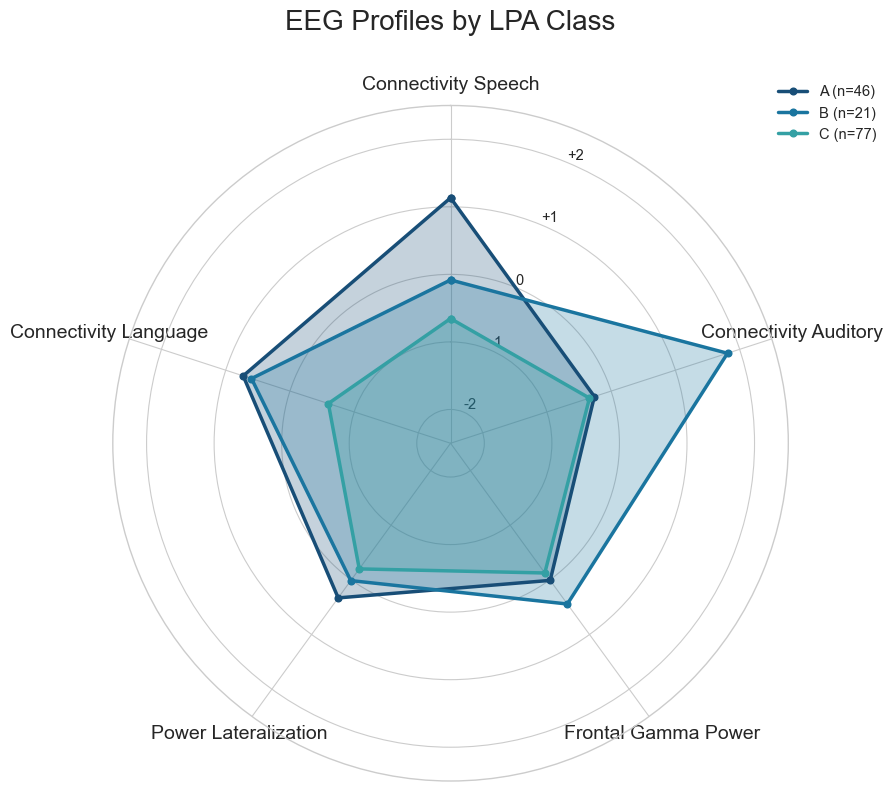

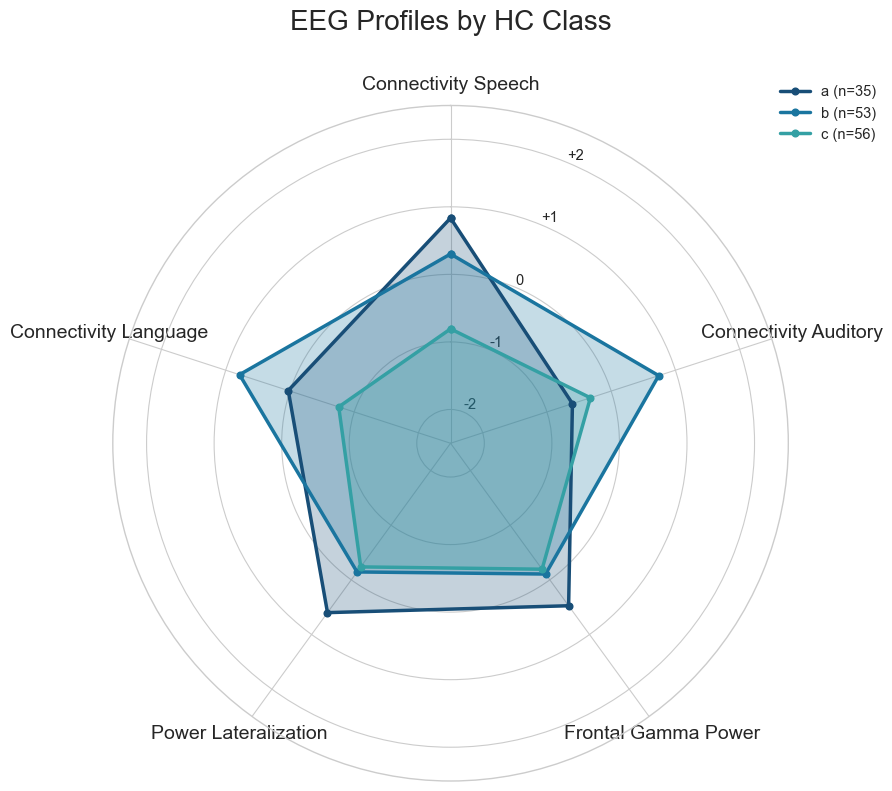

In [137]:

def radar_plot(profiles, method_name, colors=cluster_colors):
    """Create radar plot for cluster profiles"""
    # Set up the radar plot
    fig = plt.figure(figsize=(10, 8))
    
    # Count clusters
    n_clusters = len(profiles.index)
    
    # Number of variables we're plotting
    categories = measures
    n_vars = len(categories)
    
    # Set up the angle for each variable
    angles = np.linspace(0, 2*np.pi, n_vars, endpoint=False).tolist()
    # Make the plot circular
    angles += angles[:1]
    
    # Set up the axes
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Add labels to the plot
    plt.xticks(angles[:-1], categories, fontsize=14)
    
    # Set y-axis limits for better comparison
    ax.set_ylim(-2.5, 2.5)
    # Set up labels on y-axis
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['-2', '-1', '0', '+1', '+2'])
    
    # Plot each cluster profile
    for i, cluster in enumerate(profiles.index):
        cluster_values = profiles.loc[cluster, categories].values.tolist()
        # Close the loop
        cluster_values += cluster_values[:1]
        
        # Plot values
        ax.plot(angles, cluster_values, 'o-', linewidth=2.5, 
                color=colors[cluster], label=f'{cluster} (n={int(profiles.loc[cluster, "size"])})')
        
        # Fill area
        ax.fill(angles, cluster_values, color=colors[cluster], alpha=0.25)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.title(f'EEG Profiles by {method_name} Class', fontsize=20, y=1.1)
    
    plt.tight_layout()
    plt.savefig(f"../../Figures/Supplementary/{date}/EEG_Profiles_{method_name}_Radar.png", dpi=300, bbox_inches='tight')
    #plt.close()
    plt.show()

# Create radar plots for both clustering methods
radar_plot(profiles_lpa, "LPA")
radar_plot(profiles_hc, "HC")


### Parallel line plots

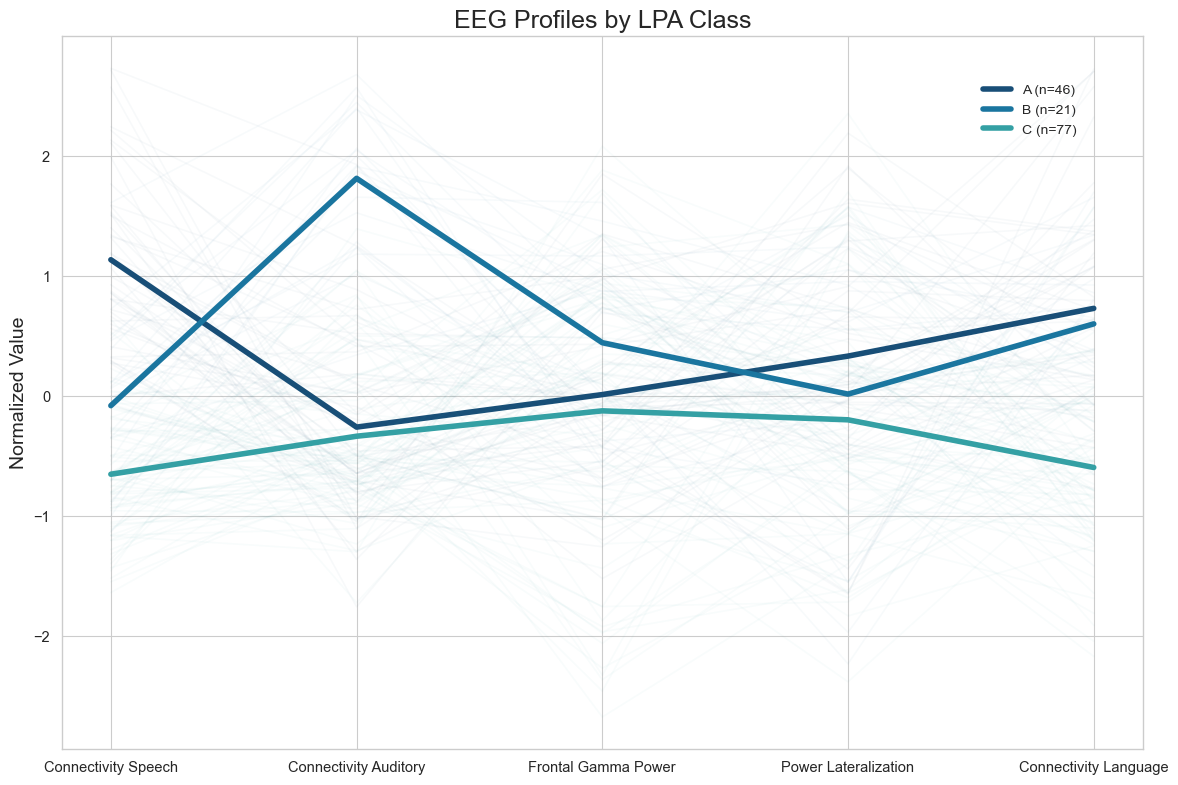

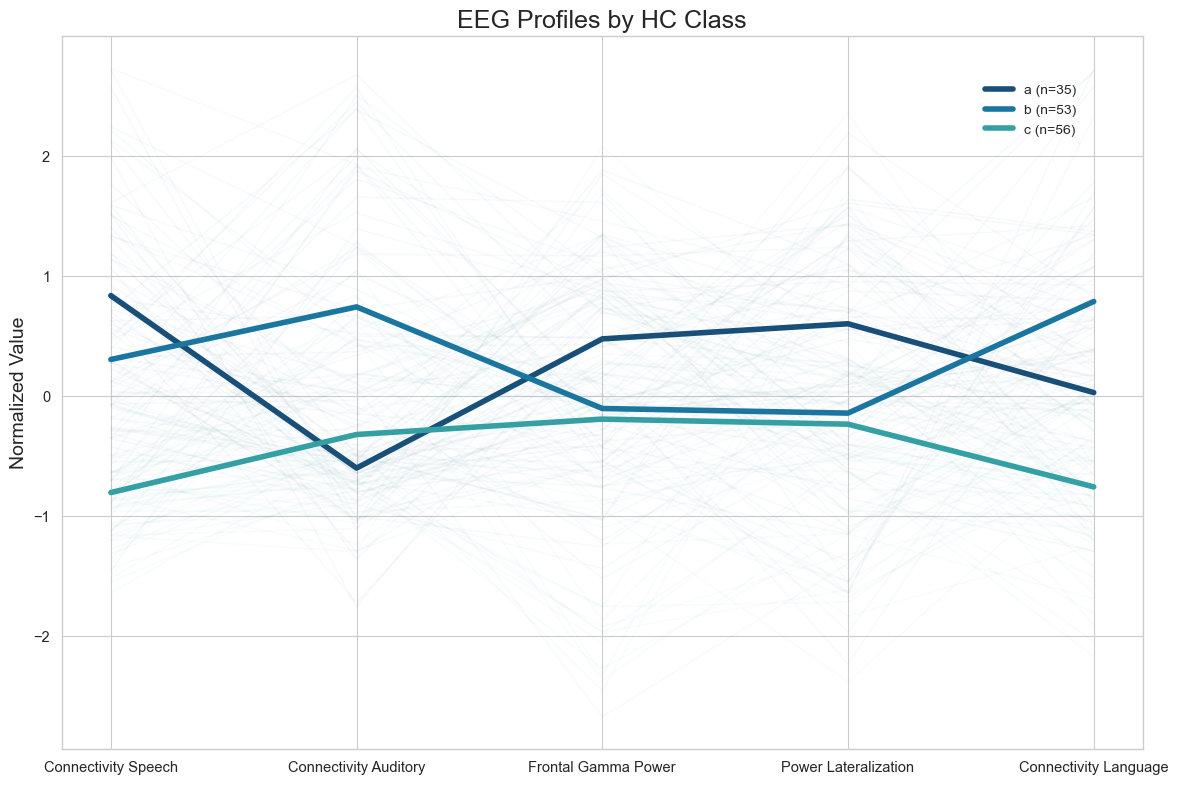

In [138]:
def parallel_coordinate_plot(data, cluster_col, method_name, colors=cluster_colors):
    """Create parallel coordinate plot for clusters"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get unique clusters
    clusters = data[cluster_col].unique()
    
    # Create plot for each cluster
    for cluster in sorted(clusters):
        # Get cluster data
        cluster_data = data[data[cluster_col] == cluster]
        
        # Plot cluster mean profile as thick line
        cluster_mean = cluster_data[measures].mean()
        
        # Plot individual profiles with high transparency
        for _, row in cluster_data.iterrows():
            ax.plot(measures, row[measures], color=colors[cluster], alpha=0.03)
        
        # Plot the mean with a thick line
        ax.plot(measures, cluster_mean, color=colors[cluster], linewidth=4,
                label=f'{cluster} (n={len(cluster_data)})')
    
    # Customize the plot
    ax.set_xticks(range(len(measures)))
    #ax.set_xticklabels(measures, rotation=45, ha='right')
    ax.grid(True, axis='y')
    
    # Add legend and title
    ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.95, 0.95))
    plt.title(f'EEG Profiles by {method_name} Class', fontsize=18)
    plt.ylabel('Normalized Value', fontsize=14)
    
    plt.tight_layout()

    plt.savefig(f"../../Figures/Supplementary/{date}/EEG_Profiles_{method_name}_Parallel.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create parallel coordinate plots for both clustering methods
parallel_coordinate_plot(normalized_df, "LPA Class", "LPA")
parallel_coordinate_plot(normalized_df, "HC Class", "HC")

### 3. Violin plots

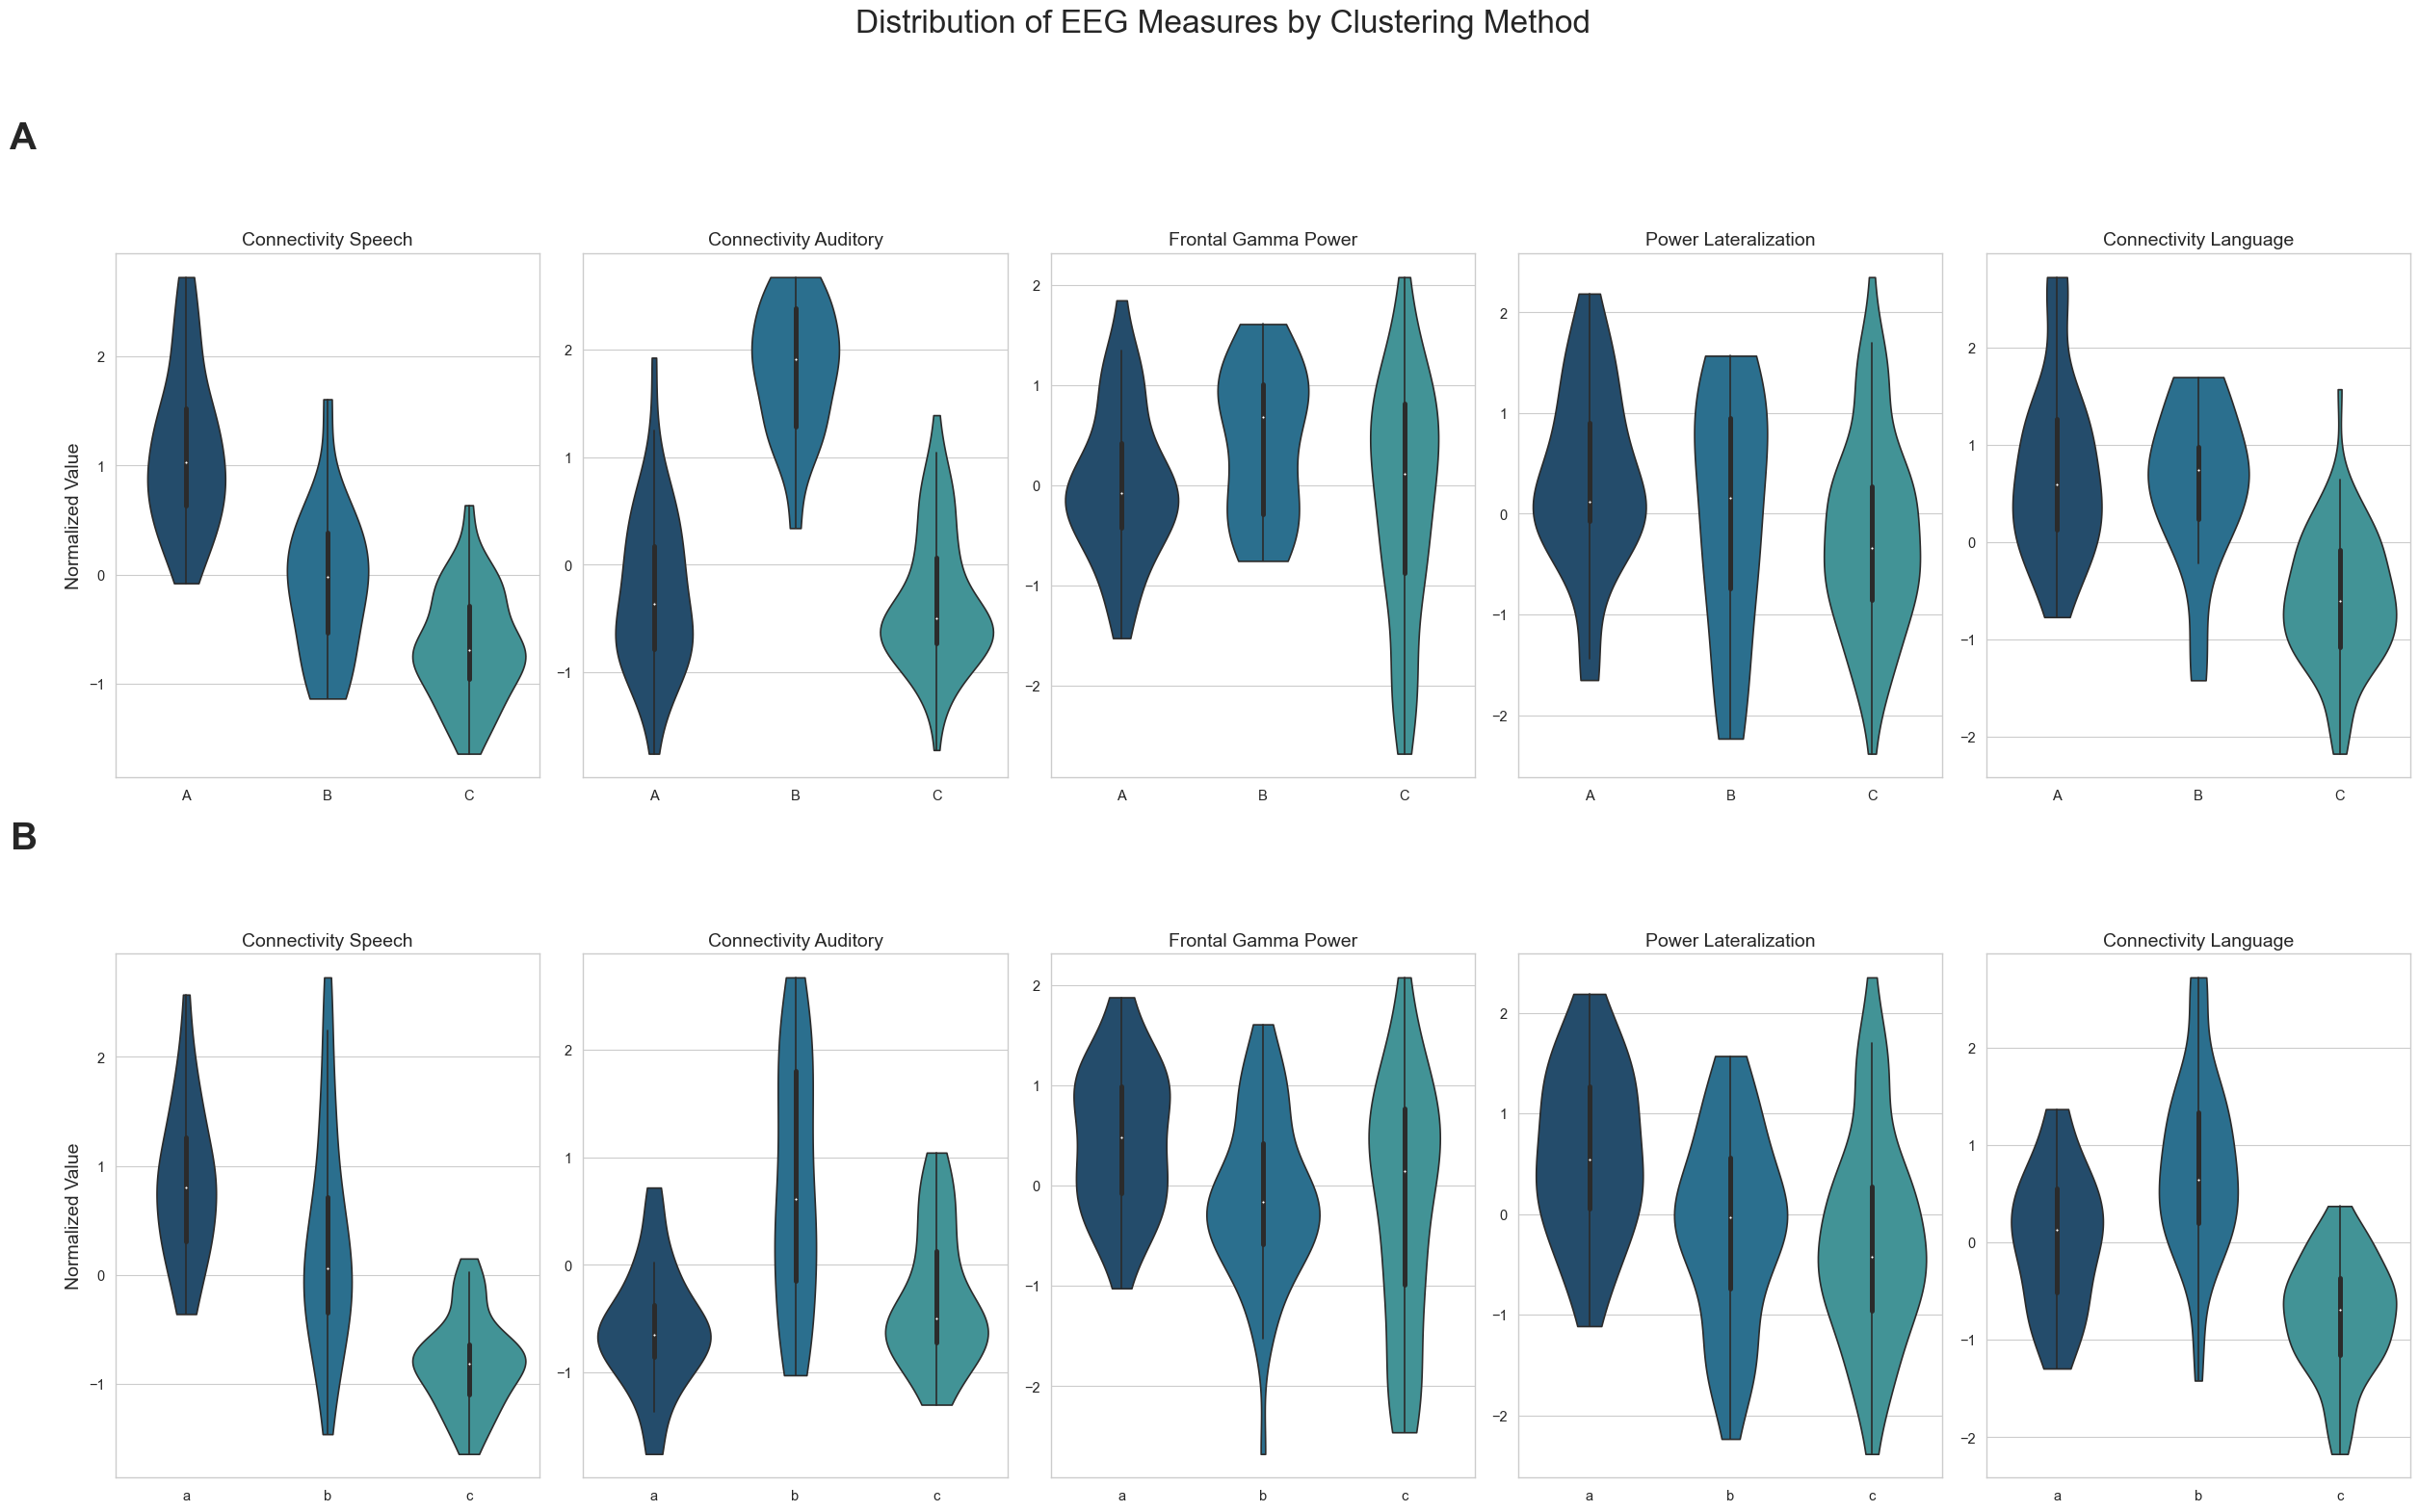

In [139]:

def combined_violin_plots(data, measures, method_cols, method_names, colors=cluster_colors):
    """Create a combined figure with two panels (A and B) using GridSpec for clean layout."""
    n_measures = len(measures)
    
    # Set up the figure and GridSpec
    fig = plt.figure(figsize=(5 * n_measures, 16))
    gs = gridspec.GridSpec(2, n_measures, height_ratios=[1, 1])
    
    for row, (method_col, method_name) in enumerate(zip(method_cols, method_names)):
        clusters = sorted(data[method_col].unique())
        palette = [colors[c] for c in clusters]
        
        for col, measure in enumerate(measures):
            ax = fig.add_subplot(gs[row, col])
            sns.violinplot(x=method_col, y=measure, data=data, ax=ax,
                           palette=palette, inner="box", cut=0)
            ax.set_title(measure, fontsize=14)
            ax.set_xlabel("")
            if col == 0:
                ax.set_ylabel("Normalized Value", fontsize=14)
            else:
                ax.set_ylabel("")
            

            # Add A/B labels only once per row
            if col == 0:
                ax.annotate(f"{chr(65+row)}", xy=(-0.25, 1.2), xycoords='axes fraction',
                            fontsize=28, fontweight='bold')
    
    plt.suptitle('Distribution of EEG Measures by Clustering Method', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"../../Figures/Supplementary/{date}/EEG_Profiles_Combined_Violin.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create combined violin plots for LPA and HC
combined_violin_plots(normalized_df, measures, ["LPA Class", "HC Class"], ["LPA", "HC"])


### 4. Enhances heatmap/dendogram


<Figure size 1000x800 with 0 Axes>

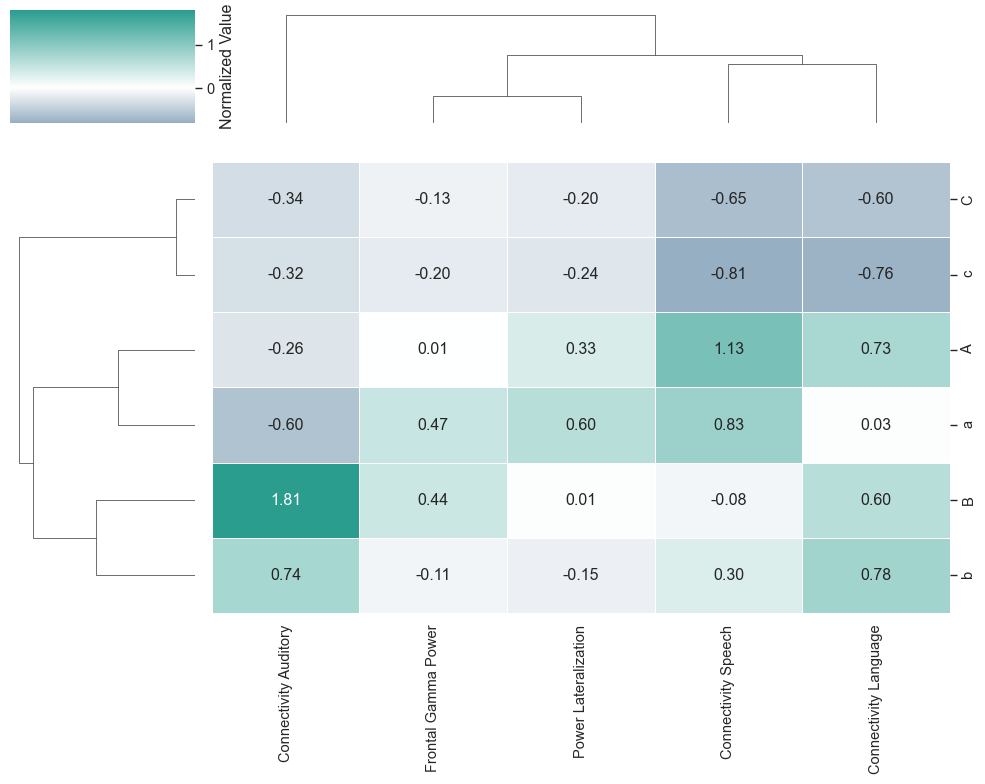

In [140]:
def enhanced_heatmap(lpa_profiles, hc_profiles, measures):
    """Create enhanced heatmap showing both clustering methods"""
    # Copy and prepare data
    lpa_data = lpa_profiles[measures].copy()
    hc_data = hc_profiles[measures].copy()
    
    # Add method identifier
    lpa_data['Method'] = 'LPA'
    hc_data['Method'] = 'HC'
    
    # Add cluster identifier
    lpa_data['Class'] = lpa_data.index.map(lambda x: f"LPA {x}")
    hc_data['Class'] = hc_data.index.map(lambda x: f"HC {x}")

    # For LPA classes
    lpa_data['sort_key'] = lpa_data.index.map(lambda x: {'A': 0, 'B': 1, 'C': 2}[x[0]])
    lpa_data = lpa_data.sort_values('sort_key').drop('sort_key', axis=1)

    # For HC classes
    hc_data['sort_key'] = hc_data.index.map(lambda x: {'a': 0, 'b': 1, 'c': 2}[x[0]])
    hc_data = hc_data.sort_values('sort_key').drop('sort_key', axis=1)
        
    # Add size information
    for i in lpa_data.index:
        lpa_data.loc[i, 'Size'] = int(lpa_profiles.loc[i, 'size'])
    for i in hc_data.index:
        hc_data.loc[i, 'Size'] = int(hc_profiles.loc[i, 'size'])
    
    # Combine data
    combined = pd.concat([lpa_data, hc_data])
    
    # Set up for clustering
    data_for_clustering = combined[measures].copy()
    
    # Create the figure
    fig = plt.figure(figsize=(10, 8))
    
    # Create diverging colormap from blue to white to green
    cmap = LinearSegmentedColormap.from_list("BlueWhiteGreen", 
                                            ['#184e77', '#ffffff', '#2a9d8f'])
    
    # Create the heatmap with hierarchical clustering
    g = sns.clustermap(data_for_clustering, method='average', metric='euclidean',
                    figsize=(10, 8), cmap=cmap, center=0,
                    row_cluster=True, col_cluster=True, 
                    linewidths=.5, annot=True, fmt=".2f",
                    cbar_kws={"label": "Normalized Value"})
    
    # Organize rows based on fixed order

        # Title
    
    plt.tight_layout()
    # Save the figure
    plt.savefig(f"../../Figures/Supplementary/{date}/EEG_Profiles_Combined_Heatmap.png", dpi=300, bbox_inches='tight')
# Create enhanced heatmap
enhanced_heatmap(profiles_lpa, profiles_hc, measures)


## 5. UMAP Projection

ValueError: The palette dictionary is missing keys: {'A', 'B', 'C'}

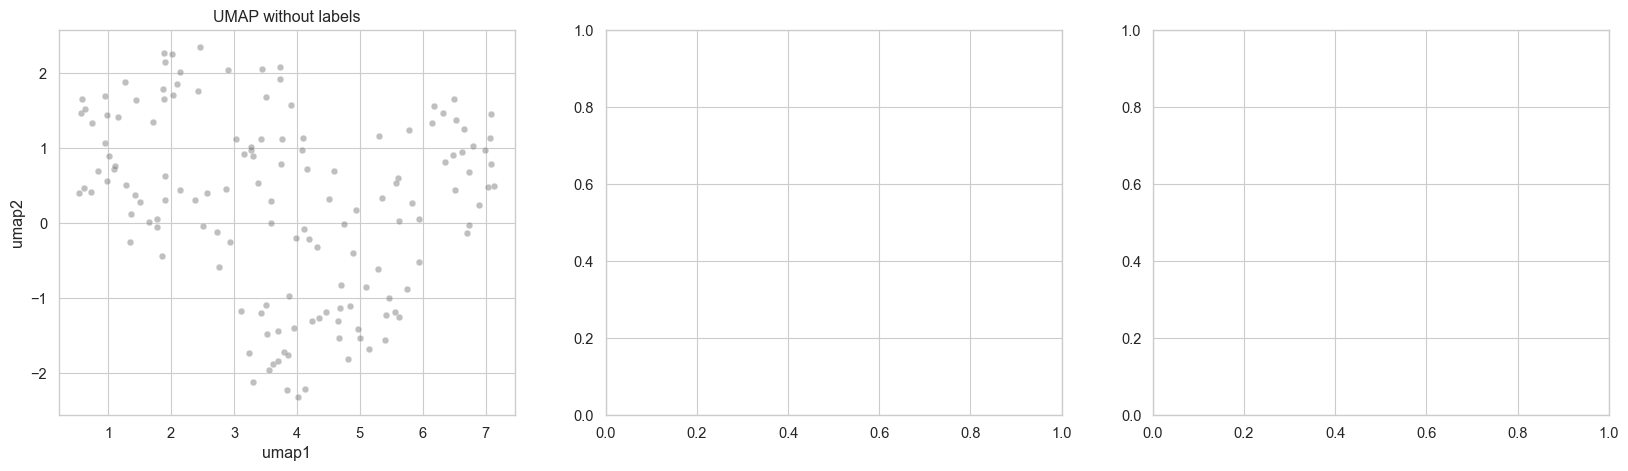

In [141]:
#### **2D UMAP**
# Create 3 subplots, one for the umpa no labels, one for the LPA classes and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot UMAP without labels
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("UMAP without labels")
# Plot UMAP with LPA classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("UMAP with LPA classes")
# Plot UMAP with HC classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["HC Class"], ax=axs[2], palette=palette, alpha=0.5)
axs[2].set_title("UMAP with HC classes")
# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/umap_2d_{date}.png", dpi=300, bbox_inches='tight')


Combined UMAP plot saved to ../../Figures/Supplementary/2025_04_23/EEG_UMAP2D_Projection.png
LPA Class UMAP plot saved to ../../Figures/Supplementary/2025_04_23/EEG_UMAP2D_LPA_Classes.png
HC Class UMAP plot saved to ../../Figures/Supplementary/2025_04_23/EEG_UMAP2D_HC_Classes.png


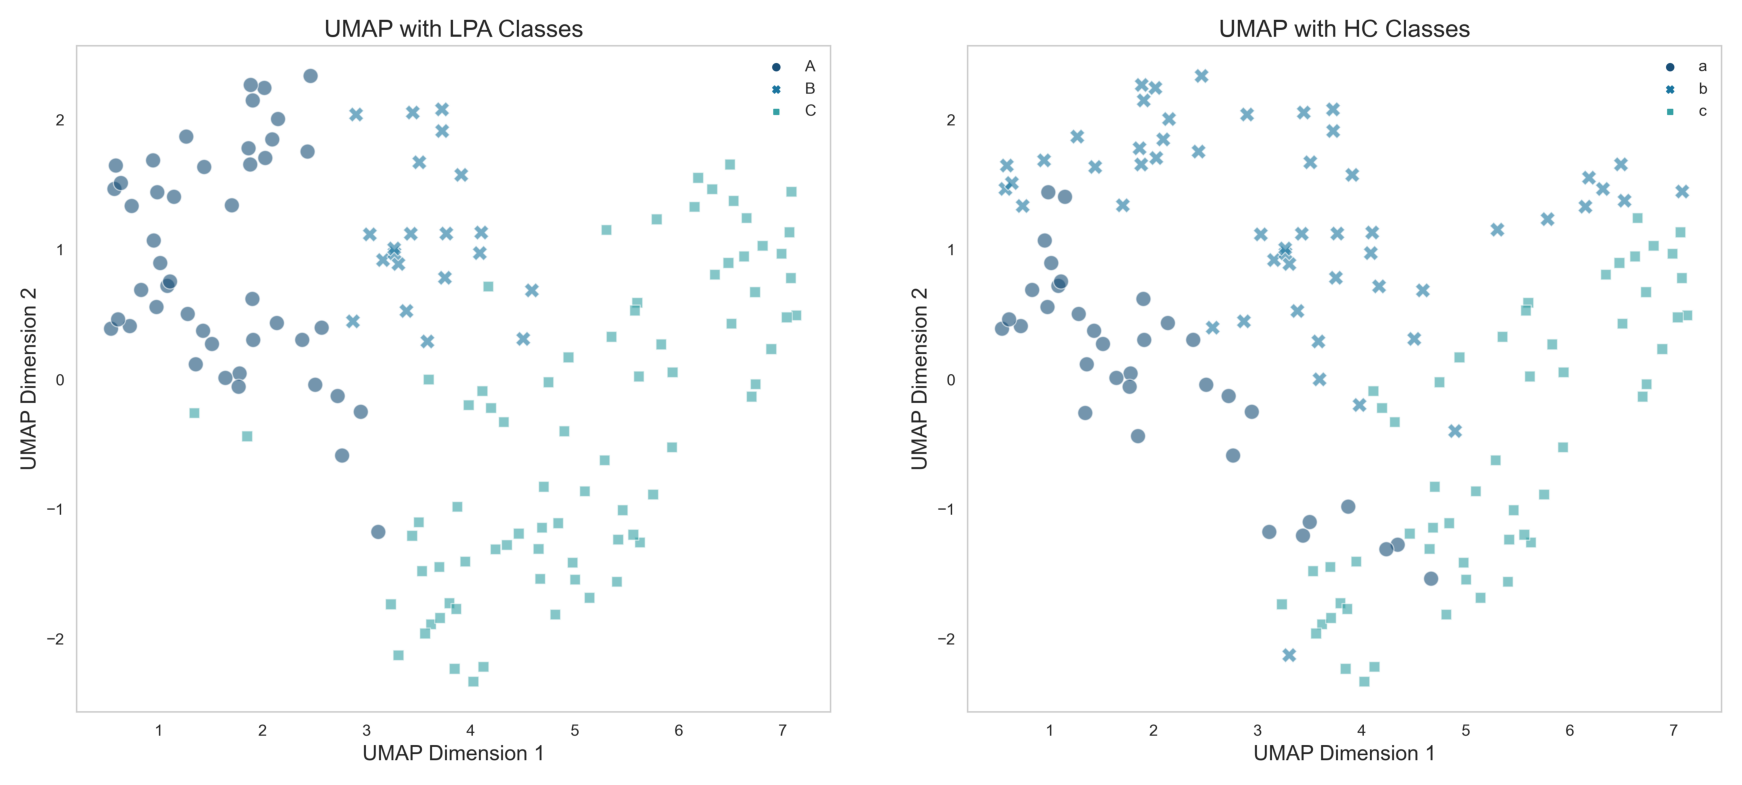

In [151]:
def umap_2d_projection(umap_df, labels_df, palette, date):
    """Create UMAP projections with different cluster overlays and save both combined and individual plots."""
    # Create output directory if it doesn't exist
    output_dir = f"../../Figures/Supplementary/{date}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Create combined plot (original version)
    fig_combined, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # UMAP with LPA classes
    sns.scatterplot(data=umap_df, x="umap1", y="umap2", hue=labels_df["LPA Class"], 
                    ax=axes[0], palette=palette, alpha=0.6, legend="full", s=100, style=labels_df["LPA Class"])
    axes[0].set_title('UMAP with LPA Classes', fontsize=16)
    
    # UMAP with HC classes
    sns.scatterplot(data=umap_df, x="umap1", y="umap2", hue=labels_df["HC Class"], 
                    ax=axes[1], palette=palette, alpha=0.6, legend="full", s=100, style=labels_df["HC Class"])
    axes[1].set_title('UMAP with HC Classes', fontsize=16)

    # Improve layout for combined plot
    for ax in axes:
        ax.grid(False)
        ax.set_xlabel("UMAP Dimension 1", fontsize=14)
        ax.set_ylabel("UMAP Dimension 2", fontsize=14)
        ax.legend(loc='best')

    plt.tight_layout()
    combined_path = f"{output_dir}/EEG_UMAP2D_Projection.png"
    plt.savefig(combined_path, dpi=300, bbox_inches='tight')
    plt.close(fig_combined)  # Close the combined figure to free memory
    print(f"Combined UMAP plot saved to {combined_path}")

    # 2. Create and save individual plots
    # LPA Class plot
    fig_lpa = plt.figure(figsize=(9, 8))
    ax_lpa = fig_lpa.add_subplot(111)
    sns.scatterplot(data=umap_df, x="umap1", y="umap2", hue=labels_df["LPA Class"], 
                   palette=palette, alpha=0.6, legend="full", s=100, style=labels_df["LPA Class"])
    ax_lpa.set_title('UMAP with LPA Classes', fontsize=16)
    ax_lpa.set_xlabel("UMAP Dimension 1", fontsize=14)
    ax_lpa.set_ylabel("UMAP Dimension 2", fontsize=14)
    ax_lpa.legend(loc='best')
    ax_lpa.grid(False)
    lpa_path = f"{output_dir}/EEG_UMAP2D_LPA_Classes.png"
    plt.savefig(lpa_path, dpi=300, bbox_inches='tight')
    plt.close(fig_lpa)
    print(f"LPA Class UMAP plot saved to {lpa_path}")

    # HC Class plot
    fig_hc = plt.figure(figsize=(9, 8))
    ax_hc = fig_hc.add_subplot(111)
    sns.scatterplot(data=umap_df, x="umap1", y="umap2", hue=labels_df["HC Class"], 
                   palette=palette, alpha=0.6, legend="full", s=100, style=labels_df["HC Class"])
    ax_hc.set_title('UMAP with HC Classes', fontsize=16)
    ax_hc.set_xlabel("UMAP Dimension 1", fontsize=14)
    ax_hc.set_ylabel("UMAP Dimension 2", fontsize=14)
    ax_hc.legend(loc='best')
    ax_hc.grid(False)
    hc_path = f"{output_dir}/EEG_UMAP2D_HC_Classes.png"
    plt.savefig(hc_path, dpi=300, bbox_inches='tight')
    plt.close(fig_hc)
    print(f"HC Class UMAP plot saved to {hc_path}")

    # Show the combined plot (optional)
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(plt.imread(lpa_path))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(plt.imread(hc_path))
    plt.axis('off')
    plt.tight_layout()
    plt.show()
# Create UMAP projection
umap_2d_projection(umap_df_2d, normalized_df, cluster_colors, date)

In [142]:
umap_colours={ 'A': '#26c6da', 'B': '#1a759f', 'C': '#0a3d62', 'a': '#26c6da', 'b': '#1a759f', 'c': '#0a3d62'} 

In [143]:
def umap_projection_3d(umap_df, labels_df, date, palette):
    """Create improved 3D UMAP projections colored by LPA and HC classes, saving as HTML and PNG."""

    # Add LPA and HC classes to the UMAP dataframe
    umap_df["LPA Class"] = labels_df["LPA Class"]
    umap_df["HC Class"] = labels_df["HC Class"]

    # Convert palette dictionary to ordered lists
    lpa_palette = [palette['A'], palette['B'], palette['C']]  
    hc_palette = [palette['a'], palette['b'], palette['c']]

    # Create a color map for LPA and HC classes
    lpa_palette = [lpa_palette[i] for i in range(len(lpa_palette))]
    hc_palette = [hc_palette[i] for i in range(len(hc_palette))]

    # Create 1x2 subplot
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=("UMAP with LPA Classes", "UMAP with HC Classes"),
        horizontal_spacing=0.01  # Less space between subplots
    )

    # Shared camera
    camera = dict(
     #   up=dict(x=0, y=0, z=1),
      #  center=dict(x=0, y=0, z=0),
      #  eye=dict(x=1.5, y=1.5, z=0.5)
              up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=2, y=1.5, z=1.5)
    )
    # Sort UMPAP data fbased on LPA and HC classe
    umap_df = umap_df.sort_values(by=["LPA Class"])

    # 1. LPA UMAP
    fig_lpa = px.scatter_3d(
        umap_df, x='umap1', y='umap2', z='umap3',
        color=umap_df["LPA Class"],
        color_discrete_sequence=lpa_palette,
        opacity=0.7,

        hover_name=umap_df["LPA Class"]
    )

    for trace in fig_lpa.data:
        fig.add_trace(trace.update(legendgroup='LPA', showlegend=True), row=1, col=1)

    # Sort UMAP data based on HC classes
    umap_df = umap_df.sort_values(by=["HC Class"])

    # 2. HC UMAP
    fig_hc = px.scatter_3d(
        umap_df, x='umap1', y='umap2', z='umap3',
        color=umap_df["HC Class"],
        color_discrete_sequence=hc_palette,
        opacity=0.7, 
        hover_name=umap_df["HC Class"]
    )

    for trace in fig_hc.data:
        fig.add_trace(trace.update(legendgroup='HC', showlegend=False), row=1, col=2)

    # Layout updates
    fig.update_layout(
        height=700,
        width=1400,
        margin=dict(l=20, r=20, t=50, b=20),
        scene=dict(camera=camera),
        scene2=dict(camera=camera),
                legend_title_text='Class',

        title_font=dict(size=20),
    )

    # Update each scene individually
    fig.update_scenes(camera=camera, row=1, col=1)
    fig.update_scenes(camera=camera, row=1, col=2)

    # Ensure output directory
    output_dir = f"../../Figures/Supplementary/{date}/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save as HTML
    fig.write_html(f"{output_dir}/EEG_UMAP_3D_Projection.html")

    # Save as PNG
    #fig.write_image(f"{output_dir}/EEG_UMAP_3D_Projection.png", width=1400, height=700, scale=2)

    fig.show()

# Create 3D UMAP projection
umap_projection_3d(umap_df_3d, plotting_df, date, umap_colours)

### 6. Cluster differentiation power

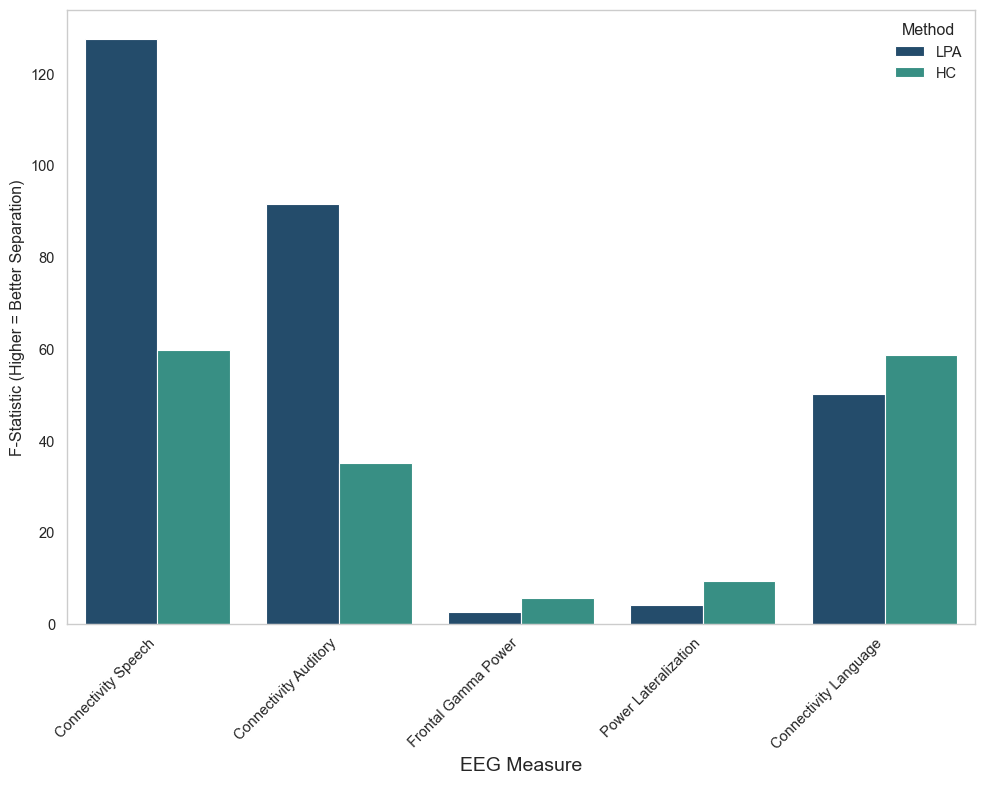

In [144]:

###########################################
# 6. CLUSTER DIFFERENTIATION POWER
###########################################

def cluster_differentiation_power(data, measures):
    """Create bar charts showing how each measure differentiates clusters"""
    
    # Calculate F-statistic for each measure for both clustering methods
    f_stats_lpa = {}
    f_stats_hc = {}
    
    for measure in measures:
        # For LPA: Calculate between-group variance / within-group variance
        groups_lpa = [data[data['LPA Class'] == c][measure] for c in sorted(data['LPA Class'].unique())]
        
        # Calculate group means and overall mean
        group_means_lpa = [g.mean() for g in groups_lpa]
        overall_mean_lpa = data[measure].mean()
        
        # Calculate between-group and within-group variances
        n_samples = len(data)
        n_groups = len(groups_lpa)
        
        between_var_lpa = sum([len(g) * (gm - overall_mean_lpa)**2 for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_lpa = sum([sum((g - gm)**2) for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        
        # Calculate F-statistic
        f_stats_lpa[measure] = between_var_lpa / within_var_lpa if within_var_lpa > 0 else 0
        
        # Repeat for HC
        groups_hc = [data[data['HC Class'] == c][measure] for c in sorted(data['HC Class'].unique())]
        group_means_hc = [g.mean() for g in groups_hc]
        overall_mean_hc = data[measure].mean()
        
        between_var_hc = sum([len(g) * (gm - overall_mean_hc)**2 for g, gm in zip(groups_hc, group_means_hc)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_hc = sum([sum((g - gm)**2) for g, gm in zip(groups_hc, group_means_hc)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        
        f_stats_hc[measure] = between_var_hc / within_var_hc if within_var_hc > 0 else 0
    
    # Create DataFrame for plotting
    f_stat_df = pd.DataFrame({
        'Measure': list(f_stats_lpa.keys()) * 2,
        'F-Statistic': list(f_stats_lpa.values()) + list(f_stats_hc.values()),
        'Method': ['LPA'] * len(measures) + ['HC'] * len(measures)
    })
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Use different colors for each method
    sns.barplot(x='Measure', y='F-Statistic', hue='Method', data=f_stat_df,
              palette={'LPA': '#184e77', 'HC': '#2a9d8f'})
    

    # Customize plot
    plt.xlabel('EEG Measure', fontsize=14)
    plt.ylabel('F-Statistic (Higher = Better Separation)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(False)
    
    plt.tight_layout()
    plt.savefig(f"../../Figures/Supplementary/{date}/EEG_Class_Differentiation_Power.png", dpi=300, bbox_inches='tight')


    plt.show()

# Create differentiation power plot
cluster_differentiation_power(normalized_df, measures)


In [145]:
normalized_df

Frontal Gamma Power  Connectivity Auditory  Connectivity Language  \
0              -0.493375               0.091716               2.573154   
1               0.262605              -0.708993               0.071701   
2              -2.062992              -0.690122              -0.656346   
3              -0.950743               0.677772              -0.537582   
4              -0.858837              -0.487253              -0.432078   
..                   ...                    ...                    ...   
139             0.596665              -0.568656              -0.544815   
140            -0.587502               1.918149               1.694759   
141             0.189308              -0.477100              -1.239995   
142             0.006792               0.467966               1.187249   
143             0.007357               2.061507               0.806124   

     Connectivity Speech  Power Lateralization LPA Class HC Class  
0               1.139389              0.022771         A        b  
1              -0.933383              0.167193         C        c  
2              -0.002112             -0.541724         C        c  
3              -1.397818             -2.383233         C        c  
4               0.150907             -1.682449         C        c  
..                   ...                   ...       ...      ...  
139            -0.280481              0.195884         C        c  
140            -0.298238             -1.552500         B        b  
141            -1.318751             -0.063540         C        c  
142             2.211642             -1.441595         A        b  
143            -0.713670             -1.970557         B        b  

[144 rows x 7 columns]

## Distribution plots for each measure

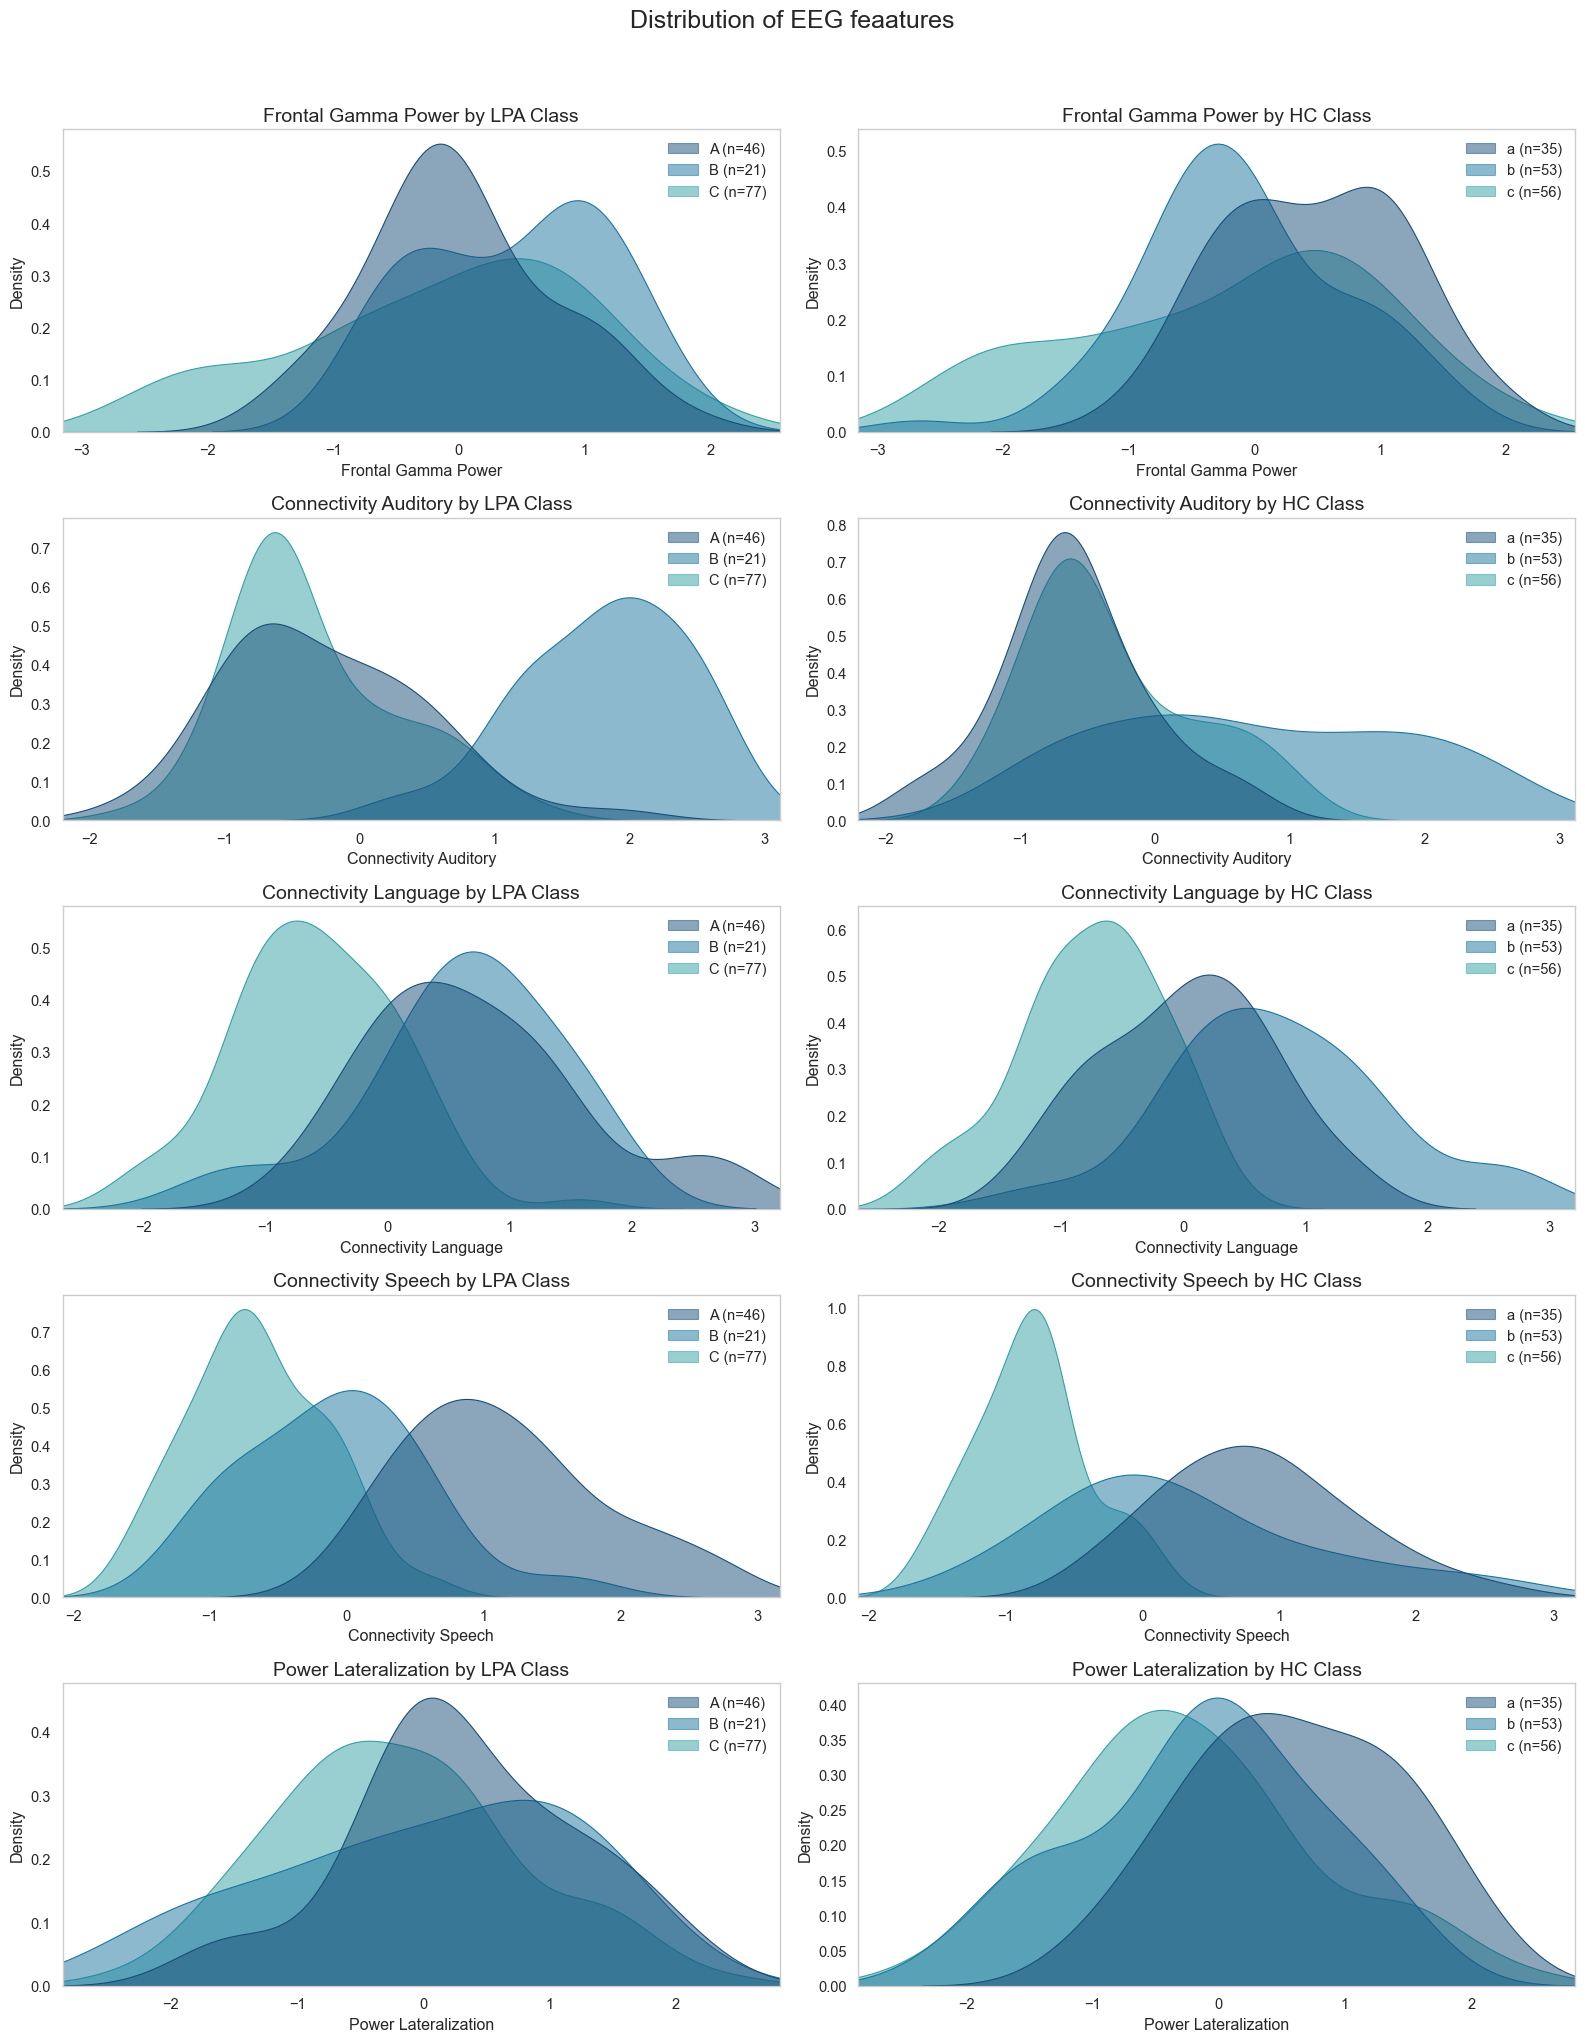

In [146]:

def improved_distribution_plots(data, measures):
    """Create improved distribution plots for each measure"""
    # Create figure with subplots - one row per measure
    fig, axes = plt.subplots(len(measures), 2, figsize=(16, 4*len(measures)))
    
    # Set up color palettes
    lpa_palette = {c: cluster_colors[c] for c in sorted(data['LPA Class'].unique())}
    hc_palette = {c: cluster_colors[c] for c in sorted(data['HC Class'].unique())}
    
    # Create distribution plots
    for i, measure in enumerate(measures):
        # LPA distributions - use KDE plots for cleaner look
        sns.kdeplot(data=data, x=measure, hue="LPA Class", palette=lpa_palette, 
                  fill=True, common_norm=False, alpha=0.5, ax=axes[i, 0])
        
        # HC distributions
        sns.kdeplot(data=data, x=measure, hue="HC Class", palette=hc_palette, 
                   fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
        
        # Set titles and labels
        axes[i, 0].set_title(f"{measure} by LPA Class", fontsize=14)
        axes[i, 1].set_title(f"{measure} by HC Class", fontsize=14)

        # Remove grid lines for cleaner look
        axes[i, 0].grid(False)
        axes[i, 1].grid(False)
        
        # Add legend with sample sizes
        for j, method_col in enumerate(["LPA Class", "HC Class"]):
            handles = []
            labels = []
            for c in sorted(data[method_col].unique()):
                size = len(data[data[method_col] == c])
                handle = mpatches.Patch(color=cluster_colors[c], alpha=0.5)
                handles.append(handle)
                labels.append(f"{c} (n={size})")
            axes[i, j].legend(handles=handles, labels=labels)
            
            # Standardize x-axis range for direct comparison
            value_range = data[measure].max() - data[measure].min()
            buffer = value_range * 0.1
            x_min = data[measure].min() - buffer
            x_max = data[measure].max() + buffer
            axes[i, j].set_xlim(x_min, x_max)
    
    # Global title
    plt.suptitle('Distribution of EEG feaatures', fontsize=18, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f"../../Figures/Main/EEG_Measure_Long_Distributions_{date}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create improved distribution plots
improved_distribution_plots(normalized_df, clean_eeg_vars)


Figure 1 saved to ../../Figures/Main//Figure1_EEG_Profiles_Combined_2025_04_23.png


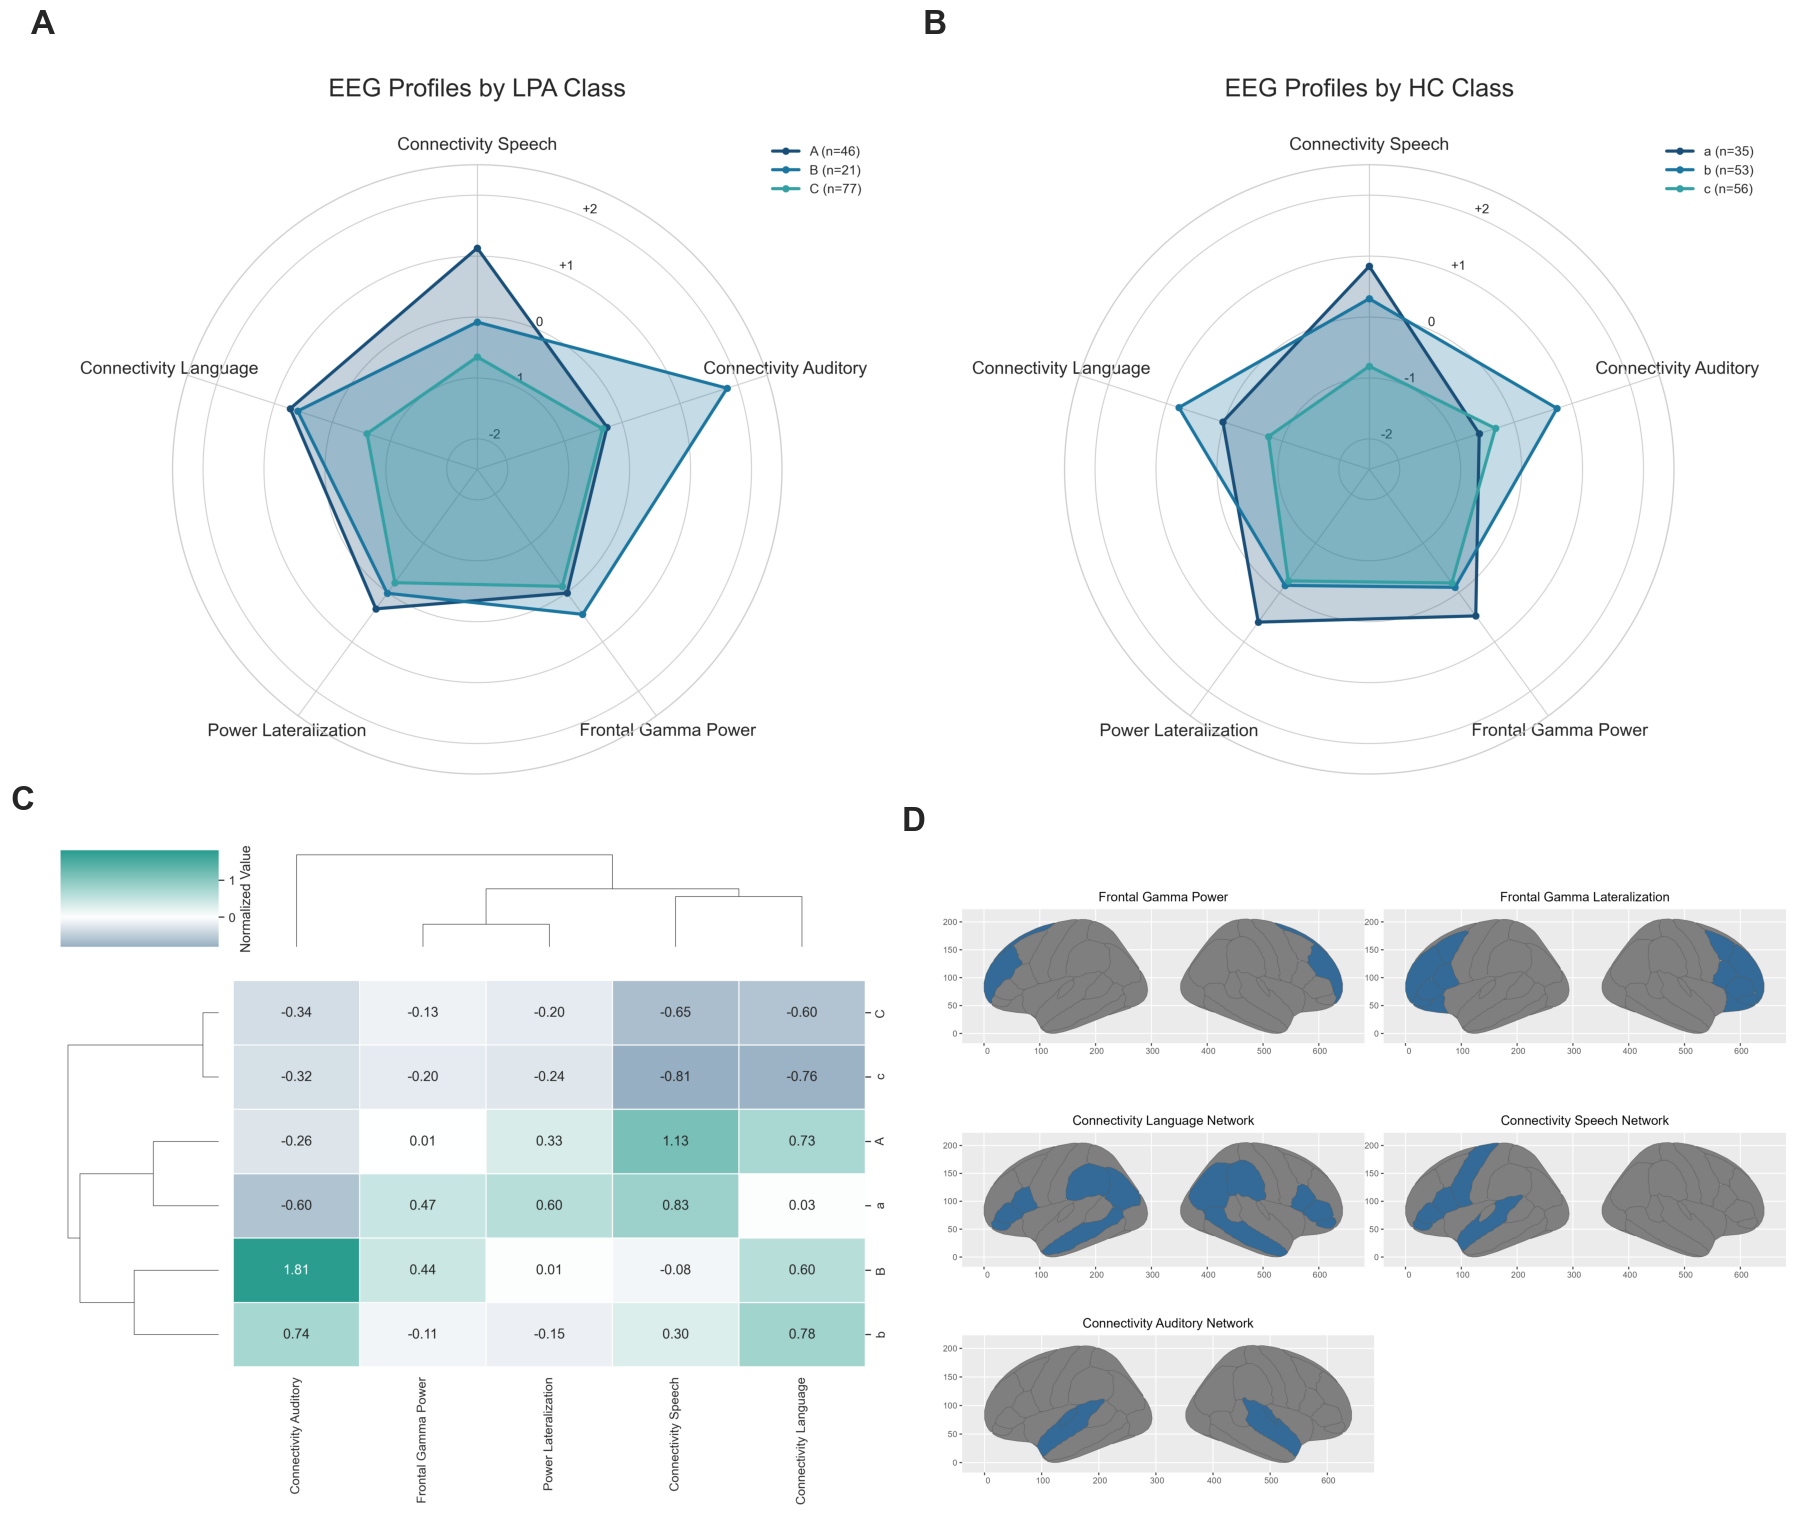

In [148]:

def create_composite_figure_1(input_dir="S", output_dir="S", date="S"):
    """
    Creates Figure 1: EEG Class Profiles and Relationships
    - Panel A: LPA Radar Plot
    - Panel B: HC Radar Plot
    - Panel C: Enhanced Heatmap with Dendrogram
    - Panel D: Cluster Differentiation Power Bar Chart
    """
    # Create figure with a complex layout
    fig = plt.figure(figsize=(18, 16))
    
    # Create GridSpec for layout control
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
    
    # Load images
    radar_lpa_img = Image.open(f"{input_dir}/EEG_Profiles_LPA_Radar.png")
    radar_hc_img = Image.open(f"{input_dir}/EEG_Profiles_HC_Radar.png")
    heatmap_img = Image.open(f"{input_dir}/EEG_Profiles_Combined_Heatmap.png")
    #diff_power_img = Image.open(f"{input_dir}/EEG_Class_Differentiation_Power.png")
    diff_power_img = Image.open(f"{input_dir}/brain_regions_combined.png")
    # Add subplots and images
    # Panel A: LPA Radar Plot
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(np.array(radar_lpa_img))
    ax1.axis('off')
    ax1.text(-0.05, 1.05, 'A', transform=ax1.transAxes, fontsize=24, fontweight='bold')
    
    # Panel B: HC Radar Plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(np.array(radar_hc_img))
    ax2.axis('off')
    ax2.text(-0.05, 1.05, 'B', transform=ax2.transAxes, fontsize=24, fontweight='bold')
    
    # Panel C: Heatmap with Dendrogram
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.imshow(np.array(heatmap_img))
    ax3.axis('off')
    ax3.text(-0.05, 1.05, 'C', transform=ax3.transAxes, fontsize=24, fontweight='bold')
    
    # Panel D: Differentiation Power
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.imshow(np.array(diff_power_img))
    ax4.axis('off')
    ax4.text(-0.05, 1.05, 'D', transform=ax4.transAxes, fontsize=24, fontweight='bold')
    

    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"{output_dir}/Figure1_EEG_Profiles_Combined_{date}.png", dpi=300, bbox_inches='tight')
    # Save as pdf
    plt.savefig(f"{output_dir}/Figure1_EEG_Profiles_Combined_{date}.pdf", dpi=300, bbox_inches='tight')
    #plt.close()
    print(f"Figure 1 saved to {output_dir}/Figure1_EEG_Profiles_Combined_{date}.png")

\

# Create Figure 1
create_composite_figure_1(input_dir=f"../../Figures/Supplementary/{date}", output_dir=f"../../Figures/Main/", date =date)



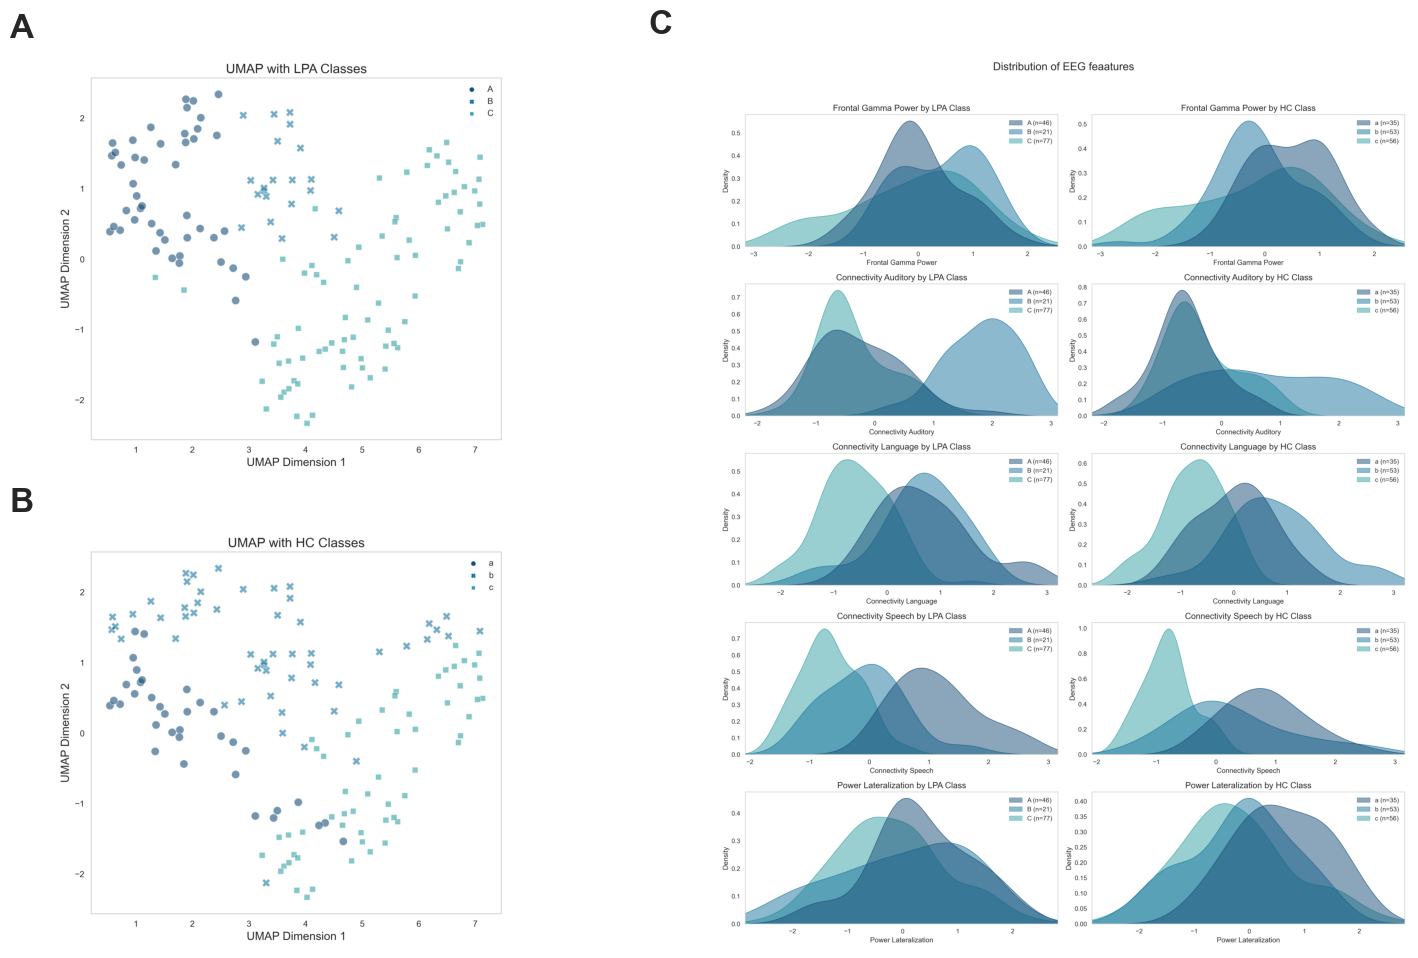

Figure 2 saved to:
- ../../Figures/Main//Figure2_EEG_Distributions_Combined_2025_04_23.png
- ../../Figures/Main//Figure2_EEG_Distributions_Combined_2025_04_23.pdf


In [152]:
def create_composite_figure_2(input_dir, output_dir, date):
    """
    Creates Figure 2: EEG Feature Distribution and Projection
    - Left Panel: UMAP 2D with LPA Classes (top) and HC Classes (bottom)
    - Right Panel: Distribution plots of key measures
    Now uses individual UMAP plots instead of splitting the combined image
    """
    # Create figure with layout
    fig = plt.figure(figsize=(16, 10))
    
    # Create GridSpec for layout control - 2 rows, 2 columns with different width ratios
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[0.8, 1.2])
    
    # Load individual images
    umap_lpa_img = Image.open(f"{input_dir}/EEG_UMAP2D_LPA_Classes.png")
    umap_hc_img = Image.open(f"{input_dir}/EEG_UMAP2D_HC_Classes.png")
    distribution_img = Image.open(f"{output_dir}/EEG_Measure_Long_Distributions_{date}.png")
    
    # Panel A: UMAP 2D projection - LPA Classes (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(np.array(umap_lpa_img))
    ax1.axis('off')
    ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=24, fontweight='bold')
    
    # Panel B: UMAP 2D projection - HC Classes (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(np.array(umap_hc_img))
    ax2.axis('off')
    ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=24, fontweight='bold')
    
    # Panel C: Distribution plots (right side spanning both rows)
    ax3 = fig.add_subplot(gs[:, 1])
    ax3.imshow(np.array(distribution_img))
    ax3.axis('off')
    ax3.text(-0.1, 1.028, 'C', transform=ax3.transAxes, fontsize=24, fontweight='bold')
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save as PNG
    png_path = f"{output_dir}/Figure2_EEG_Distributions_Combined_{date}.png"
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    
    # Save as PDF
    pdf_path = f"{output_dir}/Figure2_EEG_Distributions_Combined_{date}.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    
    plt.show()

    print(f"Figure 2 saved to:\n- {png_path}\n- {pdf_path}")

# Create Figure 2
create_composite_figure_2(
    input_dir=f"../../Figures/Supplementary/{date}",
    output_dir=f"../../Figures/Main/",
    date=date
)


Figure saved to ../../Figures/Main//Figure3_Language_Development_Analysis_2025_04_23.png


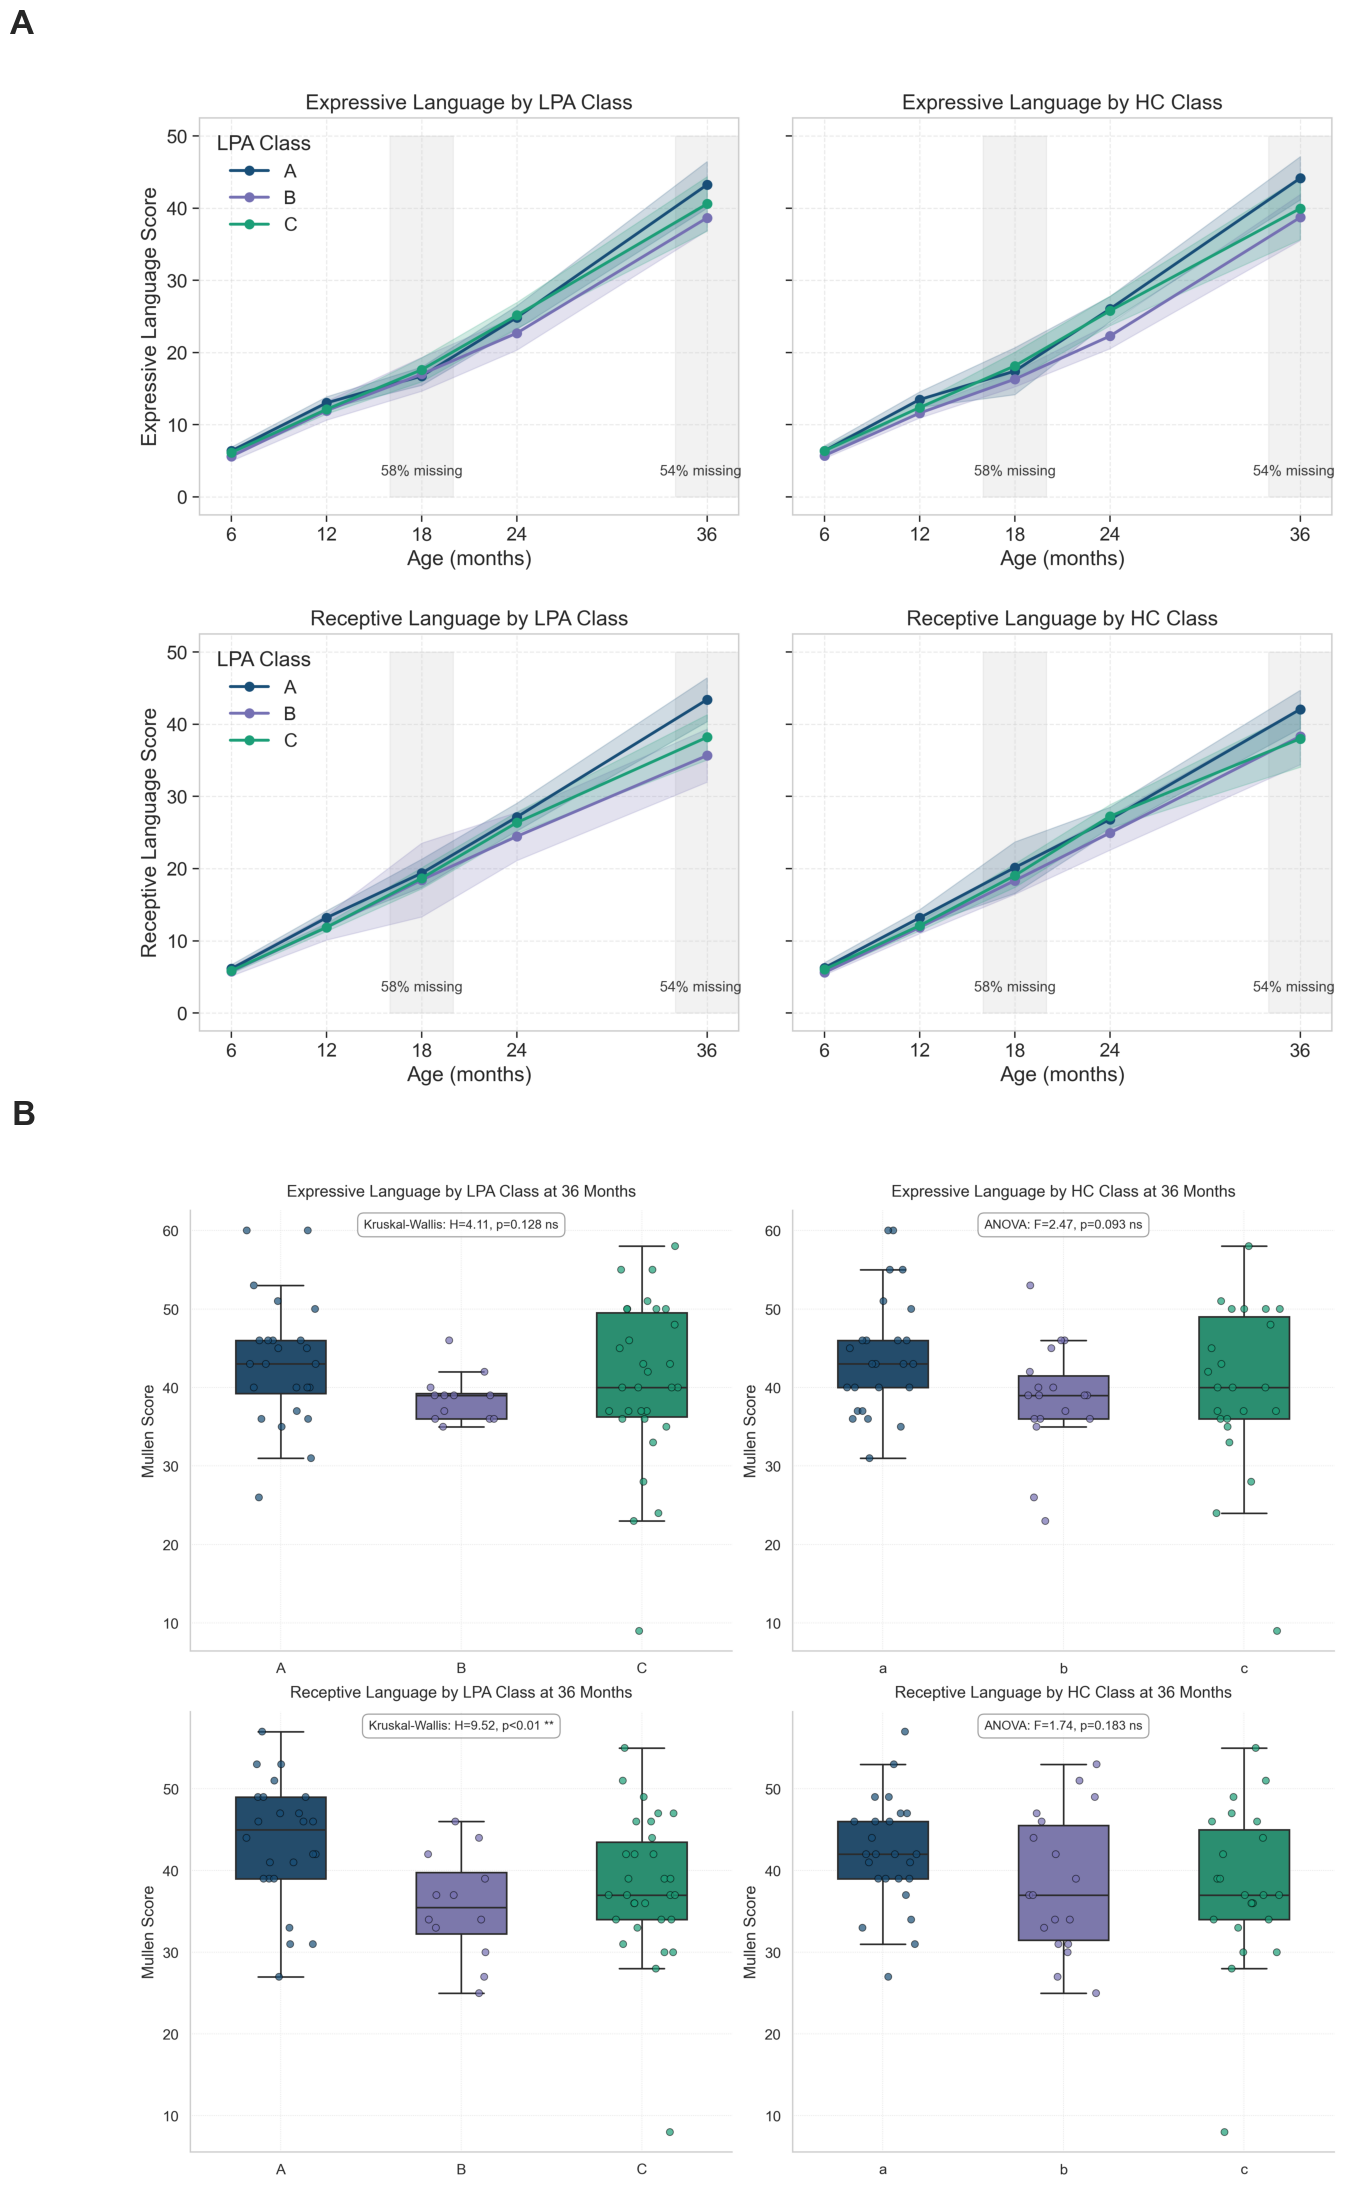

In [150]:
# Language trajectories 
def create_composite_figure_3(input_dir, output_dir, date):
    """
    Creates a 2-panel figure:
    - Panel A: Language Development Trajectories
    - Panel B: Language Analysis at 36 months
    """
    # Create figure with layout
    fig = plt.figure(figsize=(16, 22))  # Wider aspect ratio for 2 panels

    # Create GridSpec (1 row, 2 columns)
    gs = gridspec.GridSpec(2, 1,)

    # Load images
    lang_traj_img = Image.open(f"{output_dir}/language_trajectories_{date}.png")
    lang_36mo_img = Image.open(f"{input_dir}/language_analysis_36months_{date}.png")

    # Panel A: Language Trajectories
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(np.array(lang_traj_img))
    ax1.axis('off')
    ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=24, fontweight='bold')

    # Panel B: 36-month Analysis
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(np.array(lang_36mo_img))
    ax2.axis('off')
    ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=24, fontweight='bold')

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f"{output_dir}/Figure3_Language_Development_Analysis_{date}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{output_dir}/Figure3_Language_Development_Analysis_{date}.pdf", bbox_inches='tight')
    #plt.close()

    print(f"Figure saved to {output_dir}/Figure3_Language_Development_Analysis_{date}.png")

# Create the figure
create_composite_figure_3(input_dir=f"../../Figures/Supplementary/{date}",
    output_dir=f"../../Figures/Main/", date=date)